In [1]:
# === SETUP ===
from unsloth import FastLanguageModel
from datasets import load_dataset
import torch
import os

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
#Enable segmented memory allocator (for fragmentation)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [4]:
# Environment setup for Triton stability on T4
os.environ["TRITON_DISABLE_LINE_INFO"] = "1"
os.environ["TRITON_CC"] = "75"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

torch.cuda.empty_cache()
print(f"[Init] Memory: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

[Init] Memory: 0.00 GB


In [5]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-14B",
    max_seq_length = 1024,
    load_in_4bit = True,
    load_in_8bit = False,
    full_finetuning = False,
    device_map = "auto",
)

==((====))==  Unsloth 2025.8.4: Fast Qwen3 patching. Transformers: 4.55.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.581 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


<string>:37: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
torch.cuda.empty_cache()
print(f"[Post Load] Memory: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

[Post Load] Memory: 10.41 GB


In [7]:
# === Apply LoRA adapters ===
model = FastLanguageModel.get_peft_model(
    model,
    r = 8,           # Choose any number > 0! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,  # Best to choose alpha = rank or rank*2
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,   # We support rank stabilized LoRA
    loftq_config = None,  # And LoftQ
)

torch.cuda.empty_cache()
print(f"[Post LoRA] Memory: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

Unsloth 2025.8.4 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


[Post LoRA] Memory: 10.53 GB


In [8]:
# === PHASE 3: Formatting function using chat template ===
def qa_formatting_func(example):
    is_batch = isinstance(example["question"], list)
    questions = example["question"] if is_batch else [example["question"]]
    answers   = example["answer"] if is_batch else [example["answer"]]
    
    formatted = []
    for q, a in zip(questions, answers):
        if q and a:
            conversation = [
                {"role": "system", "content": "You are a helpful assistant specializing in insurance and surplus lines regulations."},
                {"role": "user", "content": q.strip()},
                {"role": "assistant", "content": a.strip()}
            ]
            formatted.append(tokenizer.apply_chat_template(conversation, tokenize=False))
    
    return formatted

In [9]:
# === Load dataset from JSON file ===
json_path = "QA-Phase1.json"
dataset = load_dataset("json", data_files=json_path, split="train")

In [10]:
# Keep only 'question' and 'answer'
dataset = dataset.remove_columns([col for col in dataset.column_names if col not in {"question", "answer"}])


In [11]:
# === Validation split ===
dataset = dataset.train_test_split(test_size=0.1, seed=3407)
train_dataset = dataset["train"]
eval_dataset  = dataset["test"]

In [12]:
# === PHASE 2: SFTTrainer configuration ===
from trl import SFTTrainer, SFTConfig

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    formatting_func = qa_formatting_func,
    args = SFTConfig(
        per_device_train_batch_size  = 1,           # Increased from 1
        gradient_accumulation_steps = 8,            # Reduced from 8
        num_train_epochs            = 15,
        learning_rate               = 2e-4,          # Lower for stability
        logging_steps               = 1,
        optim                       = "adamw_8bit",
        weight_decay                = 0.01,
        lr_scheduler_type           = "cosine",
        warmup_steps                = 300,
        max_grad_norm              = 1.0,
        seed                        = 3407,
        report_to                   = "none",
        packing                     = False,         # Disabled for T4 stability
        save_steps                  = 100,
        output_dir                  = "qwen14b_sft_outputs",
        save_total_limit            = 2
    )
)

In [13]:
# === Optional: GPU info + memory before training ===
gpu_stats = torch.cuda.get_device_properties(0)
print(f"[GPU Info] {gpu_stats.name}, total memory = {gpu_stats.total_memory / 1024**3:.2f} GB")


[GPU Info] Tesla T4, total memory = 14.58 GB


In [14]:
torch.cuda.empty_cache()
print(f"[Before Training] Memory: {torch.cuda.memory_allocated()/1024**3:.2f} GB")


[Before Training] Memory: 10.53 GB


In [ ]:
# === Monitoring Setup ===
import threading, time, psutil
import pynvml
import matplotlib.pyplot as plt

# Initialize NVIDIA GPU monitoring
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)

# Storage for system usage logs
timestamps = []
gpu_mem_used = []
gpu_util = []
cpu_util = []
ram_used = []
disk_used = []

def monitor_system(interval=5):
    while monitor_active:
        timestamps.append(time.time())

        # GPU stats
        mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        util = pynvml.nvmlDeviceGetUtilizationRates(handle)
        gpu_mem_used.append(mem_info.used / 1024 / 1024)  # MB
        gpu_util.append(util.gpu)                         # %

        # CPU, RAM, Disk
        cpu_util.append(psutil.cpu_percent())
        ram_used.append(psutil.virtual_memory().used / 1024 / 1024)  # MB
        disk_used.append(psutil.disk_usage('/').percent)

        time.sleep(interval)

# Start monitoring
monitor_active = True
monitor_thread = threading.Thread(target=monitor_system, daemon=True)
monitor_thread.start()

# === Start Training ===
trainer_stats = trainer.train()

# Stop monitoring
monitor_active = False
monitor_thread.join()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 7,176 | Num Epochs = 15 | Total steps = 13,455
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 8 x 1) = 8
 "-____-"     Trainable parameters = 32,112,640 of 14,800,419,840 (0.22% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,3.448100
2,4.304100
3,3.872500
4,3.892400
5,4.223700
6,4.095200
7,3.679600
8,4.182200
9,3.770800
10,3.530300


In [ ]:
logs = trainer.state.log_history

train_steps, train_loss = [], []
eval_steps, eval_loss = [], []

for log in logs:
    if "loss" in log and "step" in log:
        train_steps.append(log["step"])
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        if "step" in log:
            eval_steps.append(log["step"])

# Fallback if eval logs don't carry 'step'
if eval_loss and (len(eval_steps) != len(eval_loss)):
    if train_steps:
        eval_steps = np.linspace(min(train_steps), max(train_steps), num=len(eval_loss))
    else:
        eval_steps = list(range(len(eval_loss)))

# --- Plot (larger) ---
plt.figure(figsize=(16, 9), dpi=120)
plt.plot(train_steps, train_loss, label="Training Loss", linewidth=2)
if eval_loss:
    plt.plot(eval_steps, eval_loss, label="Eval Loss", linestyle="--", linewidth=2)

# Tick settings: steps every 500, loss every 0.5
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(500))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))   # ~every 100 if major is 500
ax.yaxis.set_minor_locator(AutoMinorLocator(5))   # ~every 0.1 if major is 0.5

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss")
plt.grid(True, which="both", linestyle=":", linewidth=0.7, alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

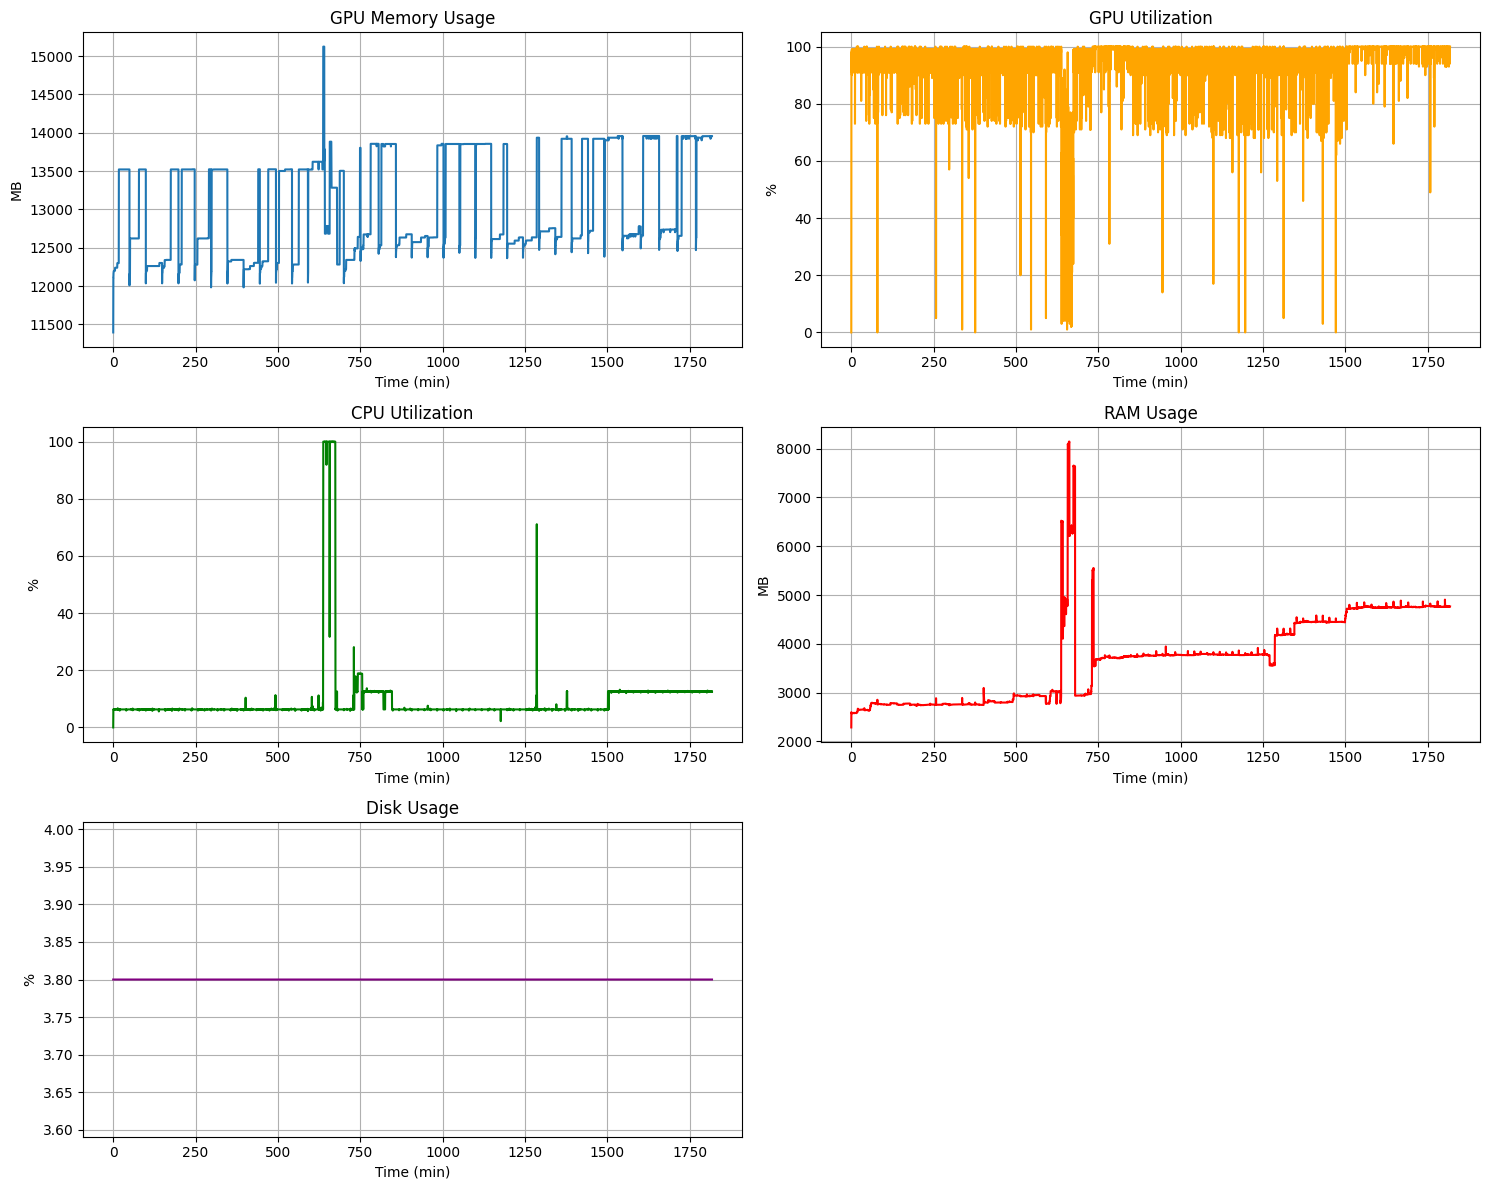

In [17]:
# === Plot GPU, CPU, RAM, and Disk Usage ===
start_time = timestamps[0]
time_rel = [(t - start_time)/60 for t in timestamps]  # minutes

plt.figure(figsize=(15, 12))

plt.subplot(3, 2, 1)
plt.plot(time_rel, gpu_mem_used, label="GPU Mem (MB)")
plt.title("GPU Memory Usage")
plt.xlabel("Time (min)"); plt.ylabel("MB"); plt.grid()

plt.subplot(3, 2, 2)
plt.plot(time_rel, gpu_util, label="GPU Util (%)", color='orange')
plt.title("GPU Utilization")
plt.xlabel("Time (min)"); plt.ylabel("%"); plt.grid()

plt.subplot(3, 2, 3)
plt.plot(time_rel, cpu_util, label="CPU Util (%)", color='green')
plt.title("CPU Utilization")
plt.xlabel("Time (min)"); plt.ylabel("%"); plt.grid()

plt.subplot(3, 2, 4)
plt.plot(time_rel, ram_used, label="RAM Used (MB)", color='red')
plt.title("RAM Usage")
plt.xlabel("Time (min)"); plt.ylabel("MB"); plt.grid()

plt.subplot(3, 2, 5)
plt.plot(time_rel, disk_used, label="Disk Used (%)", color='purple')
plt.title("Disk Usage")
plt.xlabel("Time (min)"); plt.ylabel("%"); plt.grid()

plt.tight_layout()
plt.show()


In [18]:
import random
from tqdm import tqdm
import torch

def print_random_generated_answers(model, tokenizer, eval_dataset, num_samples=20):
    model.eval()

    if len(eval_dataset) < num_samples:
        print(f"Dataset only has {len(eval_dataset)} samples.")
        return

    samples = random.sample(list(eval_dataset), num_samples)

    for i, sample in enumerate(tqdm(samples, desc="Generating Random QA")):
        question = sample["question"]
        true_answer = sample["answer"]

        # Qwen-style prompt
        conversation = [
            {"role": "system", "content": "You are a helpful assistant specializing in insurance and surplus lines regulations.Answer the questions only from the training data"},
            {"role": "user", "content": question.strip()}
        ]
        prompt = tokenizer.apply_chat_template(
            conversation,
            tokenize=False,
            add_generation_prompt=True
        )

        # Tokenize and send to model's device
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        # Generate model's answer
        with torch.no_grad():
            output_ids = model.generate(
                **inputs,
                max_new_tokens=512,
                do_sample=False,
                temperature=0.0,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )

        # Extract generated part only
        generated = tokenizer.decode(
            output_ids[0][inputs['input_ids'].shape[1]:],
            skip_special_tokens=True
        ).strip()

        # Print nicely
        print(f"\n--- Sample {i + 1} ---")
        print(f"Question:\n{question.strip()}\n")
        print(f"Ground Truth Answer:\n{true_answer.strip()}\n")
        print(f"Model's Answer:\n{generated}")
        print("=" * 70)


In [19]:
print_random_generated_answers(model, tokenizer, eval_dataset, num_samples=150)

Generating Random QA:   1%|▏                    | 1/150 [00:17<44:21, 17.87s/it]


--- Sample 1 ---
Question:
What is media wrongful act (cyber coverage)?

Ground Truth Answer:
Media wrongful act coverage, found in some network security liability insurance policies, may cover any negligent act, error, or omission by the insured. Additional Information The injury must result in copyright, trademark, or service mark infringement; misappropriation of intellectual property rights; disparagement, libel, patent infringement; wrongful eviction, interference with rights of privacy, occupancy entry; plagiarism; reputational harm; and other such risks as detailed in the particular policy. Such policies may also cover the insured for misappropriation or misdirection of the lnternet content messages of third parties by the insured. This would include metatags, website names and domains, and other cyber information. Related Terms cyber and privacy insurance media liability coverage

Model's Answer:
<think>

</think>

Media wrongful act coverage is a type of cyber and media liabi

Generating Random QA:   1%|▎                    | 2/150 [00:20<22:13,  9.01s/it]


--- Sample 2 ---
Question:
What is the statutory reference to the insurance code in Wyoming for the requirements of insurance procurement through a full-time insurance manager or buyer?

Ground Truth Answer:
The statutory reference is §26-12-101.

Model's Answer:
<think>

</think>

The statutory reference is §26-12-101.


Generating Random QA:   2%|▍                    | 3/150 [00:23<15:31,  6.33s/it]


--- Sample 3 ---
Question:
Are surplus lines carriers permitted to operate in the U.S. Virgin Islands?

Ground Truth Answer:
No, surplus lines carriers are not permitted to operate in the U.S. Virgin Islands.

Model's Answer:
<think>

</think>

No, surplus lines carriers are not permitted to operate in the U.S. Virgin Islands.


Generating Random QA:   3%|▌                    | 4/150 [00:30<15:42,  6.46s/it]


--- Sample 4 ---
Question:
In Minnesota, when can the insurance commissioner waive the minimum capital and surplus requirement for unauthorized foreign insurers?

Ground Truth Answer:
The insurance commissioner may waive the requirement after making an affirmative finding of acceptability based on specified factors.

Model's Answer:
<think>

</think>

The insurance commissioner may waive the requirement if an affirmative finding of acceptability is made after considering various factors, as specified in Minn. Stat. § 60A.206 (Subd. 3)(b).


Generating Random QA:   3%|▋                    | 5/150 [00:33<12:43,  5.26s/it]


--- Sample 5 ---
Question:
What does the Nonadmitted Insurance Model Act aim to ensure?

Ground Truth Answer:
The Nonadmitted Insurance Model Act aims to ensure the payment of premium taxes and compliance with regulatory requirements.

Model's Answer:
<think>

</think>

The Act aims to ensure that nonadmitted insurance policies provide adequate protection to policyholders.


Generating Random QA:   4%|▊                    | 6/150 [00:41<15:08,  6.31s/it]


--- Sample 6 ---
Question:
What exemption does Montana provide for producers regarding the diligent search requirement for surplus lines coverage?

Ground Truth Answer:
Producers are exempt if the premium quoted by an authorized insurer is at least 10% higher than the rate quoted by the unauthorized, eligible surplus lines insurer, as per Mont. Code Ann. § 33-2-302(2)(b).

Model's Answer:
<think>

</think>

Montana exempts producers from the diligent search requirement if the premium quoted by an authorized insurer is at least 10% higher than the rate quoted by the unauthorized, eligible surplus lines insurer, as per Mont. Code Ann. § 33-2-302(2)(b).


Generating Random QA:   5%|▉                    | 7/150 [00:45<13:03,  5.48s/it]


--- Sample 7 ---
Question:
What is the deadline for a surplus-lines carrier in Massachusetts to file its annual statement with the state?

Ground Truth Answer:
Surplus-lines carriers in Massachusetts must file their annual statements with the state by March 1st of each year.

Model's Answer:
<think>

</think>

A surplus-lines carrier in Massachusetts must file its annual statement with the state by July 31 of each year.


Generating Random QA:   5%|█                    | 8/150 [00:49<11:18,  4.78s/it]


--- Sample 8 ---
Question:
Where can surplus-lines professionals find information on eligible insurers in Texas?

Ground Truth Answer:
Surplus Lines Service Office of Texas provides a list of eligible insurers at https://www.sltx.org/insurers/eligible-insurer-list/eligible-insurers/.

Model's Answer:
<think>

</think>

Surplus-lines professionals can find information on eligible insurers in Texas at https://www.tdi.


Generating Random QA:   6%|█▎                   | 9/150 [00:53<10:56,  4.66s/it]


--- Sample 9 ---
Question:
In which state do regulators tend to recognize the NAIC’s Quarterly Listing of Alien Insurers as the approved list of eligible nonadmitted insurers?

Ground Truth Answer:
Many U.S. jurisdictions tend to recognize the NAIC’s Quarterly Listing of Alien Insurers as the approved list of eligible nonadmitted insurers.

Model's Answer:
<think>

</think>

State regulators in general tend to recognize the NAIC’s Quarterly Listing of Alien Insurers as the approved list of eligible nonadmitted insurers.


Generating Random QA:   7%|█▎                  | 10/150 [00:56<09:47,  4.20s/it]


--- Sample 10 ---
Question:
When is the examination fee due for producers in Louisiana?

Ground Truth Answer:
The examination fee of $1,050 is due on March 1 in Louisiana.

Model's Answer:
<think>

</think>

The examination fee is due when producers file their annual statement, as stated in Louisiana regulations.


Generating Random QA:   7%|█▍                  | 11/150 [01:00<09:40,  4.17s/it]


--- Sample 11 ---
Question:
What was the underwriting expense ratio for the U.S. P&C industry in 2023?

Ground Truth Answer:
The underwriting expense ratio for the U.S. Property & Casualty industry in 2023 was 27%.

Model's Answer:
<think>

</think>

The underwriting expense ratio for the U.S. Property & Casualty industry in 2023 was 25%.


Generating Random QA:   8%|█▌                  | 12/150 [01:06<10:30,  4.57s/it]


--- Sample 12 ---
Question:
Why does the Department of Insurance in Wyoming request premium and policy information from surplus lines insurers?

Ground Truth Answer:
The information is necessary to reconcile premiums written by surplus lines insurers with those reported by non-admitted filers, such as surplus line brokers.

Model's Answer:
<think>

</think>

The Department of Insurance in Wyoming requests premium and policy information from surplus lines insurers to include the information in their database and to reconcile it with the information received from nonadmitted filers.


Generating Random QA:   9%|█▋                  | 13/150 [01:10<10:12,  4.47s/it]


--- Sample 13 ---
Question:
What is the eligibility requirement for foreign insurers in New Mexico?

Ground Truth Answer:
Foreign insurers in New Mexico must comply with the provisions outlined in N.M. Stat.

Model's Answer:
<think>

</think>

New Mexico may not prohibit a foreign insurer from becoming eligible by merely becoming listed on the NAIC’s Quarterly Listing of Alien Insurers.


Generating Random QA:   9%|█▊                  | 14/150 [01:16<11:03,  4.88s/it]


--- Sample 14 ---
Question:
What is the non-refundable filing fee for surplus-lines transactions in Colorado if the company's premium is $10,000,001 and over?

Ground Truth Answer:
The non-refundable filing fee is $5,775 for surplus-lines transactions in Colorado if the company's premium is $10,000,001 and over.

Model's Answer:
<think>

</think>

The non-refundable filing fee is $4,275 for surplus-lines transactions in Colorado if the company's premium is $10,000,001 and over.


Generating Random QA:  10%|██                  | 15/150 [01:23<12:18,  5.47s/it]


--- Sample 15 ---
Question:
What is robbery and safe burglary coverage?

Ground Truth Answer:
Robbery and safe burglary coverage is a type of policy that insures against the loss of money and securities by robbery or safe burglary. Additional Information There are two standard forms that provide this coverage. The Insurance Services Office, Inc. (ISO), Crime Form (CR 00 18) insures against the loss of money and securities by robbery or safe burglary. Prior to October 1990, the Robbery and Safe Burglary Form (form D) was endorsed to provide this coverage. A separate coverage part is now available. ISO Crime Form (CR 00 05) insures against the loss of property, other than money and securities, by robbery or safe burglary. Synonyms Safe Burglary Insurance

Model's Answer:
<think>

</think>

Robbery and safe burglary coverage is inland marine crime coverage for property other than money and securities. Additional Information A standard Robbery and Safe Burglary Coverage Form (CR 00 18) is

Generating Random QA:  11%|██▏                 | 16/150 [01:25<10:11,  4.56s/it]


--- Sample 16 ---
Question:
In Georgia, does the state maintain a list of eligible surplus lines insurers?

Ground Truth Answer:
No, Georgia does not maintain a list of eligible surplus lines insurers.

Model's Answer:
<think>

</think>

Yes, Georgia maintains a list of eligible surplus lines insurers.


Generating Random QA:  11%|██▎                 | 17/150 [01:28<09:20,  4.22s/it]


--- Sample 17 ---
Question:
In which states are ECP transactions likely treated as an additional category of the export list?

Ground Truth Answer:
States with export lists will likely treat ECP transactions as an additional category of the export list.

Model's Answer:
<think>

</think>

ECP transactions are likely treated as an additional category of the export list in ECP-friendly states.


Generating Random QA:  12%|██▍                 | 18/150 [01:33<09:13,  4.20s/it]


--- Sample 18 ---
Question:
Are non-admitted insurers in California required to file documents with the CDI if they are available from the NAIC or other public sources?

Ground Truth Answer:
No, if any of the documents required under Cal. Ins. Code § 1765.2 are available from the NAIC or other public source, the insurer does not need to file those documents with the CDI.

Model's Answer:
<think>

</think>

No, they are not required to file documents with the CDI if they are available from the NAIC or other public sources.


Generating Random QA:  13%|██▌                 | 19/150 [01:47<15:48,  7.24s/it]


--- Sample 19 ---
Question:
What is knock-for-knock indemnity?

Ground Truth Answer:
Knock-for-knock is a form of indemnity that is used in energy industry contracts. Additional Information Knock-for-knock indemnity is reciprocal in nature and is based on ownership of property and personnel as opposed to allocating risk based on fault. Each party to an oil and gas contract agrees to take responsibility for and to indemnify the other party against injury and loss to its own property and personnel. Related Terms cross-indemnity agreement indemnification indemnity contract indemnity

Model's Answer:
<think>

</think>

Knock-for-knock indemnity is a type of aircraft hull insurance that covers the insured for damage to third parties' property without regard to fault. Additional Information Under such coverage, the insured is indemnified for the full amount of the claim, even if the insured's aircraft was at fault. The term "knock-for-knock" derives from the fact that, in the absence of fau

Generating Random QA:  13%|██▋                 | 20/150 [01:50<12:52,  5.94s/it]


--- Sample 20 ---
Question:
In California, who is qualified to sign a surplus-lines policy?

Ground Truth Answer:
In California, a surplus-lines policy may be signed by a property and casualty underwriter.

Model's Answer:
<think>

</think>

In California, a surplus-lines policy may be signed by a certified risk manager.


Generating Random QA:  14%|██▊                 | 21/150 [01:53<10:58,  5.11s/it]


--- Sample 21 ---
Question:
Which states shifted from having surplus lines associations to dissolving them?

Ground Truth Answer:
Iowa, Michigan, North Dakota, South Carolina, and Wisconsin shifted from having surplus lines associations to dissolving them.

Model's Answer:
<think>

</think>

Mississippi, Arkansas, and Louisiana shifted from having surplus lines associations to dissolving them.


Generating Random QA:  15%|██▉                 | 22/150 [01:57<09:57,  4.67s/it]


--- Sample 22 ---
Question:
What was the loss ratio for cyber insurance in the U.S. in 2024?

Ground Truth Answer:
The loss ratio for cyber insurance in the U.S. in 2024 was 45%.

Model's Answer:
<think>

</think>

The loss ratio for cyber insurance in the U.S. in 2024 was 65%.


Generating Random QA:  15%|███                 | 23/150 [02:00<09:04,  4.28s/it]


--- Sample 23 ---
Question:
In California, how soon must an approved surplus-lines carrier provide a policyholder's claim information upon written request?

Ground Truth Answer:
The carrier must provide the claim information within 30 days of receiving the written request, as per Cal. Ins. Code §1763.1.

Model's Answer:
<think>

</think>

The carrier must provide the claim information within 30 days of receiving the written request in California.


Generating Random QA:  16%|███▏                | 24/150 [02:03<08:13,  3.92s/it]


--- Sample 24 ---
Question:
Which state issues orders prohibiting the use of specific surplus lines insurers by surplus lines brokers?

Ground Truth Answer:
Some states issue orders that particular surplus lines insurers cannot be used.

Model's Answer:
<think>

</think>

Arkansas issues orders prohibiting the use of specific surplus lines insurers by surplus lines brokers.


Generating Random QA:  17%|███▎                | 25/150 [02:09<09:19,  4.48s/it]


--- Sample 25 ---
Question:
What information must the declaration page of each policy in Nebraska include?

Ground Truth Answer:
The declaration page must include the licensee’s name, business address, surplus lines license number, the name under which the licensee transacts business if different, and the language: 'This policy is issued by a nonadmitted insurer, and in the event of the insolvency of such insurer, this policy will not be covered.'

Model's Answer:
<think>

</think>

The declaration page must include the licensee’s name, business address, surplus lines license number, the name under which the licensee transacts business if different, and the language regarding the insurer's insolvency.


Generating Random QA:  17%|███▍                | 26/150 [02:18<11:51,  5.74s/it]


--- Sample 26 ---
Question:
In New York, what information must a cover note, binder, or other evidence of insurance contain for the named insured?

Ground Truth Answer:
The cover note must contain a summary of all material facts that would regularly be included in the policy, the description and location of the subject of insurance, a general description of the coverages of the insurance, the premium and rate charged, taxes to be collected from the insured, and the name and address of the insured.

Model's Answer:
<think>

</think>

The cover note must contain a summary of all material facts that would regularly be included in the policy, the description and location of the subject of insurance, a general description of the coverages of the insurance, the premium and rate charged, taxes to be collected from the insured, and the name and address of the insured.


Generating Random QA:  18%|███▌                | 27/150 [02:23<11:25,  5.57s/it]


--- Sample 27 ---
Question:
What is the application fee for a surplus-lines carrier in Oklahoma?

Ground Truth Answer:
The application fee for a surplus-lines carrier in Oklahoma is $1,000.

Model's Answer:
<think>

</think>

The application fee for a surplus-lines carrier in Oklahoma is the greater of a $1,000 application fee or a $10,000 security deposit.


Generating Random QA:  19%|███▋                | 28/150 [02:26<09:46,  4.81s/it]


--- Sample 28 ---
Question:
What requirement did Virginia eliminate regarding due diligence for surplus-lines brokers?

Ground Truth Answer:
Virginia eliminated the due diligence requirement for surplus-lines brokers.

Model's Answer:
<think>

</think>

Virginia eliminated the requirement for surplus-lines brokers to conduct a diligent search before placing coverage.


Generating Random QA:  19%|███▊                | 29/150 [02:28<08:24,  4.17s/it]


--- Sample 29 ---
Question:
What types of insurance on railroads are exempt from surplus-lines regulation in Colorado?

Ground Truth Answer:
Insurance on the operations of railroads engaged in interstate commerce is exempt from surplus-lines regulation in Colorado.

Model's Answer:
<think>

</think>

Insurance on the property or operation of railroads engaged in interstate commerce.


Generating Random QA:  20%|████                | 30/150 [02:32<07:56,  3.97s/it]


--- Sample 30 ---
Question:
What exemptions are available for industrial insureds in Kentucky?

Ground Truth Answer:
Kentucky has an industrial insured exemption as well as a statutory exempt commercial purchaser exemption.

Model's Answer:
<think>

</think>

Kentucky has an industrial insured exemption that waives the diligent search requirement for certain qualified industrial insureds.


Generating Random QA:  21%|████▏               | 31/150 [02:37<08:40,  4.38s/it]


--- Sample 31 ---
Question:
How does the surplus-lines premium tax calculation differ in New York compared to other states?

Ground Truth Answer:
In New York, the surplus-lines premium tax calculation is based on a tiered percentage of U.S. gross liabilities, while in other states, it may follow different methods.

Model's Answer:
<think>

</think>

In New York, the surplus-lines premium tax is calculated at 3.6% of gross premiums, unlike other states where it is 100% of gross premiums.


Generating Random QA:  21%|████▎               | 32/150 [02:41<08:18,  4.23s/it]


--- Sample 32 ---
Question:
What is the minimum capital and surplus requirement for an unauthorized insurer in Arkansas?

Ground Truth Answer:
An unauthorized insurer in Arkansas must have capital and surplus equal to the greater of the state's minimum requirements or a minimum of $15,000,000.

Model's Answer:
<think>

</think>

The insurer must maintain capital and surplus of at least $15 million to be eligible for surplus lines coverage in Arkansas.


Generating Random QA:  22%|████▍               | 33/150 [02:44<07:36,  3.90s/it]


--- Sample 33 ---
Question:
What is the title of the document?

Ground Truth Answer:
NAIC Nonadmitted Insurance Model Act #870

Model's Answer:
<think>

</think>

The title of the document is 'Journal of Insurance Regulation - Surplus Lines Market Analysis.'


Generating Random QA:  23%|████▌               | 34/150 [02:48<07:31,  3.89s/it]


--- Sample 34 ---
Question:
How many persons should the board of directors of the association consist of?

Ground Truth Answer:
The board of directors of the association shall consist of not less than five (5) nor more than nine (9) persons.

Model's Answer:
<think>

</think>

The board of directors of the association should consist of not fewer than 15 nor more than 25 persons.


Generating Random QA:  23%|████▋               | 35/150 [02:54<08:37,  4.50s/it]


--- Sample 35 ---
Question:
What happens if the tax owed by a surplus lines licensee is not paid within the prescribed time?

Ground Truth Answer:
If the tax owed by a surplus lines licensee is not paid within the prescribed time, it shall be recoverable in a suit brought by the commissioner against the surplus lines licensee and the surety on the bond.

Model's Answer:
<think>

</think>

If the tax owed by a surplus lines licensee is not paid within the prescribed time, a penalty of 10% of the tax owed is imposed, up to a maximum of $100.


Generating Random QA:  24%|████▊               | 36/150 [03:00<09:05,  4.78s/it]


--- Sample 36 ---
Question:
What financial documentation must a surplus-lines carrier provide in Arkansas?

Ground Truth Answer:
The carrier must provide a copy of the jurat page from the latest annual financial report or statement signed by the officers of the insurer and filed with the insurance regulatory authority in its jurisdiction.

Model's Answer:
<think>

</think>

The carrier must provide a copy of the jurat page from the latest annual financial report or statement signed by the officers of the insurer and filed with the insurance regulatory authority in its jurisdiction.


Generating Random QA:  25%|████▉               | 37/150 [03:04<08:41,  4.62s/it]


--- Sample 37 ---
Question:
In North Carolina, what is the minimum capital and surplus required for an insurer to be found acceptable?

Ground Truth Answer:
The insurer must have a capital and surplus of at least $4.5 million for the commissioner to make a finding of acceptability, as per N.C. Gen. Stat. § 58-21-20.

Model's Answer:
<think>

</think>

The insurer must have a capital and surplus of at least $4.5 million for the commissioner to make a finding of acceptability.


Generating Random QA:  25%|█████               | 38/150 [03:07<07:52,  4.22s/it]


--- Sample 38 ---
Question:
What responsibilities does a non-resident surplus lines broker have in Washington, according to Wash. Rev. Code § 48.15?

Ground Truth Answer:
A non-resident surplus lines broker has all the same responsibilities as any other surplus lines broker and is subject to the commissioner’s supervision and rules adopted under Wash. Rev. Code § 48.15.

Model's Answer:
<think>

</think>

The non-resident surplus lines broker is responsible for ensuring compliance with Washington's surplus lines laws.


Generating Random QA:  26%|█████▏              | 39/150 [03:11<07:33,  4.08s/it]


--- Sample 39 ---
Question:
How does the reform in Texas affect surplus lines insurers in terms of premium allocation reporting?

Ground Truth Answer:
The reform redefines the types of policies subject to premium allocation reporting for surplus lines insurers.

Model's Answer:
<think>

</think>

The reform requires surplus lines insurers to report how they allocate premiums between admitted and surplus lines coverage in a timely manner.


Generating Random QA:  27%|█████▎              | 40/150 [03:16<07:53,  4.31s/it]


--- Sample 40 ---
Question:
What is the process for an alien insurer to accept surplus lines insurance in the U.S., and what trust fund must it establish?

Ground Truth Answer:
An alien insurer typically starts with an application for inclusion on the Quarterly Listing of Alien Insurers published by the International Insurers Department (IID List) of the NAIC. The insurer must establish a trust fund for the benefit of its U.S. policyholders, which is revalued annually and currently calculated to be the lesser of $250,000,000 or 30% of U.S.

Model's Answer:
<think>

</think>

An alien insurer must be authorized by its home state to accept surplus lines insurance in the U.S. and establish a trust fund as required by the NAIC.


Generating Random QA:  27%|█████▍              | 41/150 [03:20<07:54,  4.36s/it]


--- Sample 41 ---
Question:
What authority does the commissioner have in an administrative proceeding under the Nonadmitted Insurance Model Act?

Ground Truth Answer:
The commissioner may order a postponement in an administrative proceeding to afford the defendant a reasonable opportunity to comply with the provisions and defend the action.

Model's Answer:
<think>

</think>

The commissioner has the authority to present evidence, examine witnesses, and perform any other acts that a court may require of a representative in a proceeding.


Generating Random QA:  28%|█████▌              | 42/150 [03:22<06:44,  3.75s/it]


--- Sample 42 ---
Question:
Does Connecticut have a Surplus Lines Association?

Ground Truth Answer:
No, Connecticut does not have a Surplus Lines Association.

Model's Answer:
<think>

</think>

Yes, Connecticut does have a Surplus Lines Association.


Generating Random QA:  29%|█████▋              | 43/150 [03:29<08:05,  4.53s/it]


--- Sample 43 ---
Question:
How can I contact the Alaska DOI surplus lines division?

Ground Truth Answer:
You can contact the Alaska DOI surplus lines division through the following contacts: Jeff Bethel – call 907-269-7919 or email jeffery.bethel@alaska.gov; Rebecca Nesheim – call 907-465-2584 or email rebecca.nesheim@alaska.gov.

Model's Answer:
<think>

</think>

You can contact the Alaska DOI surplus lines division through the following contacts: Jeff Bethel – call 907-269-7919 or email jeffery.bethel@alaska.gov.


Generating Random QA:  29%|█████▊              | 44/150 [03:33<07:41,  4.35s/it]


--- Sample 44 ---
Question:
In California, how many days can a surplus-lines broker extend existing policies in the aggregate without filing a Confidential Report of Surplus Line Placement (SL-1) and a Diligent Search Report (SL-2) with the SLA?

Ground Truth Answer:
A surplus-lines broker in California can extend existing surplus-lines policies by 90 days in the aggregate during a rolling twelve-month period without having to file the required reports.

Model's Answer:
<think>

</think>

A surplus-lines broker can extend existing policies in the aggregate by 90 days without filing reports with the SLA.


Generating Random QA:  30%|██████              | 45/150 [03:36<07:18,  4.18s/it]


--- Sample 45 ---
Question:
In North Dakota, with whom can delivery network company insurance be placed according to legislation SB 2374?

Ground Truth Answer:
Delivery network company insurance may be placed with an insurer authorized to do business in North Dakota or with an eligible surplus lines insurer.

Model's Answer:
<think>

</think>

Delivery network company insurance can be placed with a surplus lines insurer in North Dakota under SB 2374.


Generating Random QA:  31%|██████▏             | 46/150 [03:41<07:30,  4.33s/it]


--- Sample 46 ---
Question:
What is the Surplus Lines tax rate in Arizona?

Ground Truth Answer:
Arizona imposes a Surplus Lines tax rate of 3% (semi-annually) (+ 0.20% stamping fee) and multi-state risks (quarterly), as specified in §720-415, §720-416(a).

Model's Answer:
<think>

</think>

Arizona imposes a Surplus Lines tax rate of 3% (quarterly), as specified in §720-401.07.


Generating Random QA:  31%|██████▎             | 47/150 [03:45<07:20,  4.27s/it]


--- Sample 47 ---
Question:
What implications may utilizing the 'full amount' standard in Section 5A(3) have?

Ground Truth Answer:
Utilizing the 'full amount' standard in Section 5A(3) of this Act may have certain market implications.

Model's Answer:
<think>

</think>

Utilizing the 'full amount' standard in Section 5A(3) may have implications for repeated reinsurance renewals.


Generating Random QA:  32%|██████▍             | 48/150 [03:50<07:18,  4.30s/it]


--- Sample 48 ---
Question:
Who wrote the NAIC 2024 Mid-Year Property/Casualty & Title Insurance Industry Analysis Report?

Ground Truth Answer:
The NAIC 2024 Mid-Year Property/Casualty & Title Insurance Industry Analysis Report was written by the Financial Regulatory Services Department staff.

Model's Answer:
<think>

</think>

The NAIC 2024 Mid-Year Property/Casualty & Title Insurance Industry Analysis Report was written by NAIC Staff.


Generating Random QA:  33%|██████▌             | 49/150 [03:54<07:16,  4.32s/it]


--- Sample 49 ---
Question:
What was the only addition made to the list of exempted types of insurance in 2015 in Arkansas?

Ground Truth Answer:
The only addition made to the list of exempted types of insurance in 2015 in Arkansas was the transportation company contingent liability for workers compensation insurance.

Model's Answer:
<think>

</think>

The only addition made to the list of exempted types of insurance in 2015 was 'wet marine and transportation insurance.'


Generating Random QA:  33%|██████▋             | 50/150 [04:01<08:26,  5.07s/it]


--- Sample 50 ---
Question:
What requirement does Florida have for non-resident surplus-lines brokers?

Ground Truth Answer:
Florida requires non-resident surplus-lines brokers to maintain a trust fund or post a bond in an amount not less than $100,000, as per Fla. Stat. §626.918(1).

Model's Answer:
<think>

</think>

Florida requires non-resident surplus-lines brokers to maintain a trust fund or post a bond in an amount not less than $100,000, as per Fla. Stat. §626.918(1).


Generating Random QA:  34%|██████▊             | 51/150 [04:03<07:03,  4.28s/it]


--- Sample 51 ---
Question:
Does Maine maintain a list of eligible surplus lines insurers?

Ground Truth Answer:
Yes, Maine maintains a list of eligible surplus lines insurers.

Model's Answer:
<think>

</think>

Yes, Maine maintains a list of eligible surplus lines insurers.


Generating Random QA:  35%|██████▉             | 52/150 [04:10<08:11,  5.02s/it]


--- Sample 52 ---
Question:
In Arkansas, when is a surplus-lines policy exempt from regulation?

Ground Truth Answer:
A surplus-lines policy is exempt if it covers only subjects of insurance not resident, located, or expressly to be performed in Arkansas at the time of issuance, or if it covers property in transit to, from, or through Arkansas and was solicited, written, or delivered outside Arkansas.

Model's Answer:
<think>

</think>

A surplus-lines policy is exempt from regulation if it was principally negotiated and delivered outside of Arkansas, lawfully issued in a state or foreign country where the insurer was authorized, and the insurer has no contact with Arkansas except for inspections or losses.


Generating Random QA:  35%|███████             | 53/150 [04:16<08:37,  5.33s/it]


--- Sample 53 ---
Question:
Is a surplus lines broker in Wisconsin allowed to procure nonadmitted insurance from a nonadmitted alien insurer listed on the Quarterly Listing of Alien Insurers?

Ground Truth Answer:
Yes, a surplus lines broker in Wisconsin is allowed to procure nonadmitted insurance from a nonadmitted alien insurer listed on the Quarterly Listing of Alien Insurers maintained by the International Insurers Department of the NAIC.

Model's Answer:
<think>

</think>

Yes, Wisconsin permits a surplus lines broker to procure nonadmitted insurance from a nonadmitted alien insurer listed on the Quarterly Listing of Alien Insurers maintained by the International Insurers Department of the NAIC.


Generating Random QA:  36%|███████▏            | 54/150 [04:21<08:06,  5.07s/it]


--- Sample 54 ---
Question:
What types of risks are exempt from surplus line tax in Arizona?

Ground Truth Answer:
Foreign trade, out-of-state risks, vehicles or aircraft owned and principally garaged outside Arizona, and railroads engaged in interstate commerce.

Model's Answer:
<think>

</think>

Federal government entities, federal and state-chartered credit unions, and insurance policies purchased by Native American tribes are exempt from surplus line tax in Arizona.


Generating Random QA:  37%|███████▎            | 55/150 [04:24<07:14,  4.57s/it]


--- Sample 55 ---
Question:
Were there any significant changes in the investment strategy of the company in 2023?

Ground Truth Answer:
Yes, there were significant changes in the investment strategy of the company in 2023, focusing more on growth-oriented assets.

Model's Answer:
<think>

</think>

Yes, the company implemented a new investment strategy in the first quarter of 2023.


Generating Random QA:  37%|███████▍            | 56/150 [04:28<06:43,  4.29s/it]


--- Sample 56 ---
Question:
What is the deadline for surplus-lines brokers to comply with the revised rules by the Alaska DOI effective January 2025?

Ground Truth Answer:
Surplus-lines brokers must comply with the revised rules by the Alaska DOI effective January 2025, as per the Alaska Department of Insurance.

Model's Answer:
<think>

</think>

Surplus-lines brokers must comply with the revised rules by the Alaska DOI by January 2025.


Generating Random QA:  38%|███████▌            | 57/150 [04:40<10:17,  6.63s/it]


--- Sample 57 ---
Question:
What is garage policy?

Ground Truth Answer:
A garage policy is a commercial auto policy designed to address the needs of auto dealers. Additional Information Coverages include garage liability, garagekeepers, and auto physical damage; other coverages are available by endorsement. Related Terms garage liability insurance garagekeepers coverage

Model's Answer:
<think>

</think>

A garage policy is a package policy that provides both property and liability coverage for automobile-related businesses. Additional Information It evolved from the fact that in the 1930s, dealerships incurred substantial liability from customers who slipped and fell on their premises. Now, garage policies provide coverage for a variety of business risks, including auto dealers, distributors, and schedulers; independent mechanics, body shops, and motor carriers; and others involved in the motor vehicle business.


Generating Random QA:  39%|███████▋            | 58/150 [04:45<09:34,  6.24s/it]


--- Sample 58 ---
Question:
What is the surplus-lines tax rate in Alaska for wet marine and transportation risks, and who is responsible for remitting it?

Ground Truth Answer:
Alaska imposes a surplus-lines tax rate of 0.75% for wet marine and transportation risks, payable by the broker.

Model's Answer:
<think>

</think>

Alaska imposes a 2.7% surplus-lines tax on wet marine and transportation risks, plus a 0.15% stamping fee, payable by the broker.


Generating Random QA:  39%|███████▊            | 59/150 [04:47<07:44,  5.10s/it]


--- Sample 59 ---
Question:
What type of insurance can a carrier write for risks in Mexico?

Ground Truth Answer:
A carrier can write automobile bodily injury and property damage liability risks for risks in Mexico, as per the regulations.

Model's Answer:
<think>

</think>

A carrier can write surplus lines insurance for risks in Mexico.


Generating Random QA:  40%|████████            | 60/150 [04:51<06:53,  4.59s/it]


--- Sample 60 ---
Question:
What is the impact of WSIA's legislative efforts?

Ground Truth Answer:
The impact of WSIA's legislative efforts is discussed in the document 'Speaking to Power: The Impact of WSIA's Legislative Efforts' by Moynihan, S., 2018.

Model's Answer:
<think>

</think>

WSIA's legislative efforts have helped to bring about significant changes in laws affecting the surplus lines industry.


Generating Random QA:  41%|████████▏           | 61/150 [04:54<06:04,  4.09s/it]


--- Sample 61 ---
Question:
When assisting non-insurance entities in California, what specific filings might Zach be involved in?

Ground Truth Answer:
Zach might be involved in departmental filings, annual reports, and affiliate transactions when assisting non-insurance entities in California.

Model's Answer:
<think>

</think>

Zach might be involved in filings related to non-insurance entities in California.


Generating Random QA:  41%|████████▎           | 62/150 [04:58<06:01,  4.10s/it]


--- Sample 62 ---
Question:
In Arkansas, what is the minimum capital and surplus requirement for an alien insurer to be eligible for surplus-lines business?

Ground Truth Answer:
An alien insurer must maintain at least US $15 million in capital and surplus to be eligible for surplus-lines business in Arkansas.

Model's Answer:
<think>

</think>

An alien insurer must maintain at least US $15 million in capital and surplus to be eligible for surplus-lines business in Arkansas.


Generating Random QA:  42%|████████▍           | 63/150 [05:01<05:38,  3.89s/it]


--- Sample 63 ---
Question:
In Washington, within how many days must surplus-lines procurement filings be submitted to the Surplus Line Association?

Ground Truth Answer:
Surplus-lines procurement filings in Washington must be submitted to the Surplus Line Association within 60 days of procurement.

Model's Answer:
<think>

</think>

Surplus-lines procurement filings must be submitted to the Surplus Line Association within 15 days.


Generating Random QA:  43%|████████▌           | 64/150 [05:07<06:21,  4.44s/it]


--- Sample 64 ---
Question:
In California, what are the two substantive requirements that a U.S. domiciled surplus lines insurer must meet under the NAIC Non-admitted Insurance Model Act?

Ground Truth Answer:
The insurer must maintain capital and surplus of at least $15 million (or the minimum requirement of the insured's home state if higher) and be authorized to write in its domiciliary jurisdiction.

Model's Answer:
<think>

</think>

The insurer must maintain capital and surplus of at least $15 million (or the minimum requirement of the insured's home state if higher) and be authorized to write in its domiciliary jurisdiction.


Generating Random QA:  43%|████████▋           | 65/150 [05:12<06:24,  4.53s/it]


--- Sample 65 ---
Question:
What is the definition of 'Eligible surplus lines insurer' in the Nonadmitted Insurance Model Act?

Ground Truth Answer:
'Eligible surplus lines insurer' means a nonadmitted insurer with which a surplus lines licensee may place surplus lines insurance pursuant to Section 5 of this Act.

Model's Answer:
<think>

</think>

'Eligible surplus lines insurer' means a surplus lines insurer eligible to accept insurance placements in a particular state under the Nonadmitted Insurance Model Act.


Generating Random QA:  44%|████████▊           | 66/150 [05:14<05:27,  3.90s/it]


--- Sample 66 ---
Question:
Does Montana have a list of eligible surplus lines insurers?

Ground Truth Answer:
Yes, Montana maintains a list of eligible surplus lines insurers.

Model's Answer:
<think>

</think>

Yes, Montana maintains a list of eligible surplus lines insurers.


Generating Random QA:  45%|████████▉           | 67/150 [05:18<05:13,  3.78s/it]


--- Sample 67 ---
Question:
What requirements apply to a Lloyd’s incidental syndicate?

Ground Truth Answer:
A Lloyd’s incidental syndicate is subject to the same business plan and capital requirements as the host syndicate.

Model's Answer:
<think>

</think>

A Lloyd’s incidental syndicate must adhere to the requirements specified within the Lloyd’s incidental syndicate plan.


Generating Random QA:  45%|█████████           | 68/150 [05:21<05:04,  3.71s/it]


--- Sample 68 ---
Question:
What are the codes for Surplus Lines tax in New York?

Ground Truth Answer:
New York has codes §2118(b)(1).

Model's Answer:
<think>

</think>

New York has codes N.Y. Tax Law §1551, §1554.


Generating Random QA:  46%|█████████▏          | 69/150 [05:24<04:35,  3.40s/it]


--- Sample 69 ---
Question:
In which state must an insurer register with OPTins® before writing U.S. surplus lines via admittance to the Quarterly Listing?

Ground Truth Answer:
An insurer must register with OPTins® in the state of Illinois before writing U.S. surplus lines via admittance to the Quarterly Listing.

Model's Answer:
<think>

</think>

The insurer must register with OPTins® in the state of Arkansas.


Generating Random QA:  47%|█████████▎          | 70/150 [05:29<05:14,  3.93s/it]


--- Sample 70 ---
Question:
Who has the authority to waive the minimum capital and surplus requirement for a nonadmitted insurer in Washington?

Ground Truth Answer:
The commissioner has the authority to waive the minimum capital and surplus requirement for a nonadmitted insurer in Washington.

Model's Answer:
<think>

</think>

The commissioner of insurance has the authority to waive the minimum capital and surplus requirement for a nonadmitted insurer if an affirmative finding of acceptability is made after considering various factors.


Generating Random QA:  47%|█████████▍          | 71/150 [05:33<05:18,  4.03s/it]


--- Sample 71 ---
Question:
What actions were taken in 1994 regarding the Act?

Ground Truth Answer:
In 1994, the Act was adopted during the 3rd Quarter Proceedings of the NAIC.

Model's Answer:
<think>

</think>

In 1994, the Act was amended to expand the types of insurance that could be written on a surplus lines basis.


Generating Random QA:  48%|█████████▌          | 72/150 [05:37<05:07,  3.95s/it]


--- Sample 72 ---
Question:
Under Oregon law, what types of insurance are exempt from surplus-lines regulation?

Ground Truth Answer:
Certain types of insurance exempt from surplus-lines regulation in Oregon include wet marine and transportation insurance, as outlined in ORS §735.405(2).

Model's Answer:
<think>

</think>

Certain types of insurance, such as wet marine and foreign trade insurance, are exempt from surplus-lines regulation in Oregon.


Generating Random QA:  49%|█████████▋          | 73/150 [05:47<07:17,  5.68s/it]


--- Sample 73 ---
Question:
What is the contact information for the Surplus Line Association of Oregon?

Ground Truth Answer:
Jim Brown of the Surplus Line Association of Oregon can be reached at 7360 SW Hunziker Street, Suite 105, Portland, OR 97223-2305, Tel.: (503) 718-6700, Email: Jim@oregonsla.org.

Model's Answer:
<think>

</think>

Contact Jim Brown at the Surplus Line Association of Oregon, Inc. at 7360 SW Hunziker Street, Suite 105, Portland, OR 97223-2305. Tel.: (503) 718-6700, Email: Jim@oregonsla.org.


Generating Random QA:  49%|█████████▊          | 74/150 [05:52<07:08,  5.64s/it]


--- Sample 74 ---
Question:
What factors must the insurance commissioner consider before waiving the minimum capital and surplus requirement for unauthorized foreign insurers in Idaho?

Ground Truth Answer:
The commissioner must consider the quality of management, capital and surplus of a parent company, company underwriting profit and investment trends, market availability, and company record and reputation within the industry, as per Idaho Code Ann. § 41-1214(7).

Model's Answer:
<think>

</think>

The insurance commissioner must consider the quality of management, capital and surplus of a parent company, company underwriting profit and investment trends, market availability, and company record and reputation within the industry.


Generating Random QA:  50%|██████████          | 75/150 [05:55<06:01,  4.82s/it]


--- Sample 75 ---
Question:
Is the industrial insured exemption codified in the Wisconsin insurance code?

Ground Truth Answer:
No, the exemption for industrial insured is not codified in the Wisconsin insurance code.

Model's Answer:
<think>

</think>

No, the industrial insured exemption is not codified in the Wisconsin insurance code.


Generating Random QA:  51%|██████████▏         | 76/150 [06:01<06:08,  4.97s/it]


--- Sample 76 ---
Question:
Under New York law, what criteria does the commissioner consider when determining the acceptability of a nonadmitted insurer?

Ground Truth Answer:
The commissioner considers factors such as quality of management, capital and surplus of any parent company, company underwriting profit and investment income trends, market availability, and company record and reputation within the industry.

Model's Answer:
<think>

</think>

The commissioner considers the quality of management, capital and surplus of a parent company, company underwriting profit and investment trends, market availability, and company record and reputation within the industry.


Generating Random QA:  51%|██████████▎         | 77/150 [06:05<05:52,  4.82s/it]


--- Sample 77 ---
Question:
What is the general principle regarding surplus lines insurers competing with licensed insurers in Texas?

Ground Truth Answer:
Surplus lines insurers in Texas may not compete directly with licensed insurers for business.

Model's Answer:
<think>

</think>

Surplus lines insurers may compete with licensed insurers in Texas, subject to limitations based on the type of policy and the status of the licensed insurer.


Generating Random QA:  52%|██████████▍         | 78/150 [06:07<04:53,  4.07s/it]


--- Sample 78 ---
Question:
In California, what is the status of the white lists used for surplus-lines carriers?

Ground Truth Answer:
California expressly acknowledges the voluntary nature of their white lists for surplus-lines carriers.

Model's Answer:
<think>

</think>

California does not have white lists for surplus-lines carriers.


Generating Random QA:  53%|██████████▌         | 79/150 [06:11<04:29,  3.80s/it]


--- Sample 79 ---
Question:
What is the adjusted net worth threshold for an Exempt Commercial Purchaser effective January 1, 2025?

Ground Truth Answer:
The adjusted net worth threshold is $29,179,483.

Model's Answer:
<think>

</think>

The adjusted net worth threshold is $23,781,160.


Generating Random QA:  53%|██████████▋         | 80/150 [06:13<04:07,  3.53s/it]


--- Sample 80 ---
Question:
What is compensable?

Ground Truth Answer:
Compensable means an injury or illness that meets the statutory standard and qualifies an employee to receive workers compensation benefits.

Model's Answer:
<think>

</think>

An injury or disease is compensable if it is covered by workers compensation law.


Generating Random QA:  54%|██████████▊         | 81/150 [06:43<13:05, 11.38s/it]


--- Sample 81 ---
Question:
What is alteration of medical records exclusion?

Ground Truth Answer:
An alteration of medical records exclusion can be found within the majority of physicians professional liability insurance policy forms with the purpose of eliminating coverage for claims involving the alteration of medical records. Additional Information The following scenario illustrates how this exclusion would apply. An anesthesiologist used the wrong type of anesthetic on a patient, given the nature and duration of the operation being performed. As a result of the error, the patient woke up before the operation was completed and eventually sues the anesthesiologist. But before receiving the lawsuit, the anesthesiologist changed the patient's medical record to indicate that he used the correct type of anesthetic. This exclusion would eliminate coverage for the patient's lawsuit, given the dishonest nature of the anesthesiologist's conduct in deliberately changing the patient's medica

Generating Random QA:  55%|██████████▉         | 82/150 [06:51<11:38, 10.27s/it]


--- Sample 82 ---
Question:
What is contractor's limitation endorsement?

Ground Truth Answer:
A contractors limitation endorsement is virtually always attached to umbrella policies issued to contractors and construction-related entities imposing limits or exclusions on the umbrella's coverage with respect to certain exposures arising out of the construction operations. Additional Information Some endorsements operate to make the umbrella coverage following form over the coverage provided for these exposures in the underlying policy. However, other versions of the endorsement impose more restrictive conditions or even absolute exclusions. It is desirable to confirm that following form coverage is provided over explosion, collapse, underground property damage, damage to the work, and contractual liability coverage, as provided within the primary layer.

Model's Answer:
<think>

</think>

The contractor's limitation endorsement is a workers compensation endorsement that limits the liabi

Generating Random QA:  55%|███████████         | 83/150 [06:54<09:07,  8.17s/it]


--- Sample 83 ---
Question:
What financial information is now available for reference and download from the NAIC website?

Ground Truth Answer:
Financial information that is now available for reference and download from the NAIC website includes data relevant to the financial standing of insurers.

Model's Answer:
<think>

</think>

The Quarterly Financial Report financial information is now available for reference and download from the NAIC website.


Generating Random QA:  56%|███████████▏        | 84/150 [06:58<07:39,  6.95s/it]


--- Sample 84 ---
Question:
What are some common elements found in a disclaimer section?

Ground Truth Answer:
Common elements found in a disclaimer section include statements on accuracy, non-reliance, forward-looking statements, and limitations of liability.

Model's Answer:
<think>

</think>

Common elements in a disclaimer section include statements about the nature of the document, limitations of liability, and disclaimers of warranties.


Generating Random QA:  57%|███████████▎        | 85/150 [07:01<06:04,  5.60s/it]


--- Sample 85 ---
Question:
Who should file the compliance documents for service of process?

Ground Truth Answer:
The plaintiff or the plaintiff’s attorney in the court proceeding or the commissioner in administrative proceedings should file the compliance documents.

Model's Answer:
<think>

</think>

The compliance documents should be filed by the surplus lines broker.


Generating Random QA:  57%|███████████▍        | 86/150 [07:04<05:11,  4.87s/it]


--- Sample 86 ---
Question:
What types of fishing vessels are exempt from surplus-lines regulation in Arkansas?

Ground Truth Answer:
Fishing vessels under 50 gross tons weight that are not part of a fleet of three or more vessels.

Model's Answer:
<think>

</think>

Gulf of Mexico red snapper fishing vessels are exempt from surplus-lines regulation in Arkansas.


Generating Random QA:  58%|███████████▌        | 87/150 [07:08<04:49,  4.60s/it]


--- Sample 87 ---
Question:
What was the loss ratio with DCC for CNA Ins Grp in 2023?

Ground Truth Answer:
The loss ratio with DCC for CNA Ins Grp in 2023 was 36.2%.

Model's Answer:
<think>

</think>

The loss ratio with DCC for CNA Ins Grp in 2023 was 74.0%.


Generating Random QA:  59%|███████████▋        | 88/150 [07:10<04:07,  3.99s/it]


--- Sample 88 ---
Question:
Does Oregon have an industrial insured exemption for surplus lines?

Ground Truth Answer:
No, Oregon does not have an industrial insured exemption for surplus lines.

Model's Answer:
<think>

</think>

Yes, Oregon does have an industrial insured exemption for surplus lines.


Generating Random QA:  59%|███████████▊        | 89/150 [07:14<04:03,  3.99s/it]


--- Sample 89 ---
Question:
Who must comply with the $50,000 bond requirement when placing surplus lines business through their individual license in California?

Ground Truth Answer:
All surplus line brokers must comply with the $50,000 bond requirement, except those exempted by specific provisions. Refer to Cal. Ins. Code §§ 1656, 1661, 1679, 1765(c) for details.

Model's Answer:
<think>

</think>

The surplus lines broker placing the business through their individual license must comply with the $50,000 bond requirement.


Generating Random QA:  60%|████████████        | 90/150 [07:18<03:46,  3.77s/it]


--- Sample 90 ---
Question:
What types of insurance are exempt from surplus-lines regulation in the U.S. Virgin Islands?

Ground Truth Answer:
Certain types of insurance exempt from surplus-lines regulation in the U.S. Virgin Islands include wet marine and foreign trade insurance, as well as insurance on property or operations of railroads engaged in interstate commerce.

Model's Answer:
<think>

</think>

Certain types of insurance are exempted from surplus-lines regulation in the U.S. Virgin Islands.


Generating Random QA:  61%|████████████▏       | 91/150 [07:23<04:09,  4.23s/it]


--- Sample 91 ---
Question:
What correlations were found between the concentration of the surplus lines market in states and regulatory measures?

Ground Truth Answer:
Strong correlations were found between the concentration of the surplus lines market in states and all regulatory measures considered.

Model's Answer:
<think>

</think>

Positive correlations were found between the concentration of the surplus lines market in states and regulatory measures such as higher capital and surplus requirements, higher premium taxes, and the existence of SLAs.


Generating Random QA:  61%|████████████▎       | 92/150 [07:26<03:48,  3.94s/it]


--- Sample 92 ---
Question:
In Alabama, what must a surplus-lines broker maintain in her records regarding the diligent search of admitted insurers?

Ground Truth Answer:
The surplus-lines broker must maintain an affidavit documenting the diligent search of admitted insurers in her records, as required by Ala. Code §27-10-2.

Model's Answer:
<think>

</think>

The broker must maintain in her records the results of the diligent search required by the Alabama DOI.


Generating Random QA:  62%|████████████▍       | 93/150 [07:29<03:23,  3.57s/it]


--- Sample 93 ---
Question:
Which state law prohibits the placement of workers’ compensation or excess insurance for self-funded workers’ compensation plans with a nonadmitted insurer?

Ground Truth Answer:
Any law, rule, or regulation in California prohibits the placement of workers’ compensation or excess insurance for self-funded workers’ compensation plans with a nonadmitted insurer.

Model's Answer:
<think>

</think>

Workers’ compensation and excess liability insurance law of the state of Arkansas.


Generating Random QA:  63%|████████████▌       | 94/150 [07:33<03:33,  3.81s/it]


--- Sample 94 ---
Question:
How does the use of dynamic pricing models and algorithmic underwriting guidelines affect the surplus lines market in New York?

Ground Truth Answer:
Dynamic pricing models and algorithmic underwriting guidelines benefit the surplus lines market in New York by expediting the process, which is bypassed by surplus lines insurers.

Model's Answer:
<think>

</think>

The use of dynamic pricing models and algorithmic underwriting guidelines may affect how the surplus lines market in New York prices and underwrites coverage.


Generating Random QA:  63%|████████████▋       | 95/150 [07:38<03:52,  4.23s/it]


--- Sample 95 ---
Question:
When must a surplus-lines broker file a report with the Indiana Department of Insurance regarding surplus-lines transactions?

Ground Truth Answer:
The surplus-lines broker must file a report with the Indiana Department of Insurance by March 1 of each year, as per Ind. Code §27-1-15.6-6.

Model's Answer:
<think>

</think>

The surplus-lines broker must file a report with the Indiana Department of Insurance no later than the 15th day of the month following the month in which the transaction occurred.


Generating Random QA:  64%|████████████▊       | 96/150 [07:43<03:46,  4.19s/it]


--- Sample 96 ---
Question:
What was the percentage change in policies in force from 2020 to 2022?

Ground Truth Answer:
The percentage change in policies in force from 2020 to 2022 was 4.40%.

Model's Answer:
<think>

</think>

The percentage change in policies in force from 2020 to 2022 was 4.40%.


Generating Random QA:  65%|████████████▉       | 97/150 [07:47<03:38,  4.13s/it]


--- Sample 97 ---
Question:
In which state must a person be a member of an affiliated group employing more than 100 employees to qualify for surplus-lines coverage?

Ground Truth Answer:
This requirement applies in the state of Oregon.

Model's Answer:
<think>

</think>

The person must be a member of an affiliated group employing more than 100 employees in the state of [State].


Generating Random QA:  65%|█████████████       | 98/150 [07:53<04:08,  4.77s/it]


--- Sample 98 ---
Question:
What is additional medical?

Ground Truth Answer:
Additional medical provides medical benefits to an insured worker over and above those provided by the statutory compensation laws of a particular state. Additional Information Most state regulations provide for unlimited medical coverage for injured workers; however, in the few states where a limit remains in place, the workers compensation administrator may grant a variance to override the limit.

Model's Answer:
<think>

</think>

Additional medical is a term used in connection with workers compensation to refer to medical expenses incurred after the employee has reached maximum medical improvement (MMI). Additional Information These expenses may include rehabilitation, vocational training, and job counseling.


Generating Random QA:  66%|█████████████▏      | 99/150 [07:56<03:32,  4.18s/it]


--- Sample 99 ---
Question:
What does the IID Plan of Operation define?

Ground Truth Answer:
The IID Plan of Operation defines the operational guidelines and requirements for alien insurers in the IID.

Model's Answer:
<think>

</think>

The IID Plan of Operation defines the operational guidelines and requirements for alien insurers.


Generating Random QA:  67%|████████████▋      | 100/150 [08:03<04:19,  5.20s/it]


--- Sample 100 ---
Question:
In Florida, who qualifies as an exempt commercial policyholder for surplus-lines insurance?

Ground Truth Answer:
An exempt commercial policyholder in Florida is any person who applies for or procures property casualty insurance through a risk manager, with aggregate premiums of at least $100,000 during the most recent calendar year and a minimum $10 million net worth.

Model's Answer:
<think>

</think>

In Florida, an exempt commercial policyholder is any person who applies for or procures property casualty insurance through a risk manager, with aggregate premiums of at least $100,000 during the most recent calendar year and a minimum $10 million net worth.


Generating Random QA:  67%|████████████▊      | 101/150 [08:07<03:58,  4.87s/it]


--- Sample 101 ---
Question:
In Alaska, how soon must a surplus lines broker provide notice to the policyholder after binding the insurance contract?

Ground Truth Answer:
The surplus lines broker must provide notice to the policyholder within 15 days of binding the insurance contract.

Model's Answer:
<think>

</think>

The notice must be provided within fifteen days after the binder is issued, as per Alaska Regulatory Order R17-08.


Generating Random QA:  68%|████████████▉      | 102/150 [08:11<03:32,  4.42s/it]


--- Sample 102 ---
Question:
Who developed the NAIC Nonadmitted Insurance Model Act #870?

Ground Truth Answer:
The NAIC Nonadmitted Insurance Model Act #870 was developed by the National Association of Insurance Commissioners.

Model's Answer:
<think>

</think>

The NAIC Nonadmitted Insurance Model Act #870 was developed by the NAIC.


Generating Random QA:  69%|█████████████      | 103/150 [08:15<03:27,  4.41s/it]


--- Sample 103 ---
Question:
What is the surplus lines tax rate in the state of Arkansas, and when must it be paid?

Ground Truth Answer:
Arkansas imposes a 3% surplus lines tax on the difference between gross premiums and return premiums, payable by the broker within 45 days of the end of each quarter and annually.

Model's Answer:
<think>

</think>

Arkansas imposes a 4% surplus lines tax that must be paid within 45 days of the end of each quarter and annually.


Generating Random QA:  69%|█████████████▏     | 104/150 [08:19<03:17,  4.29s/it]


--- Sample 104 ---
Question:
In Tennessee, what information does the Department request from non-admitted insurers regarding surplus lines insurance policies written in the state?

Ground Truth Answer:
The Department requests that all non-admitted insurers doing business in Tennessee submit the information outlined in the Bulletin regarding surplus lines insurance policies written in Tennessee beginning with calendar year 2024 and going forward.

Model's Answer:
<think>

</think>

The Department requests certain premium and policy information to reconcile premiums written by non-admitted insurers with those reported by surplus lines brokers.


Generating Random QA:  70%|█████████████▎     | 105/150 [08:22<02:57,  3.95s/it]


--- Sample 105 ---
Question:
What is the purpose of the cover letter required for the NAIC Quarterly Listing of Alien Insurers application?

Ground Truth Answer:
The cover letter should include the rationale for the application and any explanatory details.

Model's Answer:
<think>

</think>

The cover letter should briefly explain why the insurer is applying for inclusion on the Quarterly Listing.


Generating Random QA:  71%|█████████████▍     | 106/150 [08:26<02:47,  3.81s/it]


--- Sample 106 ---
Question:
Who must pay the 2.5% tax on self-procured insurance in South Dakota?

Ground Truth Answer:
A non-resident agent, in good standing in his state, doing business pursuant to the Federal Risk Retention Act of 1986, must pay the 2.5% tax on self-procured insurance.

Model's Answer:
<think>

</think>

The insured must pay the 2.5% tax on self-procured insurance in South Dakota.


Generating Random QA:  71%|█████████████▌     | 107/150 [08:35<04:00,  5.58s/it]


--- Sample 107 ---
Question:
What is the contact information for Janet Pane at the Excess Line Association of New York?

Ground Truth Answer:
Janet Pane can be reached at One Exchange Plaza, 55 Broadway, 29th Floor, New York, NY 10006-3728. Tel.: (646) 292-5500, Fax.: (646) 292-5505, Email: jpane@elany.org.

Model's Answer:
<think>

</think>

Janet Pane can be reached at 150 Broadway, 19th Floor, New York, NY 10006. Tel.: (646) 292-5500, Fax.: (646) 292-5505, Email: jpane@elany.org.


Generating Random QA:  72%|█████████████▋     | 108/150 [08:40<03:37,  5.18s/it]


--- Sample 108 ---
Question:
In Maine, what is the minimum capital and surplus an insurer must have for the commissioner to find it acceptable?

Ground Truth Answer:
The insurer must have a capital and surplus of at least $4.5 million for the commissioner to make a finding of acceptability, as per Me. Rev. Stat. Ann. tit. 24-A, § 2007(4).

Model's Answer:
<think>

</think>

The insurer must have a capital and surplus of at least $4.5 million for the commissioner to make a finding of acceptability.


Generating Random QA:  73%|█████████████▊     | 109/150 [08:46<03:43,  5.44s/it]


--- Sample 109 ---
Question:
What details should be included in the trustee's report to the IID regarding the assets held in trust?

Ground Truth Answer:
The report should include sufficient details on the assets held in trust as required by Section 2.13b of the Trust Agreement for Alien Excess or Surplus Lines Insurers.

Model's Answer:
<think>

</think>

The trustee's report to the IID should include sufficient detail to determine that the assets are held in trust for the benefit of the policyholders and that the amount is adequate to meet the needs of the trust fund.


Generating Random QA:  73%|█████████████▉     | 110/150 [08:49<03:12,  4.80s/it]


--- Sample 110 ---
Question:
In Texas, what tax rate must be paid on gross premium for surplus lines coverage?

Ground Truth Answer:
Insurance Code Chapter 225 requires payment of a (insert appropriate tax rate) percent tax on gross premium.

Model's Answer:
<think>

</think>

Texas imposes a 4.85% tax rate on gross premium for surplus lines coverage.


Generating Random QA:  74%|██████████████     | 111/150 [08:58<03:56,  6.06s/it]


--- Sample 111 ---
Question:
When must a surplus‑lines broker file the surplus‑lines tax report in Wyoming?

Ground Truth Answer:
The surplus‑lines broker must file the surplus‑lines tax report with the Wyoming Insurance Department within 30 days after the end of each calendar quarter.

Model's Answer:
<think>

</think>

The surplus‑lines broker must file the surplus‑lines tax report and pay the tax to the Wyoming Insurance Department on or before the 15th day of the month following the end of the quarter, as per Wyoming DOI Bulletin No. 2024‑04 (July 8, 2024).


Generating Random QA:  75%|██████████████▏    | 112/150 [09:03<03:32,  5.58s/it]


--- Sample 112 ---
Question:
What is bailee?

Ground Truth Answer:
A bailee is a person or organization to which possession of the property of others has been entrusted, usually for storage, repair, or servicing. Additional Information Except for policies issued expressly for such purposes, most property policies specifically prohibit coverage for benefit of a bailee.

Model's Answer:
<think>

</think>

A bailee is a person to whom property is entrusted for safekeeping or for some purpose, under a bailment agreement. Related Terms bailment


Generating Random QA:  75%|██████████████▎    | 113/150 [09:05<02:57,  4.79s/it]


--- Sample 113 ---
Question:
What should brokers do before relying on exemptions for ocean marine and transportation insurance in the 2025 Excess and Surplus Lines Laws Manual?

Ground Truth Answer:
Brokers should consult the law of the insured's home state and the NRRA definition to ensure correct usage of the exemption.

Model's Answer:
<think>

</think>

Brokers should review the notes at the end of the manual regarding these exemptions.


Generating Random QA:  76%|██████████████▍    | 114/150 [09:08<02:32,  4.23s/it]


--- Sample 114 ---
Question:
According to Colorado regulations, where must the required disclosures be maintained by a broker?

Ground Truth Answer:
The broker must maintain a copy of the disclosures, including on the binder if issued prior to the formal policy, as per Colorado DOI guidelines.

Model's Answer:
<think>

</think>

The required disclosures must be maintained in the broker's office as per Colorado regulations.


Generating Random QA:  77%|██████████████▌    | 115/150 [09:13<02:32,  4.37s/it]


--- Sample 115 ---
Question:
Which U.S. jurisdictions currently exempt nonadmitted insurers from surplus lines regulation for insurance procured by industrial insureds?

Ground Truth Answer:
There are 20 U.S. jurisdictions that currently exempt nonadmitted insurers from surplus lines regulation for insurance procured by industrial insureds.

Model's Answer:
<think>

</think>

Currently, 15 U.S. jurisdictions have enacted legislation to exempt nonadmitted insurers from surplus lines regulation for insurance procured by industrial insureds.


Generating Random QA:  77%|██████████████▋    | 116/150 [09:20<02:54,  5.12s/it]


--- Sample 116 ---
Question:
For current LASLI companies in California, where should the original copy of the documents be filed?

Ground Truth Answer:
The original copy of the documents for current LASLI companies must be filed with the Accounting Services Bureau in Sacramento.

Model's Answer:
<think>

</think>

The original copy should be filed at the LA County Department of Insurance, Industrial Insurance Building, 150 N. Grand Ave, 11th Floor, Los Angeles, CA 90012-4092.


Generating Random QA:  78%|██████████████▊    | 117/150 [09:23<02:27,  4.46s/it]


--- Sample 117 ---
Question:
What must an insurer's board of directors do to seek DSLI status in various states?

Ground Truth Answer:
The board of directors must pass a resolution seeking to be a Domestic Surplus Lines Insurer (DSLI) in the respective state.

Model's Answer:
<think>

</think>

The board of directors must pass a resolution seeking DSLI status in each state.


Generating Random QA:  79%|██████████████▉    | 118/150 [09:35<03:33,  6.69s/it]


--- Sample 118 ---
Question:
How does an entity qualify as an industrial insured in Kansas?

Ground Truth Answer:
To qualify as an industrial insured in Kansas, an entity must meet specific criteria, including having a full-time insurance manager or buyer, a minimum of $50,000 in aggregate annual premiums for the kinds of insurance procured, at least 25 full-time employees, the principal activity of manufacturing a product or products, and a minimum of $10,000 contributed to the capital or surplus of the industrial insured captive insurance company that insures its risks.

Model's Answer:
<think>

</think>

In Kansas, an entity must meet several criteria, including having a full-time insurance manager or buyer, a minimum of $50,000 in aggregate annual premiums for the kinds of insurance procured, at least 25 full-time employees, the principal activity of manufacturing a product or products, and a minimum of $10,000 contributed to the capital or surplus of the industrial insured captiv

Generating Random QA:  79%|███████████████    | 119/150 [09:38<02:55,  5.67s/it]


--- Sample 119 ---
Question:
How does the IID Plan of Operation benefit alien insurers?

Ground Truth Answer:
The IID Plan of Operation benefits alien insurers by providing operational guidelines within the state.

Model's Answer:
<think>

</think>

The IID Plan of Operation provides guidelines and requirements for the operation of alien insurers within the state.


Generating Random QA:  80%|███████████████▏   | 120/150 [09:42<02:38,  5.30s/it]


--- Sample 120 ---
Question:
In California, what is the required process when a surplus line broker discloses the availability of surplus lines insurance to a commercial insured?

Ground Truth Answer:
The surplus line broker must disclose in writing to the commercial insured that surplus insurance may or may not be available from the admitted market that may provide greater protection and regulatory oversight, and the commercial insured must subsequently request in writing that the surplus line broker procure or place surplus line insurance from a nonadmitted insurer.

Model's Answer:
<think>

</think>

The surplus line broker must document the disclosure and keep records of it, as per Cal. Ins. Code §1765.1.


Generating Random QA:  81%|███████████████▎   | 121/150 [09:51<02:59,  6.19s/it]


--- Sample 121 ---
Question:
What is the Surplus Lines tax rate in California?

Ground Truth Answer:
California imposes a Surplus Lines tax rate of 3% (+ stamping fee of 0.18%, effective Jan. 1, 2023) and is paid monthly or annually based on prior year tax liability, as specified in §71775.5, §71775.1(a).

Model's Answer:
<think>

</think>

California imposes a Surplus Lines tax rate of 3.0% (+ stamping fee of 0.18%) (quarterly) (Cal. Ins. Code § 1775.5), as specified in Cal. Rev. & Tax Code § 1532.


Generating Random QA:  81%|███████████████▍   | 122/150 [09:54<02:28,  5.32s/it]


--- Sample 122 ---
Question:
How much fire tax can be charged to the insured in Florida?

Ground Truth Answer:
In Florida, the insured can be charged up to 1% fire tax.

Model's Answer:
<think>

</think>

In Florida, a 0.04% fire tax can be charged to the insured.


Generating Random QA:  82%|███████████████▌   | 123/150 [09:59<02:24,  5.35s/it]


--- Sample 123 ---
Question:
In North Carolina, what is the penalty for failing to pay the surplus lines tax on time?

Ground Truth Answer:
A penalty of 10% of the tax due or $100, whichever is greater, is imposed for failing to pay the surplus lines tax on time in North Carolina, as stated in N.C. Gen. Stat. § 58-21-85.

Model's Answer:
<think>

</think>

A penalty of 10% of the tax due or $100, whichever is greater, is imposed for failing to pay the surplus lines tax on time in North Carolina.


Generating Random QA:  83%|███████████████▋   | 124/150 [10:04<02:11,  5.05s/it]


--- Sample 124 ---
Question:
How can an alien insurer be approved to do business in Indiana?

Ground Truth Answer:
If the alien insurer appears on the NAIC Quarterly List, it is approved to do business in Indiana.

Model's Answer:
<think>

</think>

An alien insurer can be approved to do business in Indiana by being listed on the Quarterly Listing of Alien Insurers maintained by the NAIC.


Generating Random QA:  83%|███████████████▊   | 125/150 [10:08<02:00,  4.81s/it]


--- Sample 125 ---
Question:
What is the surplus lines contact email for New Hampshire?

Ground Truth Answer:
The surplus lines contact emails for New Hampshire are: Douglas L. Bartlett – Douglas.L.Bartlett@ins.nh.gov; James Fox – james.r.fox@ins.nh.gov.

Model's Answer:
<think>

</think>

The surplus lines contact emails for New Hampshire are: Douglas L. Bartlett – Douglas.L.Bartlett@ins.nh.gov.


Generating Random QA:  84%|███████████████▉   | 126/150 [10:13<01:53,  4.73s/it]


--- Sample 126 ---
Question:
What are the other provisions of the Virginia Insurance Code that may apply to insurance on railroads engaged in interstate commerce?

Ground Truth Answer:
The other provisions of the Virginia Insurance Code may apply to insurance on railroads engaged in interstate commerce.

Model's Answer:
<think>

</think>

Other provisions of the Virginia Insurance Code, such as taxation, reporting, and filing requirements, may apply to insurance on railroads engaged in interstate commerce.


Generating Random QA:  85%|████████████████   | 127/150 [10:15<01:34,  4.12s/it]


--- Sample 127 ---
Question:
Is the IID Plan of Operation legally binding for alien insurers?

Ground Truth Answer:
Yes, the IID Plan of Operation is a legally binding document that alien insurers must follow to operate in the state.

Model's Answer:
<think>

</think>

Yes, the IID Plan of Operation is legally binding for alien insurers.


Generating Random QA:  85%|████████████████▏  | 128/150 [10:20<01:35,  4.36s/it]


--- Sample 128 ---
Question:
What is first named insured?

Ground Truth Answer:
The first named insured is the person or entity listed first on the policy declarations page as an insured.This primary or first named insured is granted certain rights and responsibilities that do not apply to the policy's other named or additional insureds. Additional Information This primary or first named insured is granted certain rights and responsibilities that do not apply to the policy's other named insureds. Examples of additional rights of first named insureds are the receipt of cancellation notice and return premiums. Unique responsibilities include the notice of loss requirements and premium payment obligations.

Model's Answer:
<think>

</think>

First named insured is the first insured listed on a policy, usually the insured with the largest financial interest in the property, operations, or liability covered by the policy.


Generating Random QA:  86%|████████████████▎  | 129/150 [10:24<01:26,  4.10s/it]


--- Sample 129 ---
Question:
Who is responsible for regulating surplus lines insurance according to the NAIC Nonadmitted Insurance Model Act #870?

Ground Truth Answer:
The NAIC Nonadmitted Insurance Model Act #870 regulates surplus lines insurance.

Model's Answer:
<think>

</think>

The NAIC Nonadmitted Insurance Model Act #870 is responsible for regulating surplus lines insurance.


Generating Random QA:  87%|████████████████▍  | 130/150 [10:29<01:28,  4.42s/it]


--- Sample 130 ---
Question:
What is product?

Ground Truth Answer:
A product is the subject of product liability insurance; defined in the standard Insurance Services Office, Inc. (ISO), commercial general liability (CGL) policies to include property other than real property manufactured, sold, handled, distributed, or disposed of by the named insured or others involved with the named insured in the stream of commerce. Additional Information The definition of "product" includes containers, parts and equipment, product warranties, and provision of or failure to provide instructions and warnings.

Model's Answer:
<think>

</think>

Product is one of the three categories of workers compensation insurable interests, along with employers and employees. Additional Information Product liability coverage is available under the workers compensation policy by endorsement.


Generating Random QA:  87%|████████████████▌  | 131/150 [10:33<01:24,  4.45s/it]


--- Sample 131 ---
Question:
In New York, are policy fees charged by an excess line insurer considered excess line premium subject to the excess line tax and the ELANY stamping fee?

Ground Truth Answer:
Yes, according to two opinions.

Model's Answer:
<think>

</think>

Yes, policy fees charged by an excess line insurer are considered excess line premium subject to the excess line tax and the ELANY stamping fee.


Generating Random QA:  88%|████████████████▋  | 132/150 [10:38<01:23,  4.63s/it]


--- Sample 132 ---
Question:
What is the policyholder surplus requirement for a domestic insurer in New York?

Ground Truth Answer:
A domestic insurer in New York must maintain a policyholder surplus of at least $4,500,000, as specified in N.Y. Ins. Law §1301.

Model's Answer:
<think>

</think>

A domestic insurer in New York must maintain a policyholder surplus of at least $15 million, as per N.Y. Ins. Law §1505.


Generating Random QA:  89%|████████████████▊  | 133/150 [10:44<01:22,  4.88s/it]


--- Sample 133 ---
Question:
What is the new surcharge rate for surplus-lines policies in Kentucky?

Ground Truth Answer:
All policies in Kentucky shall use the new surcharge rate of 1.8% unless exempted under Ky. Rev. Stat. Ann. § 136.392(5).

Model's Answer:
<think>

</think>

The new surcharge rate for surplus-lines policies in Kentucky is 1.8%, as specified in Kentucky Statute Ann. § 136.392(5).


Generating Random QA:  89%|████████████████▉  | 134/150 [10:49<01:20,  5.04s/it]


--- Sample 134 ---
Question:
What form must a broker complete to ascertain the financial condition of an insurer in Arizona?

Ground Truth Answer:
The broker must complete Arizona DOI Form E-700 to ascertain the financial condition of the insurer.

Model's Answer:
<think>

</think>

The broker must complete a form ascertaining the financial condition of the insurer, as required by Ariz. Rev. Stat. Ann. § 20-413.


Generating Random QA:  90%|█████████████████  | 135/150 [10:53<01:10,  4.72s/it]


--- Sample 135 ---
Question:
What is the statutory reference for exempt commercial purchaser in Arkansas?

Ground Truth Answer:
The statutory reference for exempt commercial purchaser in Arkansas is §40-246i.

Model's Answer:
<think>

</think>

The statutory reference for exempt commercial purchaser in Arkansas is §5; §23-65-315(c).


Generating Random QA:  91%|█████████████████▏ | 136/150 [10:58<01:04,  4.61s/it]


--- Sample 136 ---
Question:
In Mississippi, what types of insurance are exempt from surplus-lines regulation?

Ground Truth Answer:
In Mississippi, insurance on vessels or craft engaged in foreign, interstate, or coastwise commerce is exempt from surplus-lines regulation.

Model's Answer:
<think>

</think>

Insurance on subjects located, resident, or to be performed wholly outside of Mississippi or on vehicles or aircraft owned and principally garaged outside Mississippi.


Generating Random QA:  91%|█████████████████▎ | 137/150 [11:01<00:53,  4.14s/it]


--- Sample 137 ---
Question:
What type of information does the NAIC offer to insurers and researchers?

Ground Truth Answer:
The NAIC offers a wide range of publications including special studies, statistical data, guidance materials, and reports on insurance.

Model's Answer:
<think>

</think>

The NAIC offers comprehensive insurance data, insights, and resources to insurers and researchers.


Generating Random QA:  92%|█████████████████▍ | 138/150 [11:04<00:45,  3.81s/it]


--- Sample 138 ---
Question:
In Arkansas, what types of insurance are exempt from surplus-lines regulation if they involve aircraft owned or operated by entities outside the state?

Ground Truth Answer:
Insurance of aircraft owned or operated by entities outside Arkansas is exempt from surplus-lines regulation.

Model's Answer:
<think>

</think>

Insurance of aircraft owned or operated by entities outside Arkansas is exempt from surplus-lines regulation.


Generating Random QA:  93%|█████████████████▌ | 139/150 [11:06<00:37,  3.43s/it]


--- Sample 139 ---
Question:
What department regulates surplus-lines policies in New Jersey?

Ground Truth Answer:
The New Jersey Department of Banking and Insurance regulates surplus-lines policies in New Jersey.

Model's Answer:
<think>

</think>

The New Jersey Department of Banking and Insurance regulates surplus-lines policies.


Generating Random QA:  93%|█████████████████▋ | 140/150 [11:09<00:33,  3.31s/it]


--- Sample 140 ---
Question:
How does the disclaimer section align with regulatory requirements for document disclosures?

Ground Truth Answer:
The disclaimer section aligns with regulatory requirements by ensuring that key legal and liability-related aspects are disclosed to the document's readers in a transparent manner.

Model's Answer:
<think>

</think>

The disclaimer section aligns with regulatory requirements by ensuring necessary disclosures are made to stakeholders.


Generating Random QA:  94%|█████████████████▊ | 141/150 [11:13<00:30,  3.34s/it]


--- Sample 141 ---
Question:
How quickly must an approved surplus-lines carrier in Arkansas provide a policyholder’s claim information after a written request?

Ground Truth Answer:
The carrier must mail or deliver the claim information within 30 days of receiving the written request, as per AR – Other Comments.

Model's Answer:
<think>

</think>

The carrier must mail or deliver the claim information within 30 days of receiving the written request.


Generating Random QA:  95%|█████████████████▉ | 142/150 [11:16<00:25,  3.18s/it]


--- Sample 142 ---
Question:
What is the preferred method for submitting the annual statement?

Ground Truth Answer:
The preferred method for submitting the annual statement is through the NAIC's System for Electronic Rate and Form Filing (SERFF).

Model's Answer:
<think>

</think>

The preferred method for submitting the annual statement is through the specified online portal.


Generating Random QA:  95%|██████████████████ | 143/150 [11:20<00:24,  3.46s/it]


--- Sample 143 ---
Question:
What is the significance of being on California's List of Approved for a surplus-lines carrier?

Ground Truth Answer:
Being on California's List of Approved allows a surplus-lines carrier to underwrite and issue policies in the state through surplus-lines brokers.

Model's Answer:
<think>

</think>

Being on California's List of Approved signifies that the insurer is approved by the California Department of Insurance to underwrite surplus line insurance.


Generating Random QA:  96%|██████████████████▏| 144/150 [11:23<00:20,  3.47s/it]


--- Sample 144 ---
Question:
In Mississippi, what must a carrier do before a surplus lines producer places insurance without a diligent search of the admitted market?

Ground Truth Answer:
In Mississippi, a carrier must comply with the state's regulations that do not require a diligent search of the admitted market before placing insurance with a surplus lines producer.

Model's Answer:
<think>

</think>

The carrier must allow the surplus lines producer to conduct a diligent search of the admitted market before placing insurance.


Generating Random QA:  97%|██████████████████▎| 145/150 [11:30<00:21,  4.37s/it]


--- Sample 145 ---
Question:
What is book value?

Ground Truth Answer:
Book value refers to the value of an organization's assets as carried on the balance sheet in accordance with generally accepted accounting principles (GAAP). Additional Information The book value for real and personal property is typically the original cost of the property less depreciation. The amount deducted for depreciation is calculated mathematically and may not relate to the actual condition of the property. Since book value is based on the original purchase price and an arbitrary depreciation schedule, it should never be relied on to establish insurable values. Related Terms actual cash value replacement cost

Model's Answer:
<think>

</think>

Book value is the value of a company's assets minus its liabilities, as determined in accordance with accounting practices. Additional Information For insurance companies, this figure is often calculated in accordance with accounting practices and procedures prescri

Generating Random QA:  97%|██████████████████▍| 146/150 [11:34<00:17,  4.36s/it]


--- Sample 146 ---
Question:
What must a broker disclose to an exempt commercial purchaser in Texas before going directly to the surplus lines market to place a policy?

Ground Truth Answer:
The broker must disclose that coverage may be available from the admitted market, which may provide greater protection with more regulatory oversight.

Model's Answer:
<think>

</think>

The broker must disclose the availability of surplus lines insurance to the exempt commercial purchaser, who then requests in writing that the broker procure such coverage.


Generating Random QA:  98%|██████████████████▌| 147/150 [11:39<00:13,  4.47s/it]


--- Sample 147 ---
Question:
What are the codes for Surplus Lines tax in Idaho?

Ground Truth Answer:
Idaho has codes §41-1229.

Model's Answer:
<think>

</think>

Idaho has codes §41-1215, §41-1229, §41-1233.


Generating Random QA:  99%|██████████████████▋| 148/150 [11:43<00:08,  4.48s/it]


--- Sample 148 ---
Question:
If an insurer's annual and quarterly statements are filed with the NAIC, what items are not required to be submitted for surplus-lines eligibility in New York?

Ground Truth Answer:
If the annual and quarterly statements are filed with the NAIC, the quarterly statement and certification showing $15 million in capital and surplus are not required to be submitted.

Model's Answer:
<think>

</think>

The insurer's annual and quarterly statements, along with other specified items, are not required to be submitted for surplus-lines eligibility purposes in New York.


Generating Random QA:  99%|██████████████████▊| 149/150 [11:49<00:04,  4.83s/it]


--- Sample 149 ---
Question:
In Florida, what is the minimum capital and surplus requirement for a domestic surplus-lines insurer?

Ground Truth Answer:
A domestic surplus-lines insurer in Florida must maintain a minimum capital and surplus of $15 million, as per Fla. Stat. §626.916(2)(a).

Model's Answer:
<think>

</think>

A domestic surplus-lines insurer in Florida must maintain a minimum capital and surplus of $15 million, as per Fla. Stat. §626.916(2)(a).


Generating Random QA: 100%|███████████████████| 150/150 [11:51<00:00,  4.74s/it]


--- Sample 150 ---
Question:
Are there any penalties for non-compliance with the guideline?

Ground Truth Answer:
Penalties for non-compliance may be specified in the guideline.

Model's Answer:
<think>

</think>

Penalties for non-compliance with the guideline may apply.


In [20]:
import random
import re
import torch
from tqdm import tqdm
from rouge_score import rouge_scorer
from statistics import mean

def print_random_generated_answers_with_rouge(model, tokenizer, eval_dataset, num_samples=20):
    model.eval()

    if len(eval_dataset) < num_samples:
        print(f"Dataset only has {len(eval_dataset)} samples.")
        return

    # Random sampling
    samples = random.sample(list(eval_dataset), num_samples)

    # Setup ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    for i, sample in enumerate(tqdm(samples, desc="Generating with ROUGE")):
        question = sample["question"].strip()
        true_answer = sample["answer"].strip()

        # Qwen-style prompt
        conversation = [
            {"role": "system", "content": "You are a helpful assistant specializing in insurance and surplus lines regulations.Answer the questions only from the training data"},
            {"role": "user", "content": question}
        ]
        prompt = tokenizer.apply_chat_template(
            conversation,
            tokenize=False,
            add_generation_prompt=True
        )

        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            output_ids = model.generate(
                **inputs,
                max_new_tokens=512,
                do_sample=False,
                temperature=0.0,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )

        generated = tokenizer.decode(
            output_ids[0][inputs['input_ids'].shape[1]:],
            skip_special_tokens=True
        ).strip()

        generated_clean = re.sub(r"<.*?>", "", generated).strip()

        # Compute ROUGE
        scores = scorer.score(true_answer, generated_clean)
        rouge1 = scores["rouge1"].fmeasure
        rouge2 = scores["rouge2"].fmeasure
        rougeL = scores["rougeL"].fmeasure

        rouge1_scores.append(rouge1)
        rouge2_scores.append(rouge2)
        rougeL_scores.append(rougeL)

        # Print output
        print(f"\n--- Sample {i + 1} ---")
        print(f"Question:\n{question}")
        print(f"\nGround Truth Answer:\n{true_answer}")
        print(f"\nModel's Answer:\n{generated_clean}")
        print(f"\nROUGE-1: {rouge1:.4f} | ROUGE-2: {rouge2:.4f} | ROUGE-L: {rougeL:.4f}")
        print("=" * 80)

    # Print average ROUGE scores
    print("\n=== Average ROUGE Scores ===")
    print(f"ROUGE-1 (F1): {mean(rouge1_scores):.4f}")
    print(f"ROUGE-2 (F1): {mean(rouge2_scores):.4f}")
    print(f"ROUGE-L (F1): {mean(rougeL_scores):.4f}")


In [21]:
print_random_generated_answers_with_rouge(model, tokenizer, eval_dataset, num_samples=200)


Generating with ROUGE:   0%|                    | 1/200 [00:08<26:47,  8.08s/it]


--- Sample 1 ---
Question:
In North Dakota, what are the three conditions that must be met for insurance (excluding life and annuity contracts) to be procured through a full-time insurance manager or buyer, or a qualified insurance consultant?

Ground Truth Answer:
The conditions are: 1) Minimum $25,000 aggregate annual premiums for insurance on all risks; 2) Minimum 25 full-time employees; and 3) Compliance with §26.1-02-05(9) of the insurance code.

Model's Answer:
The conditions are: 1) Insurance must be procured through a full-time insurance manager or buyer, or a qualified insurance consultant; 2) Minimum $25,000 aggregate annual premiums for insurance on all risks; and 3) Minimum 25 full-time employees.

ROUGE-1: 0.6486 | ROUGE-2: 0.5278 | ROUGE-L: 0.5405


Generating with ROUGE:   1%|▏                   | 2/200 [00:10<15:28,  4.69s/it]


--- Sample 2 ---
Question:
What exemption does Tennessee have for NRRA exempt commercial purchasers?

Ground Truth Answer:
Tennessee has implemented the NRRA exempt commercial purchaser exemption as per Tenn. Code Ann. §56-14-102(8).

Model's Answer:
Tennessee has an NRRA exempt commercial purchaser exemption.

ROUGE-1: 0.5385 | ROUGE-2: 0.4167 | ROUGE-L: 0.5385


Generating with ROUGE:   2%|▎                   | 3/200 [00:13<13:27,  4.10s/it]


--- Sample 3 ---
Question:
In California, how soon must an approved surplus-lines carrier provide a policyholder's claim information upon written request?

Ground Truth Answer:
The carrier must provide the claim information within 30 days of receiving the written request, as per Cal. Ins. Code §1763.1.

Model's Answer:
The carrier must provide the claim information within 30 days of receiving the written request in California.

ROUGE-1: 0.7692 | ROUGE-2: 0.7568 | ROUGE-L: 0.7692


Generating with ROUGE:   2%|▍                   | 4/200 [00:18<13:59,  4.28s/it]


--- Sample 4 ---
Question:
How can a broker in Alaska verify an alien insurer’s compliance?

Ground Truth Answer:
A broker may rely on the information contained in the most recent NAIC Quarterly List of Alien Insurers as evidence of an alien insurer’s compliance.

Model's Answer:
A broker in Alaska can verify an alien insurer’s compliance by ensuring it is listed on the Quarterly Listing of Alien Insurers maintained by the NAIC.

ROUGE-1: 0.6415 | ROUGE-2: 0.3922 | ROUGE-L: 0.3396


Generating with ROUGE:   2%|▌                   | 5/200 [00:21<12:25,  3.83s/it]


--- Sample 5 ---
Question:
What is the statutory reference for the surplus-lines premium tax in Illinois?

Ground Truth Answer:
The statutory reference to the insurance code for the surplus-lines premium tax in Illinois is 215 ILCS 5/121-2.08.

Model's Answer:
The statutory reference is 215 ILCS 5/445.

ROUGE-1: 0.4667 | ROUGE-2: 0.3571 | ROUGE-L: 0.4667


Generating with ROUGE:   3%|▌                   | 6/200 [00:24<11:22,  3.52s/it]


--- Sample 6 ---
Question:
What is the sponsoring broker requirement for foreign surplus lines insurers in Indiana?

Ground Truth Answer:
Foreign surplus lines insurers must have a sponsoring broker in Indiana to transact business.

Model's Answer:
The sponsoring broker requirement for foreign surplus lines insurers in Indiana is to be determined.

ROUGE-1: 0.6207 | ROUGE-2: 0.3704 | ROUGE-L: 0.4828


Generating with ROUGE:   4%|▋                   | 7/200 [00:28<11:55,  3.71s/it]


--- Sample 7 ---
Question:
According to South Carolina regulations, what is the minimum number of full-time employees required for insurance to be exempt from regulation for an exempt commercial purchaser?

Ground Truth Answer:
A minimum of 25 full-time employees are required for insurance to be exempt from regulation for an exempt commercial purchaser in South Carolina.

Model's Answer:
Insurance must have a minimum of 25 full-time employees to be exempt from regulation for an exempt commercial purchaser in South Carolina.

ROUGE-1: 0.8936 | ROUGE-2: 0.8000 | ROUGE-L: 0.8511


Generating with ROUGE:   4%|▊                   | 8/200 [00:32<12:09,  3.80s/it]


--- Sample 8 ---
Question:
What is the requirement for an alien insurer to be considered stable and financially unimpaired in New York?

Ground Truth Answer:
Being recognized as an 'eligible' surplus lines insurer by the Commissioner.

Model's Answer:
The insurer should be recognized as an 'eligible' surplus lines insurer by at least one state insurance department in the U.S.

ROUGE-1: 0.6061 | ROUGE-2: 0.5161 | ROUGE-L: 0.6061


Generating with ROUGE:   4%|▉                   | 9/200 [00:36<12:09,  3.82s/it]


--- Sample 9 ---
Question:
What is maximum foreseeable loss (MFL)?

Ground Truth Answer:
The worst loss that is likely to occur because of a single event is called maximum foreseeable loss (MFL). Related Terms probable maximum loss

Model's Answer:
Maximum foreseeable loss (MFL) is an insurance term referring to the worst loss that could reasonably be expected to occur.

ROUGE-1: 0.5455 | ROUGE-2: 0.3333 | ROUGE-L: 0.2727


Generating with ROUGE:   5%|▉                  | 10/200 [00:39<11:46,  3.72s/it]


--- Sample 10 ---
Question:
In Mississippi, what must a carrier do before a surplus lines producer places insurance without a diligent search of the admitted market?

Ground Truth Answer:
In Mississippi, a carrier must comply with the state's regulations that do not require a diligent search of the admitted market before placing insurance with a surplus lines producer.

Model's Answer:
The carrier must allow the surplus lines producer to conduct a diligent search of the admitted market before placing insurance.

ROUGE-1: 0.6400 | ROUGE-2: 0.5000 | ROUGE-L: 0.5200


Generating with ROUGE:   6%|█                  | 11/200 [00:42<10:29,  3.33s/it]


--- Sample 11 ---
Question:
Is there an industrial insured exemption in Puerto Rico?

Ground Truth Answer:
No, Puerto Rico does not have an industrial insured exemption.

Model's Answer:
No, Puerto Rico does not have an industrial insured exemption.

ROUGE-1: 1.0000 | ROUGE-2: 1.0000 | ROUGE-L: 1.0000


Generating with ROUGE:   6%|█▏                 | 12/200 [00:45<10:22,  3.31s/it]


--- Sample 12 ---
Question:
In which states may eligibility be confirmed with the NRRA by requiring admission onto white lists?

Ground Truth Answer:
Some states take the position that they may confirm eligibility with the NRRA by requiring admission onto their white lists.

Model's Answer:
Eligibility may be confirmed with the NRRA in states that require admission onto white lists.

ROUGE-1: 0.7429 | ROUGE-2: 0.3030 | ROUGE-L: 0.5714


Generating with ROUGE:   6%|█▏                 | 13/200 [00:48<10:10,  3.27s/it]


--- Sample 13 ---
Question:
In Florida, what must a surplus lines insurer with policies in force but no claims to report submit for the initial reporting period?

Ground Truth Answer:
A 'no data' filing must be submitted for the initial reporting period.

Model's Answer:
The insurer must submit the data requested in the Data Call template for the initial reporting period.

ROUGE-1: 0.5517 | ROUGE-2: 0.2963 | ROUGE-L: 0.4828


Generating with ROUGE:   7%|█▎                 | 14/200 [00:52<10:47,  3.48s/it]


--- Sample 14 ---
Question:
Are surplus lines insurers in New Hampshire required to provide claim information upon request?

Ground Truth Answer:
Surplus lines insurers in New Hampshire must...

Model's Answer:
Yes, surplus lines insurers in New Hampshire must provide claim information upon request to the commissioner, as outlined in the state regulations.

ROUGE-1: 0.4828 | ROUGE-2: 0.4444 | ROUGE-L: 0.4828


Generating with ROUGE:   8%|█▍                 | 15/200 [00:56<11:32,  3.74s/it]


--- Sample 15 ---
Question:
What is the business phone number for surplus lines in Alabama?

Ground Truth Answer:
The business phone numbers for surplus lines in Alabama are: Sheila Travis – 334-241-4160.

Model's Answer:
The business phone numbers for surplus lines in Alabama are: Sheila Travis – 334-241-4160.

ROUGE-1: 1.0000 | ROUGE-2: 1.0000 | ROUGE-L: 1.0000


Generating with ROUGE:   8%|█▌                 | 16/200 [01:00<10:56,  3.57s/it]


--- Sample 16 ---
Question:
In California, who is responsible for ensuring compliance with surplus-lines regulations?

Ground Truth Answer:
Individual licensees are responsible for making sure they comply with surplus-lines regulations.

Model's Answer:
Compliance with surplus-lines regulations in California is the responsibility of the broker and policyholder.

ROUGE-1: 0.3571 | ROUGE-2: 0.2308 | ROUGE-L: 0.2857


Generating with ROUGE:   8%|█▌                 | 17/200 [01:05<12:35,  4.13s/it]


--- Sample 17 ---
Question:
What was the trend in direct premiums written (DPW) for commercial auto liability from the second quarter of 2022 to the second quarter of 2024?

Ground Truth Answer:
Commercial auto liability saw a consistent increase in direct premiums written (DPW) from the second quarter of 2022 to the second quarter of 2024.

Model's Answer:
Direct premiums written (DPW) for commercial auto liability increased by 7% from the second quarter of 2022 to the second quarter of 2024.

ROUGE-1: 0.8511 | ROUGE-2: 0.7111 | ROUGE-L: 0.6809


Generating with ROUGE:   9%|█▋                 | 18/200 [01:09<11:57,  3.94s/it]


--- Sample 18 ---
Question:
What was the total global cyber insurance market size in 2024?

Ground Truth Answer:
The global cyber insurance market size in 2024 was $20 billion.

Model's Answer:
The global cyber insurance market size in 2024 was $18.92 billion.

ROUGE-1: 0.8696 | ROUGE-2: 0.7619 | ROUGE-L: 0.8696


Generating with ROUGE:  10%|█▊                 | 19/200 [01:14<13:00,  4.31s/it]


--- Sample 19 ---
Question:
In Florida, what documentation must a surplus-lines broker maintain when placing surplus line insurance from a nonadmitted insurer?

Ground Truth Answer:
The broker must keep a copy of the policy and a signed affidavit stating that admitted insurers were unwilling to provide coverage.

Model's Answer:
The broker must maintain a copy of the policy, the affidavit used to place the policy, and any other relevant documentation for at least 5 years as required by Florida law.

ROUGE-1: 0.4151 | ROUGE-2: 0.2745 | ROUGE-L: 0.3774


Generating with ROUGE:  10%|█▉                 | 20/200 [01:18<12:50,  4.28s/it]


--- Sample 20 ---
Question:
What is the minimum capital and surplus requirement for an alien insurer to be eligible in New York?

Ground Truth Answer:
An alien insurer must maintain at least US $48 million in capital and surplus to be eligible in New York.

Model's Answer:
An alien insurer must maintain at least US $45 million in capital and surplus to be eligible in New York.

ROUGE-1: 0.9500 | ROUGE-2: 0.8947 | ROUGE-L: 0.9500


Generating with ROUGE:  10%|█▉                 | 21/200 [01:22<12:31,  4.20s/it]


--- Sample 21 ---
Question:
What action must a surplus lines insurance producer take in California when procuring a certificate of insurance?

Ground Truth Answer:
The producer must execute a form under the authority of their license, as required by Cal. Ins. Code §1765.1.

Model's Answer:
The producer must make a reasonable effort to place the insurance with an admitted insurer before placing it with a non-admitted insurer.

ROUGE-1: 0.2326 | ROUGE-2: 0.0976 | ROUGE-L: 0.2326


Generating with ROUGE:  11%|██                 | 22/200 [01:24<10:54,  3.67s/it]


--- Sample 22 ---
Question:
What is the industrial insured exemption recognized by New York under the NRRA?

Ground Truth Answer:
New York recognizes the exempt commercial purchaser exemption as set forth under the NRRA (N.Y. Ins. Law § 2101(x)(2)).

Model's Answer:
New York recognizes the industrial insured exemption under the NRRA.

ROUGE-1: 0.5161 | ROUGE-2: 0.3448 | ROUGE-L: 0.5161


Generating with ROUGE:  12%|██▏                | 23/200 [01:29<11:38,  3.95s/it]


--- Sample 23 ---
Question:
In Texas, what type of report must an approved surplus-lines carrier provide for all surplus lines insurance?

Ground Truth Answer:
The carrier must provide a verified report of all surplus lines insurance, as mandated by the Texas Insurance Code.

Model's Answer:
The carrier must provide a uniform report for all surplus lines insurance, as required by Tex. Ins. Code §981.204.

ROUGE-1: 0.6667 | ROUGE-2: 0.4324 | ROUGE-L: 0.6667


Generating with ROUGE:  12%|██▎                | 24/200 [01:34<12:39,  4.32s/it]


--- Sample 24 ---
Question:
What is the Surplus Lines tax rate in Georgia?

Ground Truth Answer:
Georgia imposes a Surplus Lines tax rate of 4% (quarterly), as specified in §733-5-31.

Model's Answer:
Georgia imposes a Surplus Lines tax rate of 4% (quarterly and semi-annually), as specified in §733-5-33(b).

ROUGE-1: 0.8333 | ROUGE-2: 0.7647 | ROUGE-L: 0.8333


Generating with ROUGE:  12%|██▍                | 25/200 [01:37<11:15,  3.86s/it]


--- Sample 25 ---
Question:
Which state has not adopted the NRRA provisions related to surplus lines transactions?

Ground Truth Answer:
Michigan has not adopted the NRRA provisions, while all other states, including Washington D.C., have implemented them.

Model's Answer:
Arkansas has not adopted the NRRA provisions related to surplus lines transactions.

ROUGE-1: 0.4000 | ROUGE-2: 0.3571 | ROUGE-L: 0.4000


Generating with ROUGE:  13%|██▍                | 26/200 [01:40<10:54,  3.76s/it]


--- Sample 26 ---
Question:
In Florida, what type of insurance is not subject to surplus-lines regulation if it pertains to perils of navigation, transit, or transportation?

Ground Truth Answer:
Insurance against perils of navigation, transit, or transportation is not subject to surplus-lines regulation in Florida.

Model's Answer:
Insurance against perils of navigation, transit, or transportation is not subject to surplus-lines regulation in Florida.

ROUGE-1: 1.0000 | ROUGE-2: 1.0000 | ROUGE-L: 1.0000


Generating with ROUGE:  14%|██▌                | 27/200 [01:46<12:10,  4.23s/it]


--- Sample 27 ---
Question:
What is the deadline for a surplus lines broker in California to file audited financial statements, and in what currency should they be reported?

Ground Truth Answer:
The surplus lines broker must file audited financial statements within six months after their fiscal year end, reported in United States currency.

Model's Answer:
The deadline for a surplus lines broker in California to file audited financial statements is on or before March 1 of each year, and they should be reported in United States currency.

ROUGE-1: 0.5185 | ROUGE-2: 0.3462 | ROUGE-L: 0.5185


Generating with ROUGE:  14%|██▋                | 28/200 [01:57<17:51,  6.23s/it]


--- Sample 28 ---
Question:
What is excess ad damnum letter?

Ground Truth Answer:
An excess ad damnum letter is a letter sent to each defendant in a lawsuit who is covered under the liability policy, advising that the amount sued for exceeds the policy limits. Additional Information In certain jurisdictions, the amount sued for is open or provisional, and, therefore, a letter will need to be sent to each defendant on all claims pending in litigation.

Model's Answer:
An excess ad damnum letter is a letter written by an excess insurer to an insured or claimant indicating that the excess insurer is "standing over" the insured or claimant with respect to a primary policy that has been exhausted by the occurrence of a covered loss. Additional Information The letter serves as both a notification that the excess policy has been exhausted and a declaration by the excess insurer that it is providing defense coverage.

ROUGE-1: 0.3885 | ROUGE-2: 0.1314 | ROUGE-L: 0.2734


Generating with ROUGE:  14%|██▊                | 29/200 [02:00<15:18,  5.37s/it]


--- Sample 29 ---
Question:
What is the subject of the proposed rule issued by the Texas Department on February 7, 2025?

Ground Truth Answer:
The proposed rule relates to prohibited tying arrangements.

Model's Answer:
The subject of the proposed rule is 'Insurance Data Submitted to the Surplus Lines Association of Texas.'

ROUGE-1: 0.3200 | ROUGE-2: 0.1739 | ROUGE-L: 0.3200


Generating with ROUGE:  15%|██▊                | 30/200 [02:04<13:51,  4.89s/it]


--- Sample 30 ---
Question:
What percentage of businesses in the U.S. had cyber insurance coverage in 2024?

Ground Truth Answer:
In 2024, 45% of businesses in the U.S. had cyber insurance coverage.

Model's Answer:
In 2024, 30% of businesses in the U.S. had cyber insurance coverage.

ROUGE-1: 0.9231 | ROUGE-2: 0.8333 | ROUGE-L: 0.9231


Generating with ROUGE:  16%|██▉                | 31/200 [02:07<12:12,  4.33s/it]


--- Sample 31 ---
Question:
What type of information does the NAIC offer to insurers and researchers?

Ground Truth Answer:
The NAIC offers a wide range of publications including special studies, statistical data, guidance materials, and reports on insurance.

Model's Answer:
The NAIC offers comprehensive insurance data, insights, and resources to insurers and researchers.

ROUGE-1: 0.3750 | ROUGE-2: 0.1333 | ROUGE-L: 0.3750


Generating with ROUGE:  16%|███                | 32/200 [02:11<11:36,  4.15s/it]


--- Sample 32 ---
Question:
Is there an industrial insured exemption in Mississippi?

Ground Truth Answer:
No, Mississippi does not have an industrial insured exemption.

Model's Answer:
Mississippi does not have an industrial insured exemption, as the statutory exemption was repealed upon the enactment of NRRA.

ROUGE-1: 0.5714 | ROUGE-2: 0.5385 | ROUGE-L: 0.5714


Generating with ROUGE:  16%|███▏               | 33/200 [02:13<10:19,  3.71s/it]


--- Sample 33 ---
Question:
Which state law prohibits the placement of workers’ compensation or excess insurance for self-funded workers’ compensation plans with a nonadmitted insurer?

Ground Truth Answer:
Any law, rule, or regulation in California prohibits the placement of workers’ compensation or excess insurance for self-funded workers’ compensation plans with a nonadmitted insurer.

Model's Answer:
Workers’ compensation and excess liability insurance law of the state of Arkansas.

ROUGE-1: 0.3684 | ROUGE-2: 0.0556 | ROUGE-L: 0.2105


Generating with ROUGE:  17%|███▏               | 34/200 [02:18<10:59,  3.97s/it]


--- Sample 34 ---
Question:
Under Alaska law, who is responsible for maintaining the Quarterly Listing of Alien Insurers?

Ground Truth Answer:
The surplus lines broker is responsible for maintaining the Quarterly Listing of Alien Insurers, as per Alaska statutes.

Model's Answer:
The Alaska DOI is responsible for maintaining the Quarterly Listing of Alien Insurers as per Alaska Stat. §21.34.100.

ROUGE-1: 0.7368 | ROUGE-2: 0.6667 | ROUGE-L: 0.7368


Generating with ROUGE:  18%|███▎               | 35/200 [02:23<11:57,  4.35s/it]


--- Sample 35 ---
Question:
How much did net premiums earned increase by from 2023 to 2024 for the U.S. Property/Casualty industry?

Ground Truth Answer:
Net premiums earned increased by 11.1% from 2023 to 2024 for the U.S. Property/Casualty industry.

Model's Answer:
Net premiums earned increased by 11.0% from 2023 to 2024 for the U.S. Property/Casualty industry.

ROUGE-1: 0.9444 | ROUGE-2: 0.8824 | ROUGE-L: 0.9444


Generating with ROUGE:  18%|███▍               | 36/200 [02:26<10:24,  3.81s/it]


--- Sample 36 ---
Question:
Does Connecticut have an Export List for surplus lines?

Ground Truth Answer:
Yes, Connecticut does maintain an Export List.

Model's Answer:
No, Connecticut does not have an Export List for surplus lines.

ROUGE-1: 0.5556 | ROUGE-2: 0.3750 | ROUGE-L: 0.5556


Generating with ROUGE:  18%|███▌               | 37/200 [02:33<13:23,  4.93s/it]


--- Sample 37 ---
Question:
In South Carolina, what are the three requirements for insurance to be exempt from regulation for an exempt commercial purchaser?

Ground Truth Answer:
The insurance must be procured through a full-time risk or insurance manager, or a regularly and continuously qualified insurance consultant; have a minimum of $25,000 aggregate annual premiums for insurance on all risks; and involve a minimum of 25 full-time employees.

Model's Answer:
Insurance must be procured through a full-time risk manager or insurance manager, or a regularly and continuously qualified insurance consultant; have a minimum $25,000 aggregate annual premiums for insurance on all risks; and involve a minimum of 25 full-time employees.

ROUGE-1: 0.9655 | ROUGE-2: 0.9176 | ROUGE-L: 0.9655


Generating with ROUGE:  19%|███▌               | 38/200 [02:37<12:44,  4.72s/it]


--- Sample 38 ---
Question:
What exemption for a commercial purchaser was codified by SB 46 in 2024 in Alabama?

Ground Truth Answer:
SB 46 codified the diligent effort exemption for a commercial purchaser in Alabama.

Model's Answer:
SB 46 codified the commercial purchaser exemption as per Ala. Code § 27-15-5.1.

ROUGE-1: 0.5000 | ROUGE-2: 0.3077 | ROUGE-L: 0.4286


Generating with ROUGE:  20%|███▋               | 39/200 [02:41<12:04,  4.50s/it]


--- Sample 39 ---
Question:
In Tennessee, what information does the Department request from non-admitted insurers regarding surplus lines insurance policies written in the state?

Ground Truth Answer:
The Department requests that all non-admitted insurers doing business in Tennessee submit the information outlined in the Bulletin regarding surplus lines insurance policies written in Tennessee beginning with calendar year 2024 and going forward.

Model's Answer:
The Department requests certain premium and policy information to reconcile premiums written by non-admitted insurers with those reported by surplus lines brokers.

ROUGE-1: 0.4483 | ROUGE-2: 0.1786 | ROUGE-L: 0.2759


Generating with ROUGE:  20%|███▊               | 40/200 [02:45<10:55,  4.10s/it]


--- Sample 40 ---
Question:
What process must a surplus lines insurer go through to be on Florida's list of eligible surplus lines insurers?

Ground Truth Answer:
The insurer must go through the same eligibility application process and submit the required filings listed by the Office of Insurance Regulation.

Model's Answer:
The insurer must go through the same process as any other alien insurer seeking eligibility in Florida.

ROUGE-1: 0.5128 | ROUGE-2: 0.3243 | ROUGE-L: 0.4615


Generating with ROUGE:  20%|███▉               | 41/200 [02:46<08:58,  3.38s/it]


--- Sample 41 ---
Question:
How often is Form F updated for surplus-lines applications in Colorado?

Ground Truth Answer:
Form F is updated twice annually for surplus-lines applications in Colorado.

Model's Answer:
Form F is updated yearly.

ROUGE-1: 0.4706 | ROUGE-2: 0.4000 | ROUGE-L: 0.4706


Generating with ROUGE:  21%|███▉               | 42/200 [02:52<10:53,  4.14s/it]


--- Sample 42 ---
Question:
In Oregon, which types of insurance are exempt from surplus-lines regulation under Rev. Stat. § 731.144?

Ground Truth Answer:
Reinsurance, independently procured insurance, life insurance, health insurance, and annuities are exempt from surplus-lines regulation under Rev. Stat. § 731.144 in Oregon.

Model's Answer:
Insurance on subjects located, resident, or to be performed wholly outside of Oregon, on vehicles or aircraft owned and principally garaged outside Oregon, or on property or operation of railroads engaged in interstate commerce.

ROUGE-1: 0.1404 | ROUGE-2: 0.0000 | ROUGE-L: 0.1053


Generating with ROUGE:  22%|████               | 43/200 [02:55<09:34,  3.66s/it]


--- Sample 43 ---
Question:
What approval is needed for an insurer domiciled in Missouri to be considered a domestic surplus lines insurer?

Ground Truth Answer:
The insurer must receive written approval from the Director of the Missouri DOI to be deemed a domestic surplus lines insurer.

Model's Answer:
The insurer must be approved by the director of the Missouri DOI.

ROUGE-1: 0.6667 | ROUGE-2: 0.4516 | ROUGE-L: 0.6061


Generating with ROUGE:  22%|████▏              | 44/200 [03:13<20:59,  8.08s/it]


--- Sample 44 ---
Question:
What is Management Liability Insurance Specialist MLIS®?

Ground Truth Answer:
Management Liability Insurance Specialist (MLIS(R)) is an insurance certification that consists of a series of courses devoted to covering various aspects of management liability exposures and insurance directors and officers (D&O), fiduciary, employment practices liability (EPL), and cyber liability. Additional Information Those persons who complete the program are entitled to display the MLIS certification to demonstrate their knowledge of management liability as well as their dedication to the insurance industry. MLIS courses are approved for insurance agent or broker continuing education (CE) credit in most states. The program is administered by International Risk Management Institute, Inc. (IRMI), of Dallas, Texas, and delivered online at MLIS. Related Terms management liability insurance

Model's Answer:
Management Liability Insurance Specialist (MLIS) designates those indi

Generating with ROUGE:  22%|████▎              | 45/200 [03:18<18:25,  7.13s/it]


--- Sample 45 ---
Question:
In New Jersey, what recent change aligns the state with other states regarding surplus lines policies?

Ground Truth Answer:
New Jersey now allows surplus lines carriers the freedom of form for policies, bringing it in line with all other states.

Model's Answer:
New Jersey recently amended its law to allow surplus lines insurers to provide coverage for nonadmitted insurance policies on risks located in the state, aligning with other states.

ROUGE-1: 0.4898 | ROUGE-2: 0.1702 | ROUGE-L: 0.4490


Generating with ROUGE:  23%|████▎              | 46/200 [03:21<15:03,  5.87s/it]


--- Sample 46 ---
Question:
In Texas, what legislation required the repeal of existing Chapter 15 and the adoption of a new Chapter 15 in the Texas Administrative Code?

Ground Truth Answer:
SB 951, which also amended Chapter 981 of the Texas Insurance Code to comply with the Non-admitted and Reinsurance Reform Act (NRRA).

Model's Answer:
SB 1 or the Insurance Marketplace Transparency Act of 2011.

ROUGE-1: 0.3030 | ROUGE-2: 0.0000 | ROUGE-L: 0.2424


Generating with ROUGE:  24%|████▍              | 47/200 [03:23<12:20,  4.84s/it]


--- Sample 47 ---
Question:
Is there a Surplus Lines Association in New Mexico?

Ground Truth Answer:
No, New Mexico does not have a Surplus Lines Association.

Model's Answer:
Yes, New Mexico does have a Surplus Lines Association.

ROUGE-1: 0.8421 | ROUGE-2: 0.7059 | ROUGE-L: 0.8421


Generating with ROUGE:  24%|████▌              | 48/200 [03:27<11:26,  4.51s/it]


--- Sample 48 ---
Question:
What details must be provided in a surplus-lines policy in Texas when the direct risk is shared among several insurers?

Ground Truth Answer:
The policy must indicate the coverage, conditions, and term of the insurance, the premium charged, premium taxes to be collected from the policyholder, and the name and address of the policyholder and insurer.

Model's Answer:
The policy must state the names and addresses of all insurers and the portion of the entire direct risk each has assumed.

ROUGE-1: 0.4727 | ROUGE-2: 0.3019 | ROUGE-L: 0.4000


Generating with ROUGE:  24%|████▋              | 49/200 [03:33<12:13,  4.86s/it]


--- Sample 49 ---
Question:
Where can information about foreign and alien surplus lines insurers in Idaho be found?

Ground Truth Answer:
Information about foreign and alien surplus lines insurers in Idaho can be found on the Idaho Surplus Lines Association website: https://www.idahosurplusline.org/surplus-lines-insurers.

Model's Answer:
Information about foreign and alien surplus lines insurers in Idaho can be found on the Idaho State Insurance Department’s website at idec.idaho.gov by clicking on ‘Insurance’ then ‘Surplus Lines’.

ROUGE-1: 0.6780 | ROUGE-2: 0.5614 | ROUGE-L: 0.6441


Generating with ROUGE:  25%|████▊              | 50/200 [03:37<11:45,  4.70s/it]


--- Sample 50 ---
Question:
How does the use of dynamic pricing models and algorithmic underwriting guidelines affect the surplus lines market in New York?

Ground Truth Answer:
Dynamic pricing models and algorithmic underwriting guidelines benefit the surplus lines market in New York by expediting the process, which is bypassed by surplus lines insurers.

Model's Answer:
The use of dynamic pricing models and algorithmic underwriting guidelines may affect how the surplus lines market in New York prices and underwrites coverage.

ROUGE-1: 0.6000 | ROUGE-2: 0.5000 | ROUGE-L: 0.5600


Generating with ROUGE:  26%|████▊              | 51/200 [03:41<11:13,  4.52s/it]


--- Sample 51 ---
Question:
Where can the eligibility list for surplus-lines insurers in Kansas be found?

Ground Truth Answer:
The eligibility list for surplus-lines insurers in Kansas is available at https://insurance.ks.gov/desktop/files/SLTax/SL-Listed-Cos.pdf.

Model's Answer:
The eligibility list is available at https://insurance.kansas.gov/insurers/surplus-lines-insurers/eligibility-list.

ROUGE-1: 0.7179 | ROUGE-2: 0.4324 | ROUGE-L: 0.5128


Generating with ROUGE:  26%|████▉              | 52/200 [03:44<10:08,  4.11s/it]


--- Sample 52 ---
Question:
Who can be contacted at the Nevada Surplus Lines Association regarding surplus lines in Nevada?

Ground Truth Answer:
For inquiries related to surplus lines in Nevada, individuals can contact Maria Muzea, the Executive Director of the Nevada Surplus Lines Association, at the provided contact information.

Model's Answer:
Jim George can be contacted at the Nevada Surplus Lines Association regarding surplus lines in Nevada.

ROUGE-1: 0.5581 | ROUGE-2: 0.3902 | ROUGE-L: 0.3256


Generating with ROUGE:  26%|█████              | 53/200 [03:49<10:46,  4.40s/it]


--- Sample 53 ---
Question:
How did the operating income change in the first half of 2024 compared to the prior year period?

Ground Truth Answer:
Operating income increased by 1.6% to $8.1 billion in the first half of 2024 compared to the prior year period.

Model's Answer:
The operating income increased by 10.0% to $4.5 billion in the first half of 2024 compared to the prior year period.

ROUGE-1: 0.8000 | ROUGE-2: 0.6977 | ROUGE-L: 0.8000


Generating with ROUGE:  27%|█████▏             | 54/200 [03:56<12:02,  4.95s/it]


--- Sample 54 ---
Question:
What specific statement must be included on a cover note or confirmation of surplus lines coverage in Tennessee?

Ground Truth Answer:
The cover note or confirmation must include the statement: 'This insurance contract is with an insurer not licensed to transact insurance in this state and is issued and delivered as a surplus line coverage pursuant to the Tennessee insurance statutes.'

Model's Answer:
The cover note or confirmation must include the statement: 'This insurance contract is with an insurer not licensed to transact insurance in this state and is issued and delivered as a surplus line coverage pursuant to the Tennessee insurance statutes.'

ROUGE-1: 1.0000 | ROUGE-2: 1.0000 | ROUGE-L: 1.0000


Generating with ROUGE:  28%|█████▏             | 55/200 [04:01<12:09,  5.03s/it]


--- Sample 55 ---
Question:
In which state are fees relating to licensing of a surplus lines broker prohibited if the state did not participate in the NRRA system by July 21, 2012?

Ground Truth Answer:
Fees relating to licensing of a surplus lines broker are prohibited in any state that did not participate in the NRRA system by July 21, 2012.

Model's Answer:
Fees relating to licensing of a surplus lines broker are prohibited in states that did not participate in the NRRA system by July 21, 2012.

ROUGE-1: 0.9804 | ROUGE-2: 0.9388 | ROUGE-L: 0.9804


Generating with ROUGE:  28%|█████▎             | 56/200 [04:03<10:07,  4.22s/it]


--- Sample 56 ---
Question:
Does Connecticut have a Surplus Lines Association?

Ground Truth Answer:
No, Connecticut does not have a Surplus Lines Association.

Model's Answer:
Yes, Connecticut does have a Surplus Lines Association.

ROUGE-1: 0.8235 | ROUGE-2: 0.6667 | ROUGE-L: 0.8235


Generating with ROUGE:  28%|█████▍             | 57/200 [04:08<10:43,  4.50s/it]


--- Sample 57 ---
Question:
What must alien insurers not on Alaska's Quarterly Listing of Alien Insurers do to be eligible in Alaska?

Ground Truth Answer:
Alien insurers not on Alaska's Quarterly Listing of Alien Insurers must pay a fee to be on Alaska's eligibility list.

Model's Answer:
They must maintain capital and surplus of at least $15,000,000 and be eligible to write the type of insurance in their domiciliary jurisdiction.

ROUGE-1: 0.2553 | ROUGE-2: 0.0000 | ROUGE-L: 0.1277


Generating with ROUGE:  29%|█████▌             | 58/200 [04:13<10:47,  4.56s/it]


--- Sample 58 ---
Question:
In Florida, what disclosure must a surplus-lines broker provide to insureds before placing coverage in the surplus lines market?

Ground Truth Answer:
The broker must provide documented acknowledgment of a disclosure stating that persons insured by surplus lines carriers are not protected under the Florida Insurance Guaranty Act with respect to any right of recovery for the obligation of an insolvent unlicensed insurer.

Model's Answer:
The broker must provide a written disclosure that the insurer is not licensed in Florida and that the policy is not protected by the Florida Insurance Guaranty Fund.

ROUGE-1: 0.4638 | ROUGE-2: 0.2090 | ROUGE-L: 0.4058


Generating with ROUGE:  30%|█████▌             | 59/200 [04:19<11:52,  5.06s/it]


--- Sample 59 ---
Question:
In Wyoming, what surplus‑lines premium‑tax rate applies, and who is responsible for remitting it?

Ground Truth Answer:
Wyoming imposes a 3 % surplus‑lines premium tax that the surplus‑lines broker must remit within 30 days after the end of each calendar quarter.

Model's Answer:
Wyoming imposes a 3 % surplus‑lines premium tax that the surplus‑lines broker must remit within 30 days after the end of each quarter in which the business was transacted.

ROUGE-1: 0.8727 | ROUGE-2: 0.8302 | ROUGE-L: 0.8727


Generating with ROUGE:  30%|█████▋             | 60/200 [04:22<10:23,  4.45s/it]


--- Sample 60 ---
Question:
What is the percentage breakdown of the premium tax rate for surplus-lines business in South Carolina?

Ground Truth Answer:
The premium tax rate is 6%, with 4% being the state portion.

Model's Answer:
3% goes to the state and 0.5% to the local authority.

ROUGE-1: 0.2500 | ROUGE-2: 0.0909 | ROUGE-L: 0.1667


Generating with ROUGE:  30%|█████▊             | 61/200 [04:29<11:33,  4.99s/it]


--- Sample 61 ---
Question:
What is the surplus lines tax rate for reinsurance premiums in Florida, and when must it be remitted?

Ground Truth Answer:
In Florida, the surplus lines tax rate for reinsurance premiums is 5%, and it must be remitted by the surplus lines agent within 45 days after the end of the quarter in which the premium was received, as per Fla. Stat. § 626.916(2)(a).

Model's Answer:
The surplus lines tax rate for reinsurance premiums in Florida is 4.94%, and it must be remitted within 45 days after the end of the calendar quarter in which the business was transacted.

ROUGE-1: 0.7342 | ROUGE-2: 0.5714 | ROUGE-L: 0.6835


Generating with ROUGE:  31%|█████▉             | 62/200 [04:34<11:41,  5.09s/it]


--- Sample 62 ---
Question:
According to California law, what must be done before a risk can be placed in the surplus line market without a diligent search?

Ground Truth Answer:
A diligent search must be conducted before a risk can be placed in the surplus line market, as per Cal. Ins. Code § 1763.1(a).

Model's Answer:
A diligent search must be conducted before a risk can be placed in the surplus line market, as required by Cal. Ins. Code § 1763.1(a).

ROUGE-1: 0.9412 | ROUGE-2: 0.8980 | ROUGE-L: 0.9412


Generating with ROUGE:  32%|█████▉             | 63/200 [04:37<10:07,  4.44s/it]


--- Sample 63 ---
Question:
What must a surplus-lines broker submit to the Colorado DOI, aside from the gross premium report?

Ground Truth Answer:
The surplus-lines broker must submit all requalification documents as required.

Model's Answer:
The surplus-lines broker must also submit a policy summary report to the Colorado DOI.

ROUGE-1: 0.4615 | ROUGE-2: 0.3333 | ROUGE-L: 0.4615


Generating with ROUGE:  32%|██████             | 64/200 [04:41<09:49,  4.34s/it]


--- Sample 64 ---
Question:
In Alabama, what eligibility requirement may be imposed on nonadmitted insurers domiciled in a U.S. jurisdiction?

Ground Truth Answer:
Alabama may require that the insurer be authorized.

Model's Answer:
Alabama may require that not more than 15 percent of the insurer’s capital and surplus is funded through public or charitable donations.

ROUGE-1: 0.3871 | ROUGE-2: 0.2759 | ROUGE-L: 0.3871


Generating with ROUGE:  32%|██████▏            | 65/200 [04:45<09:36,  4.27s/it]


--- Sample 65 ---
Question:
In Ohio, what requirement must alien insurers meet to be eligible for surplus-lines business?

Ground Truth Answer:
Alien insurers must be on the Quarterly Listing of Alien Insurers maintained by the NAIC, as per Ohio Rev. Code Ann. § 3905.33(A)(2).

Model's Answer:
The alien insurer must be listed on the Quarterly Listing of Alien Insurers maintained by the International Insurers Department of the NAIC.

ROUGE-1: 0.6383 | ROUGE-2: 0.5778 | ROUGE-L: 0.6383


Generating with ROUGE:  33%|██████▎            | 66/200 [04:52<11:25,  5.11s/it]


--- Sample 66 ---
Question:
What is tail coverage?

Ground Truth Answer:
Tail coverage is a feature found within a claims-made policy that permits an insured to report claims that are made against the insured after a policy has expired or been canceled if the wrongful act that gave rise to the claim took during the expired/canceled policy. Additional Information Tail coverage requires that the insured pay additional premium. For example, assume that a claims-made policy with a January 1, 2015–2016, term contains tail coverage with a term of January 1, 2016–2017. Also assume that the insured did not renew the policy when it expired on January 1, 2016. Under the tail coverage, the insured will be able to report claims to the insurer during the January 1, 2016–2017, period of tail coverage, provided the claim resulted from a wrongful act that took place during the expired January 1, 2015–2016, policy term. Tail coverage, which is synonymous with extended reporting period provisions, incl

Generating with ROUGE:  34%|██████▎            | 67/200 [04:59<12:39,  5.71s/it]


--- Sample 67 ---
Question:
What is the requirement for writing surplus lines business in Michigan?

Ground Truth Answer:
Insurers must follow the individual criteria for writing surplus lines business as set forth in Michigan's surplus lines laws.

Model's Answer:
A surplus lines producer must have a surplus lines broker license and a business organization license, and the business organization must have a $1 million trust fund, as per Mich. Comp. Laws §500.1905(3)(d).

ROUGE-1: 0.3214 | ROUGE-2: 0.0741 | ROUGE-L: 0.2143


Generating with ROUGE:  34%|██████▍            | 68/200 [05:02<10:52,  4.94s/it]


--- Sample 68 ---
Question:
Is there an expedited processing option available for an application for a new insurance license?

Ground Truth Answer:
Yes, an expedited processing option is available for an additional fee of $200.

Model's Answer:
Yes, an expedited processing option is available for an application for a new insurance license.

ROUGE-1: 0.6429 | ROUGE-2: 0.6154 | ROUGE-L: 0.6429


Generating with ROUGE:  34%|██████▌            | 69/200 [05:05<09:13,  4.23s/it]


--- Sample 69 ---
Question:
What compliance requirement does Louisiana have for insurance placements involving mineral exploration or production?

Ground Truth Answer:
Such insurance must only be placed with an insurer on the Louisiana Surplus Lines Eligibility List.

Model's Answer:
Louisiana requires compliance for insurance placements involving mineral exploration or production.

ROUGE-1: 0.1481 | ROUGE-2: 0.0000 | ROUGE-L: 0.0741


Generating with ROUGE:  35%|██████▋            | 70/200 [05:08<08:26,  3.90s/it]


--- Sample 70 ---
Question:
What types of fishing vessels are exempt from surplus-lines regulation in Arkansas?

Ground Truth Answer:
Fishing vessels under 50 gross tons weight that are not part of a fleet of three or more vessels.

Model's Answer:
Gulf of Mexico red snapper fishing vessels are exempt from surplus-lines regulation in Arkansas.

ROUGE-1: 0.2353 | ROUGE-2: 0.0625 | ROUGE-L: 0.1765


Generating with ROUGE:  36%|██████▋            | 71/200 [05:12<08:08,  3.79s/it]


--- Sample 71 ---
Question:
What requirements apply to a Lloyd’s incidental syndicate?

Ground Truth Answer:
A Lloyd’s incidental syndicate is subject to the same business plan and capital requirements as the host syndicate.

Model's Answer:
A Lloyd’s incidental syndicate must adhere to the requirements specified within the Lloyd’s incidental syndicate plan.

ROUGE-1: 0.5946 | ROUGE-2: 0.2857 | ROUGE-L: 0.5405


Generating with ROUGE:  36%|██████▊            | 72/200 [05:14<07:26,  3.49s/it]


--- Sample 72 ---
Question:
What is the preferred method for submitting the annual statement?

Ground Truth Answer:
The preferred method for submitting the annual statement is through the NAIC's System for Electronic Rate and Form Filing (SERFF).

Model's Answer:
The preferred method for submitting the annual statement is through the specified online portal.

ROUGE-1: 0.6286 | ROUGE-2: 0.6061 | ROUGE-L: 0.6286


Generating with ROUGE:  36%|██████▉            | 73/200 [05:18<07:43,  3.65s/it]


--- Sample 73 ---
Question:
In Idaho, what specific requirements must surplus lines coverage meet in terms of labeling?

Ground Truth Answer:
Surplus lines coverage in Idaho must have stamped upon it, in red ink with at least 10 point bold print, and bear the name of the surplus lines broker who procured it.

Model's Answer:
Surplus lines coverage in Idaho must have the required information stamped in red ink with at least 10 point bold print.

ROUGE-1: 0.7170 | ROUGE-2: 0.5882 | ROUGE-L: 0.6792


Generating with ROUGE:  37%|███████            | 74/200 [05:31<13:02,  6.21s/it]


--- Sample 74 ---
Question:
What is motor vehicle record (MVR)?

Ground Truth Answer:
A motor vehicle record (MVR) is a summary of a driver's convictions and accidents on file with their home state. Additional Information If a state so chooses, it may also obtain conviction records for its citizens that are incurred in other jurisdictions. An MVR is one of the primary tools used in underwriting auto insurance. Synonyms MVR

Model's Answer:
A motor vehicle record (MVR) is a report indicating the driving history of an individual. Additional Information The report is typically requested by insurers writing auto liability and/or auto physical damage coverage. The MVR includes such information as license type and issuance date, points (if any) against the driver's license, and a list of all accidents in which the driver was involved in the past specified number of years (usually 3 to 5 years). Synonyms driving record

ROUGE-1: 0.3942 | ROUGE-2: 0.1185 | ROUGE-L: 0.2336


Generating with ROUGE:  38%|███████▏           | 75/200 [05:35<11:42,  5.62s/it]


--- Sample 75 ---
Question:
In Maine, are surplus-lines brokers required to perform a diligent search of the admitted market before placing coverage with an eligible surplus lines insurer?

Ground Truth Answer:
No, surplus-lines brokers in Maine are not required to perform a diligent search of the admitted market prior to placing the coverage.

Model's Answer:
Maine does not require surplus-lines brokers to perform a diligent search of the admitted market before placing coverage with an eligible surplus lines insurer.

ROUGE-1: 0.7083 | ROUGE-2: 0.4783 | ROUGE-L: 0.5833


Generating with ROUGE:  38%|███████▏           | 76/200 [05:37<09:42,  4.70s/it]


--- Sample 76 ---
Question:
Does Oregon have an industrial insured exemption for surplus lines?

Ground Truth Answer:
No, Oregon does not have an industrial insured exemption for surplus lines.

Model's Answer:
Yes, Oregon does have an industrial insured exemption for surplus lines.

ROUGE-1: 0.8696 | ROUGE-2: 0.7619 | ROUGE-L: 0.8696


Generating with ROUGE:  38%|███████▎           | 77/200 [05:41<08:45,  4.27s/it]


--- Sample 77 ---
Question:
What may a surplus line broker charge when dealing with a prospective client in West Virginia?

Ground Truth Answer:
The surplus line broker may charge the prospective client.

Model's Answer:
A surplus line broker may charge a reasonable fee when dealing with a prospective client in West Virginia.

ROUGE-1: 0.5185 | ROUGE-2: 0.4000 | ROUGE-L: 0.5185


Generating with ROUGE:  39%|███████▍           | 78/200 [05:44<08:04,  3.98s/it]


--- Sample 78 ---
Question:
In Texas, what tax rate must be paid on gross premium for surplus lines coverage?

Ground Truth Answer:
Insurance Code Chapter 225 requires payment of a (insert appropriate tax rate) percent tax on gross premium.

Model's Answer:
Texas imposes a 4.85% tax rate on gross premium for surplus lines coverage.

ROUGE-1: 0.3871 | ROUGE-2: 0.2069 | ROUGE-L: 0.3871


Generating with ROUGE:  40%|███████▌           | 79/200 [05:47<07:44,  3.84s/it]


--- Sample 79 ---
Question:
Who oversees the implementation of the IID Plan of Operation for Alien Insurers?

Ground Truth Answer:
The IID oversees the implementation of the IID Plan of Operation for Alien Insurers.

Model's Answer:
The implementation of the IID Plan of Operation for Alien Insurers is overseen by the relevant regulatory authorities.

ROUGE-1: 0.7500 | ROUGE-2: 0.6667 | ROUGE-L: 0.6875


Generating with ROUGE:  40%|███████▌           | 80/200 [05:52<08:22,  4.19s/it]


--- Sample 80 ---
Question:
In which state may a broker place business with alien insurers listed on the Quarterly Listing of Alien Insurers maintained by the International Insurers Department of the NAIC?

Ground Truth Answer:
In the state of S.

Model's Answer:
Alien insurers listed on the Quarterly Listing of Alien Insurers maintained by the International Insurers Department of the NAIC may be used to place business in New York.

ROUGE-1: 0.1818 | ROUGE-2: 0.0000 | ROUGE-L: 0.1212


Generating with ROUGE:  40%|███████▋           | 81/200 [06:11<17:06,  8.63s/it]


--- Sample 81 ---
Question:
What is financial responsibility law FRL?

Ground Truth Answer:
Financial responsibility law is a statutory provision requiring owners of automobiles to provide evidence of their ability to pay damages arising out of the ownership, maintenance, or use of an automobile. Synonyms minimum limits Related Terms compulsory insurance requirements

Model's Answer:
Financial responsibility laws are statutes that vary from state to state and dictate the types of auto insurance or other financial assurance (e.g., posting a bond) that a driver must maintain or provide evidence of to satisfy legal requirements. Additional Information For example, most states require proof of auto insurance or the posting of a surety bond in an amount that equals the amount of the uninsured motorists (UM) or underinsured motorists (UIM) limit in the state. Drivers must typically produce proof of insurance at the time of application for a license, renewal, or when applying for auto regist

Generating with ROUGE:  41%|███████▊           | 82/200 [06:15<14:00,  7.13s/it]


--- Sample 82 ---
Question:
In California, what is the deadline for insurers to advise the Department regarding compliance with a total loss claims request?

Ground Truth Answer:
Insurers must advise the Department by February 28, 2025, as stated in Cal. Ins. Code § 10103.7(b).

Model's Answer:
Insurers must advise the Department within 30 days of receipt of a total loss claims request in California.

ROUGE-1: 0.3333 | ROUGE-2: 0.2353 | ROUGE-L: 0.3333


Generating with ROUGE:  42%|███████▉           | 83/200 [06:20<12:20,  6.33s/it]


--- Sample 83 ---
Question:
How much were investment gains higher in the first half of 2024 compared to the same period last year?

Ground Truth Answer:
Investment gains were 176.0% higher in the first half of 2024 compared to the same period last year.

Model's Answer:
Investment gains were 24.2% higher in the first half of 2024 compared to the same period last year.

ROUGE-1: 0.8947 | ROUGE-2: 0.8333 | ROUGE-L: 0.8947


Generating with ROUGE:  42%|███████▉           | 84/200 [06:23<10:44,  5.56s/it]


--- Sample 84 ---
Question:
In North Dakota, with whom can delivery network company insurance be placed according to legislation SB 2374?

Ground Truth Answer:
Delivery network company insurance may be placed with an insurer authorized to do business in North Dakota or with an eligible surplus lines insurer.

Model's Answer:
Delivery network company insurance can be placed with a surplus lines insurer in North Dakota under SB 2374.

ROUGE-1: 0.6190 | ROUGE-2: 0.4500 | ROUGE-L: 0.5238


Generating with ROUGE:  42%|████████           | 85/200 [06:26<08:51,  4.63s/it]


--- Sample 85 ---
Question:
What type of insurance can a carrier write for risks in Mexico?

Ground Truth Answer:
A carrier can write automobile bodily injury and property damage liability risks for risks in Mexico, as per the regulations.

Model's Answer:
A carrier can write surplus lines insurance for risks in Mexico.

ROUGE-1: 0.5161 | ROUGE-2: 0.4138 | ROUGE-L: 0.5161


Generating with ROUGE:  43%|████████▏          | 86/200 [06:33<10:10,  5.36s/it]


--- Sample 86 ---
Question:
What is the Direct Procurement tax rate in Puerto Rico?

Ground Truth Answer:
Puerto Rico with code T.26§7702, T.26§7702c, T.26§71020 has a Direct Procurement tax rate of 64% (3% on annuity renumeration) (only applies to insurers) For taxable years beginning after December 31, 2012, there shall be imposed a special 1% tax on the premiums of every insurer, in addition to the 6% tax on premiums, and to any other tax imposed under this Code. For purposes of this special tax, the term “premiums earned” refers to the net reinsurance premiums written according to the Insurer Annual Report filed with the Office of the Insurance Commissioner, pursuant to the rules of the NAIC. (Premiums earned on Medicare Advantage, Medicaid, and premiums earned on the “Mi Salud” Program or on annuities are exempted from the special 1% tax). 15% of the total premium charged by the unauthorized insurer. (To be withheld by the insured and paid within 30 days after the effective date 

Generating with ROUGE:  44%|████████▎          | 87/200 [06:37<09:23,  4.98s/it]


--- Sample 87 ---
Question:
In California, what is the second method of accessing the non-admitted market besides surplus lines?

Ground Truth Answer:
The second method is known as a direct placement or independently procured placement.

Model's Answer:
The second method is by using a licensed insurance broker to access the non-admitted market, commonly known as 'third party insurance'.

ROUGE-1: 0.4000 | ROUGE-2: 0.2424 | ROUGE-L: 0.3429


Generating with ROUGE:  44%|████████▎          | 88/200 [06:43<09:49,  5.26s/it]


--- Sample 88 ---
Question:
What happens if the tax owed by a surplus lines licensee is not paid within the prescribed time?

Ground Truth Answer:
If the tax owed by a surplus lines licensee is not paid within the prescribed time, it shall be recoverable in a suit brought by the commissioner against the surplus lines licensee and the surety on the bond.

Model's Answer:
If the tax owed by a surplus lines licensee is not paid within the prescribed time, a penalty of 10% of the tax owed is imposed, up to a maximum of $100.

ROUGE-1: 0.5143 | ROUGE-2: 0.4412 | ROUGE-L: 0.5143


Generating with ROUGE:  44%|████████▍          | 89/200 [06:46<08:22,  4.52s/it]


--- Sample 89 ---
Question:
What is the statutory reference to the insurance code in Wyoming for the requirements of insurance procurement through a full-time insurance manager or buyer?

Ground Truth Answer:
The statutory reference is §26-12-101.

Model's Answer:
The statutory reference is §26-12-101.

ROUGE-1: 1.0000 | ROUGE-2: 1.0000 | ROUGE-L: 1.0000


Generating with ROUGE:  45%|████████▌          | 90/200 [06:50<08:12,  4.48s/it]


--- Sample 90 ---
Question:
Is it permissible for a surplus-lines broker in Texas to charge a stamping fee for an insurance policy that is not compliant with state surplus-lines laws?

Ground Truth Answer:
No, a surplus-lines broker in Texas cannot charge a stamping fee for an insurance policy that is not compliant with state surplus-lines laws.

Model's Answer:
No, a surplus-lines broker in Texas cannot charge a stamping fee for an insurance policy that is not compliant with state surplus-lines laws.

ROUGE-1: 1.0000 | ROUGE-2: 1.0000 | ROUGE-L: 1.0000


Generating with ROUGE:  46%|████████▋          | 91/200 [06:55<08:34,  4.72s/it]


--- Sample 91 ---
Question:
In California, what is the minimum number of surplus-lines insurers that a broker must contact before placing coverage with a non-admitted insurer?

Ground Truth Answer:
A broker must contact at least three surplus-lines insurers before placing coverage with a non-admitted insurer, as required by Cal. Ins. Code §1765.1.

Model's Answer:
A broker must contact at least three surplus-lines insurers before placing coverage with a non-admitted insurer, as required by Cal. Ins. Code §1765.1.

ROUGE-1: 1.0000 | ROUGE-2: 1.0000 | ROUGE-L: 1.0000


Generating with ROUGE:  46%|████████▋          | 92/200 [07:01<08:52,  4.93s/it]


--- Sample 92 ---
Question:
What is the minimum capital and surplus requirement for an alien insurer to be eligible in Oregon?

Ground Truth Answer:
An alien insurer must maintain at least US $15 million in minimum capital and surplus to be eligible in Oregon, as specified in ORS §735.405.

Model's Answer:
An alien insurer must maintain a minimum capital and surplus of $15 million as required by Or. Rev. Stat. §735.405(1)(c).

ROUGE-1: 0.5714 | ROUGE-2: 0.3830 | ROUGE-L: 0.4898


Generating with ROUGE:  46%|████████▊          | 93/200 [07:04<08:01,  4.50s/it]


--- Sample 93 ---
Question:
Which commercial line had the highest percentage growth in the first half of 2024 for physical damage?

Ground Truth Answer:
Commercial auto physical damage had the highest percentage growth at 14.9% in the first half of 2024.

Model's Answer:
Commercial auto had the highest percentage growth in the first half of 2024 for physical damage.

ROUGE-1: 0.8824 | ROUGE-2: 0.6875 | ROUGE-L: 0.7647


Generating with ROUGE:  47%|████████▉          | 94/200 [07:08<07:32,  4.27s/it]


--- Sample 94 ---
Question:
What is third-party claims?

Ground Truth Answer:
Third party claims are liability claims brought by persons allegedly injured or harmed by the insured. Additional Information The insured is the first party, the insurer is the second party, and the claimant is the third party.

Model's Answer:
Third-party claims are claims against an insured by a party other than the insured or the insured's employees or agents.

ROUGE-1: 0.4407 | ROUGE-2: 0.1754 | ROUGE-L: 0.3390


Generating with ROUGE:  48%|█████████          | 95/200 [07:14<08:27,  4.84s/it]


--- Sample 95 ---
Question:
What are the two qualifications for an exempt commercial policyholder in Texas for surplus-lines insurance?

Ground Truth Answer:
In Texas, an exempt commercial policyholder must have purchased insurance with aggregate premiums of at least $100,000 during the most recent calendar year and have a minimum $10 million net worth.

Model's Answer:
In Texas, an exempt commercial policyholder must have purchased insurance with aggregate premiums of at least $100,000 during the most recent calendar year and have a minimum $10 million net worth.

ROUGE-1: 1.0000 | ROUGE-2: 1.0000 | ROUGE-L: 1.0000


Generating with ROUGE:  48%|█████████          | 96/200 [07:18<07:45,  4.48s/it]


--- Sample 96 ---
Question:
What must the agent, broker, or surplus line broker do if requested by the commissioner or the insured in California?

Ground Truth Answer:
The agent, broker, or surplus line broker must make the records containing the original signed disclosure statements available to the commissioner and the insured upon request.

Model's Answer:
The agent, broker, or surplus line broker must promptly furnish the information requested by the commissioner or the insured.

ROUGE-1: 0.6222 | ROUGE-2: 0.4186 | ROUGE-L: 0.5778


Generating with ROUGE:  48%|█████████▏         | 97/200 [07:24<08:21,  4.87s/it]


--- Sample 97 ---
Question:
What information must the declaration page of each policy in Nebraska include?

Ground Truth Answer:
The declaration page must include the licensee’s name, business address, surplus lines license number, the name under which the licensee transacts business if different, and the language: 'This policy is issued by a nonadmitted insurer, and in the event of the insolvency of such insurer, this policy will not be covered.'

Model's Answer:
The declaration page must include the licensee’s name, business address, surplus lines license number, the name under which the licensee transacts business if different, and the language regarding the insurer's insolvency.

ROUGE-1: 0.7294 | ROUGE-2: 0.6506 | ROUGE-L: 0.7059


Generating with ROUGE:  49%|█████████▎         | 98/200 [07:27<07:42,  4.53s/it]


--- Sample 98 ---
Question:
What documentation must a broker maintain when placing surplus-lines coverage in New York?

Ground Truth Answer:
A broker must maintain a copy of the policy, a copy of the affidavit, and a copy of the declinations from at least three admitted insurers, as required by N.Y. Ins. Law §2118.

Model's Answer:
The broker must maintain a copy of the disclosure statement signed by the insured, as required by New York Insurance Law.

ROUGE-1: 0.5091 | ROUGE-2: 0.3396 | ROUGE-L: 0.4727


Generating with ROUGE:  50%|█████████▍         | 99/200 [07:32<07:43,  4.59s/it]


--- Sample 99 ---
Question:
What is the definition of 'Eligible surplus lines insurer' in the Nonadmitted Insurance Model Act?

Ground Truth Answer:
'Eligible surplus lines insurer' means a nonadmitted insurer with which a surplus lines licensee may place surplus lines insurance pursuant to Section 5 of this Act.

Model's Answer:
'Eligible surplus lines insurer' means a surplus lines insurer eligible to accept insurance placements in a particular state under the Nonadmitted Insurance Model Act.

ROUGE-1: 0.5600 | ROUGE-2: 0.3750 | ROUGE-L: 0.4400


Generating with ROUGE:  50%|█████████         | 100/200 [07:35<06:55,  4.15s/it]


--- Sample 100 ---
Question:
What agreement must be made by both surplus lines brokers and carriers in Idaho regarding the acceptance of business?

Ground Truth Answer:
Both brokers and carriers must agree to abide by Idaho Law and only accept business placed through Idaho licensed surplus lines brokers.

Model's Answer:
Both surplus lines brokers and carriers in Idaho must make appropriate agreements regarding the acceptance of business.

ROUGE-1: 0.5128 | ROUGE-2: 0.2162 | ROUGE-L: 0.3590


Generating with ROUGE:  50%|█████████         | 101/200 [07:39<06:56,  4.21s/it]


--- Sample 101 ---
Question:
What is the term used in New York when an insured chooses to buy insurance from an unauthorized carrier outside the state?

Ground Truth Answer:
In New York, this is referred to as 'export' transaction, as per N.Y. Ins. Law §2117.

Model's Answer:
In New York, this is termed as 'export' transaction, as outlined in N.Y. Ins. Law §2118.

ROUGE-1: 0.7647 | ROUGE-2: 0.6250 | ROUGE-L: 0.7647


Generating with ROUGE:  51%|█████████▏        | 102/200 [07:46<08:06,  4.96s/it]


--- Sample 102 ---
Question:
In Arkansas, when is a surplus-lines policy exempt from regulation?

Ground Truth Answer:
A surplus-lines policy is exempt if it covers only subjects of insurance not resident, located, or expressly to be performed in Arkansas at the time of issuance, or if it covers property in transit to, from, or through Arkansas and was solicited, written, or delivered outside Arkansas.

Model's Answer:
A surplus-lines policy is exempt from regulation if it was principally negotiated and delivered outside of Arkansas, lawfully issued in a state or foreign country where the insurer was authorized, and the insurer has no contact with Arkansas except for inspections or losses.

ROUGE-1: 0.4565 | ROUGE-2: 0.1556 | ROUGE-L: 0.3043


Generating with ROUGE:  52%|█████████▎        | 103/200 [07:49<07:01,  4.34s/it]


--- Sample 103 ---
Question:
What is the purpose of the IID Quarterly Listing for alien insurers?

Ground Truth Answer:
The Quarterly Listing provides information on alien insurers' compliance with U.S. trust fund requirements and other eligibility criteria.

Model's Answer:
The IID Quarterly Listing is used for reporting and monitoring the activities of alien insurers.

ROUGE-1: 0.3529 | ROUGE-2: 0.1250 | ROUGE-L: 0.2941


Generating with ROUGE:  52%|█████████▎        | 104/200 [07:53<06:53,  4.31s/it]


--- Sample 104 ---
Question:
In New York, what minimum amount of capital and surplus must an insurer show in its quarterly statement for surplus-lines eligibility?

Ground Truth Answer:
At least $15 million in capital and surplus must be shown in the quarterly statement for surplus-lines eligibility.

Model's Answer:
The insurer must show a minimum amount of $5,400,000 in capital and surplus in its quarterly statement.

ROUGE-1: 0.4737 | ROUGE-2: 0.2222 | ROUGE-L: 0.3684


Generating with ROUGE:  52%|█████████▍        | 105/200 [07:59<07:28,  4.73s/it]


--- Sample 105 ---
Question:
In California, what are the two substantive requirements that a U.S. domiciled surplus lines insurer must meet under the NAIC Non-admitted Insurance Model Act?

Ground Truth Answer:
The insurer must maintain capital and surplus of at least $15 million (or the minimum requirement of the insured's home state if higher) and be authorized to write in its domiciliary jurisdiction.

Model's Answer:
The insurer must maintain capital and surplus of at least $15 million (or the minimum requirement of the insured's home state if higher) and be authorized to write in its domiciliary jurisdiction.

ROUGE-1: 1.0000 | ROUGE-2: 1.0000 | ROUGE-L: 1.0000


Generating with ROUGE:  53%|█████████▌        | 106/200 [08:02<06:37,  4.22s/it]


--- Sample 106 ---
Question:
In Arkansas, what types of insurance are exempt from surplus-lines regulation if they involve aircraft owned or operated by entities outside the state?

Ground Truth Answer:
Insurance of aircraft owned or operated by entities outside Arkansas is exempt from surplus-lines regulation.

Model's Answer:
Insurance of aircraft owned or operated by entities outside Arkansas is exempt from surplus-lines regulation.

ROUGE-1: 1.0000 | ROUGE-2: 1.0000 | ROUGE-L: 1.0000


Generating with ROUGE:  54%|█████████▋        | 107/200 [08:07<06:58,  4.50s/it]


--- Sample 107 ---
Question:
When must a surplus-lines broker file a report with the Indiana Department of Insurance regarding surplus-lines transactions?

Ground Truth Answer:
The surplus-lines broker must file a report with the Indiana Department of Insurance by March 1 of each year, as per Ind. Code §27-1-15.6-6.

Model's Answer:
The surplus-lines broker must file a report with the Indiana Department of Insurance no later than the 15th day of the month following the month in which the transaction occurred.

ROUGE-1: 0.5000 | ROUGE-2: 0.4483 | ROUGE-L: 0.5000


Generating with ROUGE:  54%|█████████▋        | 108/200 [08:12<06:59,  4.56s/it]


--- Sample 108 ---
Question:
What is the timeframe for paying taxes and filing fees after submitting surplus-lines filings in Illinois?

Ground Truth Answer:
Taxes and filing fees must be paid within 30 days of filing in Illinois, as per the state regulations.

Model's Answer:
In Illinois, surplus-lines carriers must pay taxes and file fees within 45 days after the end of the quarter in which the business was transacted.

ROUGE-1: 0.4889 | ROUGE-2: 0.1860 | ROUGE-L: 0.4000


Generating with ROUGE:  55%|█████████▊        | 109/200 [08:15<06:06,  4.03s/it]


--- Sample 109 ---
Question:
What document must an approved surplus-lines carrier provide when applying for a surplus-lines license in Virginia?

Ground Truth Answer:
The approved surplus-lines carrier must provide the Virginia plan of operation as part of the initial application.

Model's Answer:
The carrier must provide a Certificate of Compliance from the Virginia State Corporation Commission.

ROUGE-1: 0.4375 | ROUGE-2: 0.2000 | ROUGE-L: 0.3750


Generating with ROUGE:  55%|█████████▉        | 110/200 [08:18<05:41,  3.80s/it]


--- Sample 110 ---
Question:
What type of insurance does the NAIC Nonadmitted Insurance Model Act #870 focus on?

Ground Truth Answer:
The NAIC Nonadmitted Insurance Model Act #870 focuses on surplus lines insurance.

Model's Answer:
The NAIC Nonadmitted Insurance Model Act #870 focuses on surplus lines insurance.

ROUGE-1: 1.0000 | ROUGE-2: 1.0000 | ROUGE-L: 1.0000


Generating with ROUGE:  56%|█████████▉        | 111/200 [08:22<05:55,  4.00s/it]


--- Sample 111 ---
Question:
What role do state insurance regulators play in relation to the NAIC Nonadmitted Insurance Model Act #870?

Ground Truth Answer:
State insurance regulators enforce the provisions of the NAIC Nonadmitted Insurance Model Act #870.

Model's Answer:
State insurance regulators play a role in enforcing and implementing the guidelines set forth in the NAIC Nonadmitted Insurance Model Act #870.

ROUGE-1: 0.6667 | ROUGE-2: 0.4706 | ROUGE-L: 0.6667


Generating with ROUGE:  56%|██████████        | 112/200 [08:42<12:32,  8.55s/it]


--- Sample 112 ---
Question:
What is denial of service attack (DoS), (DDOS)?

Ground Truth Answer:
A denial of service (DoS) attack is a deliberately planned attack on a computer system or network that causes a loss of use of the computer system or network to legitimate users. Additional Information Examples of DoS attacks include: flooding network connections to prevent legitimate network traffic, denying communication between systems, preventing a particular individual from accessing an Internet-based service, and disrupting service to a specific system or individual.

Model's Answer:
A denial of service attack is a cyber and technology risk that floods a Web site with traffic, to the point where the site can no longer respond to legitimate traffic. Additional Information This is commonly accomplished by using a number of "zombie" computers, which, after being infected by a virus, can be remotely controlled by the person responsible for the attack to send traffic to a particular Web

Generating with ROUGE:  56%|██████████▏       | 113/200 [08:46<10:43,  7.39s/it]


--- Sample 113 ---
Question:
Which U.S. jurisdictions currently exempt nonadmitted insurers from surplus lines regulation for insurance procured by industrial insureds?

Ground Truth Answer:
There are 20 U.S. jurisdictions that currently exempt nonadmitted insurers from surplus lines regulation for insurance procured by industrial insureds.

Model's Answer:
Currently, 15 U.S. jurisdictions have enacted legislation to exempt nonadmitted insurers from surplus lines regulation for insurance procured by industrial insureds.

ROUGE-1: 0.7907 | ROUGE-2: 0.6829 | ROUGE-L: 0.7442


Generating with ROUGE:  57%|██████████▎       | 114/200 [09:03<14:32, 10.14s/it]


--- Sample 114 ---
Question:
What is data processing coverage?

Ground Truth Answer:
Data processing coverage is all risks property insurance for electronic data processing (EDP) equipment (computers), computer programs, and data. Additional Information It typically includes coverage for perils to which such property is especially susceptible: mechanical breakdown, electrical injury, and changes in temperature and humidity. Synonyms electronic data processing coverage

Model's Answer:
Data processing coverage is insurance for errors and omissions (E&O) arising out of the operation of data processing systems. Additional Information The policies are written on a claims-made basis and cover financial losses resulting from errors in computer programs, mistakes in the formulation of programs, and errors in the operation of data processing systems. Data processing coverage is broader than computer crime insurance, which is found under the financial institution E&O policies and covers losses

Generating with ROUGE:  57%|██████████▎       | 115/200 [09:06<11:36,  8.19s/it]


--- Sample 115 ---
Question:
What is the deadline for surplus-lines brokers to comply with the revised rules by the Alaska DOI effective January 2025?

Ground Truth Answer:
Surplus-lines brokers must comply with the revised rules by the Alaska DOI effective January 2025, as per the Alaska Department of Insurance.

Model's Answer:
Surplus-lines brokers must comply with the revised rules by the Alaska DOI by January 2025.

ROUGE-1: 0.7692 | ROUGE-2: 0.7027 | ROUGE-L: 0.7692


Generating with ROUGE:  58%|██████████▍       | 116/200 [09:11<09:48,  7.00s/it]


--- Sample 116 ---
Question:
What actions were taken in 1994 regarding the Act?

Ground Truth Answer:
In 1994, the Act was adopted during the 3rd Quarter Proceedings of the NAIC.

Model's Answer:
In 1994, the Act was amended to expand the types of insurance that could be written on a surplus lines basis.

ROUGE-1: 0.4000 | ROUGE-2: 0.2424 | ROUGE-L: 0.4000


Generating with ROUGE:  58%|██████████▌       | 117/200 [09:16<09:01,  6.53s/it]


--- Sample 117 ---
Question:
Under Connecticut law, what is the penalty for failing to file a surplus-lines affidavit?

Ground Truth Answer:
Failure to file a surplus-lines affidavit in Connecticut may result in a fine of up to $500 for each offense, as outlined in Conn. Gen. Stat. §38a-792.

Model's Answer:
A penalty of $500 is imposed for failing to file a surplus-lines affidavit in Connecticut, as per Conn. Gen. Stat. §38a-743.

ROUGE-1: 0.6538 | ROUGE-2: 0.4000 | ROUGE-L: 0.5000


Generating with ROUGE:  59%|██████████▌       | 118/200 [09:22<08:27,  6.20s/it]


--- Sample 118 ---
Question:
What endorsement is required for insurance issued as surplus lines in Montana?

Ground Truth Answer:
The insurance must be endorsed as 'issued in an unauthorized insurer under The Surplus Lines Insurance Law, under surplus lines insurance producer’s license No. ….'

Model's Answer:
The insurance policy must include an endorsement stating: 'This insurance was issued as surplus lines insurance under the Montana insurance laws. It is not covered by the Montana Insurance Guaranty Association.'

ROUGE-1: 0.5357 | ROUGE-2: 0.2222 | ROUGE-L: 0.3929


Generating with ROUGE:  60%|██████████▋       | 119/200 [09:27<08:00,  5.93s/it]


--- Sample 119 ---
Question:
What is the surplus-lines tax rate in Alaska for wet marine and transportation risks, and who is responsible for remitting it?

Ground Truth Answer:
Alaska imposes a surplus-lines tax rate of 0.75% for wet marine and transportation risks, payable by the broker.

Model's Answer:
Alaska imposes a 2.7% surplus-lines tax on wet marine and transportation risks, plus a 0.15% stamping fee, payable by the broker.

ROUGE-1: 0.7273 | ROUGE-2: 0.5238 | ROUGE-L: 0.6818


Generating with ROUGE:  60%|██████████▊       | 120/200 [09:32<07:42,  5.78s/it]


--- Sample 120 ---
Question:
What is the minimum aggregate annual premium required for an insured to qualify as an 'industrial insured' in Pennsylvania?

Ground Truth Answer:
In Pennsylvania, an insured must have aggregate annual premiums of at least $25,000 on all risks to qualify as an 'industrial insured'.

Model's Answer:
An insured must have a minimum $25,000 aggregate annual premiums (excluding workers' compensation and group totals) to qualify as an 'industrial insured' in Pennsylvania.

ROUGE-1: 0.7083 | ROUGE-2: 0.5217 | ROUGE-L: 0.5417


Generating with ROUGE:  60%|██████████▉       | 121/200 [09:49<11:48,  8.97s/it]


--- Sample 121 ---
Question:
What is channeling?

Ground Truth Answer:
Channeling is a program in which a hospital and its affiliated physicians (i.e., physicians employed by the hospital and independent contractor physicians who have admitting privileges) are insured under a master medical malpractice policy issued by one insurer. Additional Information Depending on the type of channeling program, the hospital and the physicians may or may not share limits of liability. The two advantages of channeling programs are cost effectiveness and a common defense team, which reduces the adversarial relationship when hospitals and physicians are named in the same malpractice suit. One downside of such arrangements is that they give the hospital considerable power over the claims administration process, so that physicians in a channeling program rarely have the authority to object to the settlement of a claim.

Model's Answer:
Channeling is the process by which claims against directors and offi

Generating with ROUGE:  61%|██████████▉       | 122/200 [09:53<09:46,  7.51s/it]


--- Sample 122 ---
Question:
What was the net income for the six months ended June 30, 2024?

Ground Truth Answer:
The net income for the six months ended June 30, 2024 was $99.1 billion.

Model's Answer:
The net income for the six months ended June 30, 2024, was $180 million.

ROUGE-1: 0.8276 | ROUGE-2: 0.8148 | ROUGE-L: 0.8276


Generating with ROUGE:  62%|███████████       | 123/200 [09:58<08:33,  6.67s/it]


--- Sample 123 ---
Question:
What exemption has Wyoming adopted for NRRA exempt commercial purchasers?

Ground Truth Answer:
Wyoming has adopted the NRRA exempt commercial purchaser exemption as per Wyo. Stat. Ann. § 26-11-104(b).

Model's Answer:
Wyoming has adopted the NRRA exempt commercial purchaser exemption as per Wy. Stat. Ann. § 26-11-104.

ROUGE-1: 0.9143 | ROUGE-2: 0.8485 | ROUGE-L: 0.9143


Generating with ROUGE:  62%|███████████▏      | 124/200 [10:02<07:36,  6.01s/it]


--- Sample 124 ---
Question:
What delays or incidents are included in the exemption for insurance while being prepared for shipment in Illinois?

Ground Truth Answer:
In Illinois, delays, transshipment, or reshipment incidents are included in the exemption for insurance while being prepared for shipment.

Model's Answer:
Delays or incidents such as theft, damage, or loss during transit are included in the exemption for insurance while being prepared for shipment in Illinois.

ROUGE-1: 0.7727 | ROUGE-2: 0.5714 | ROUGE-L: 0.6818


Generating with ROUGE:  62%|███████████▎      | 125/200 [10:11<08:32,  6.84s/it]


--- Sample 125 ---
Question:
What is required in the form when placing surplus-lines insurance in California?

Ground Truth Answer:
The form must set forth facts in complete detail as to what was done to place the insurance and showing that the producer, after diligent effort, was unable to procure from a licensed company or companies the full amount of insurance required to protect the property, liability, or risk desired to be insured.

Model's Answer:
The form when placing surplus-lines insurance in California must set forth facts in complete detail as to what was done to place the insurance and showing that the producer, after diligent effort, was unable to procure from a licensed company or companies the full amount of insurance required to protect the property, liability, or risk desired to be insured.

ROUGE-1: 0.9381 | ROUGE-2: 0.9189 | ROUGE-L: 0.9381


Generating with ROUGE:  63%|███████████▎      | 126/200 [10:16<07:46,  6.31s/it]


--- Sample 126 ---
Question:
When can a surplus-lines insurer have contact with Louisiana under Louisiana regulations?

Ground Truth Answer:
A surplus-lines insurer can have contact with Louisiana under Louisiana regulations only in connection with inspections or losses required by the contract or policy of insurance covering the risk located in Louisiana.

Model's Answer:
A surplus-lines insurer can have contact with Louisiana under Louisiana regulations only in connection with inspections or losses required by the contract or policy of insurance covering the risk located in Louisiana.

ROUGE-1: 1.0000 | ROUGE-2: 1.0000 | ROUGE-L: 1.0000


Generating with ROUGE:  64%|███████████▍      | 127/200 [10:19<06:38,  5.46s/it]


--- Sample 127 ---
Question:
Under what circumstances must a foreign insurer provide a copy of its latest available examination report?

Ground Truth Answer:
A foreign insurer must provide a copy of its latest available examination report if applicable.

Model's Answer:
The foreign insurer must provide a copy of its latest available examination report when requested by the state insurance department.

ROUGE-1: 0.6857 | ROUGE-2: 0.6667 | ROUGE-L: 0.6857


Generating with ROUGE:  64%|███████████▌      | 128/200 [10:24<06:18,  5.26s/it]


--- Sample 128 ---
Question:
In Alabama, what special deposit amount must a non-admitted insurer make for the benefit of policyholders if it lacks the five year seasoning requirement in its domiciliary jurisdiction?

Ground Truth Answer:
The non-admitted insurer must make a special deposit of not less than $1,000,000 for the benefit of Alabama policyholders.

Model's Answer:
The non-admitted insurer must make a special deposit of not less than $1,000,000 for the benefit of policyholders.

ROUGE-1: 0.9767 | ROUGE-2: 0.9268 | ROUGE-L: 0.9767


Generating with ROUGE:  64%|███████████▌      | 129/200 [10:26<05:10,  4.38s/it]


--- Sample 129 ---
Question:
Does Tennessee have a Surplus Lines Association?

Ground Truth Answer:
No, Tennessee does not have a Surplus Lines Association.

Model's Answer:
Yes, Tennessee does have a Surplus Lines Association.

ROUGE-1: 0.8235 | ROUGE-2: 0.6667 | ROUGE-L: 0.8235


Generating with ROUGE:  65%|███████████▋      | 130/200 [10:31<05:10,  4.44s/it]


--- Sample 130 ---
Question:
What specific items must be listed in the Scope paragraph of the certification?

Ground Truth Answer:
The Scope paragraph must list worldwide net loss reserves for unpaid losses, including case and IBNR, and unpaid loss adjustment expenses.

Model's Answer:
The Scope paragraph must list worldwide net loss reserves for unpaid losses, including case and incurred but not reported (IBNR) and unpaid loss adjustment expenses.

ROUGE-1: 0.9130 | ROUGE-2: 0.8636 | ROUGE-L: 0.9130


Generating with ROUGE:  66%|███████████▊      | 131/200 [10:35<05:06,  4.44s/it]


--- Sample 131 ---
Question:
What is the general principle regarding surplus lines insurers competing with licensed insurers in Texas?

Ground Truth Answer:
Surplus lines insurers in Texas may not compete directly with licensed insurers for business.

Model's Answer:
Surplus lines insurers may compete with licensed insurers in Texas, subject to limitations based on the type of policy and the status of the licensed insurer.

ROUGE-1: 0.5000 | ROUGE-2: 0.3158 | ROUGE-L: 0.4000


Generating with ROUGE:  66%|███████████▉      | 132/200 [10:41<05:31,  4.87s/it]


--- Sample 132 ---
Question:
What are the conditions a surplus lines broker must verify before placing insurance with a foreign insurer in New York?

Ground Truth Answer:
The broker must verify that the foreign insurer has established satisfactory evidence of good repute and financial integrity, is authorized to place that type of insurance in its domiciliary jurisdiction, and has the required capital and surplus.

Model's Answer:
The broker must verify that the insurer is licensed in its domiciliary jurisdiction, has capital and surplus that meets or exceeds the minimum requirements under New York law, and has a satisfactory rating from the NAIC.

ROUGE-1: 0.6027 | ROUGE-2: 0.3099 | ROUGE-L: 0.4384


Generating with ROUGE:  66%|███████████▉      | 133/200 [11:00<10:02,  8.99s/it]


--- Sample 133 ---
Question:
What is utilization review?

Ground Truth Answer:
Utilization review is a technique for controlling medical expenses by reviewing utilization patterns reflected in claims information. Additional Information Types of, quantities of, and charges for medical services are evaluated to identify problem areas responsible for increasing costs. Specific diagnoses, procedures, service providers, and claimant groups responsible for increasing costs are identified.

Model's Answer:
Utilization review is a process designed to ensure that medical services are provided only when medically necessary and that the services provided are properly coded and billed. Additional Information Typically, utilization review (UR) is conducted by individuals or groups hired by the managed care plan or insurance company and separate from the provider of services. In the context of workers compensation, utilization review is often conducted by the insurer or managed care plan to determi

Generating with ROUGE:  67%|████████████      | 134/200 [11:03<08:00,  7.27s/it]


--- Sample 134 ---
Question:
How should references to published literature be inserted into the text?

Ground Truth Answer:
References to published literature should be inserted into the text using the 'author, date' format.

Model's Answer:
References to published literature should be inserted into the text using the “author, date” format.

ROUGE-1: 1.0000 | ROUGE-2: 1.0000 | ROUGE-L: 1.0000


Generating with ROUGE:  68%|████████████▏     | 135/200 [11:06<06:33,  6.05s/it]


--- Sample 135 ---
Question:
What change was observed in the proportion of premiums written by surplus lines insurers over a 20-year period?

Ground Truth Answer:
The proportion of premiums written by surplus lines insurers increased from approximately 6% to more than 14% over the 20-year period spanning from 1994 to 2014.

Model's Answer:
The proportion of premiums written by surplus lines insurers increased over a 20-year period.

ROUGE-1: 0.6667 | ROUGE-2: 0.5500 | ROUGE-L: 0.6667


Generating with ROUGE:  68%|████████████▏     | 136/200 [11:09<05:27,  5.12s/it]


--- Sample 136 ---
Question:
Are there any exceptions to the deadline for submitting the renewal filing?

Ground Truth Answer:
Exceptions to the deadline for submitting the renewal filing may be granted under certain circumstances.

Model's Answer:
Exceptions to the deadline for submitting the renewal filing may be granted under certain circumstances.

ROUGE-1: 1.0000 | ROUGE-2: 1.0000 | ROUGE-L: 1.0000


Generating with ROUGE:  68%|████████████▎     | 137/200 [11:14<05:12,  4.95s/it]


--- Sample 137 ---
Question:
What is the business phone number for surplus lines in Oregon?

Ground Truth Answer:
The business phone numbers for surplus lines in Oregon are: Shannon O'Shea – 503-947-7046.

Model's Answer:
The business phone numbers for surplus lines in Oregon are: Shannon O'Shea – 503-947-7046.

ROUGE-1: 1.0000 | ROUGE-2: 1.0000 | ROUGE-L: 1.0000


Generating with ROUGE:  69%|████████████▍     | 138/200 [11:17<04:35,  4.45s/it]


--- Sample 138 ---
Question:
Who has the authority for the placement of nonadmitted insurance in Texas?

Ground Truth Answer:
The placement of nonadmitted insurance in Texas is solely under the authority of the NRRA.

Model's Answer:
The authority for the placement of nonadmitted insurance in Texas rests with the surplus lines broker.

ROUGE-1: 0.6452 | ROUGE-2: 0.4828 | ROUGE-L: 0.5161


Generating with ROUGE:  70%|████████████▌     | 139/200 [11:21<04:18,  4.24s/it]


--- Sample 139 ---
Question:
What is the timeframe within which an approved surplus-lines carrier in Maryland must provide a policyholder's claim information upon written request?

Ground Truth Answer:
An approved surplus-lines carrier in Maryland must provide a policyholder's claim information within 30 days of receiving the written request.

Model's Answer:
The carrier must provide the policyholder's claim information within 30 days of receiving the written request in Maryland.

ROUGE-1: 0.8293 | ROUGE-2: 0.6667 | ROUGE-L: 0.7317


Generating with ROUGE:  70%|████████████▌     | 140/200 [11:24<03:59,  3.99s/it]


--- Sample 140 ---
Question:
What is the market share of Sompo Grp in 2023?

Ground Truth Answer:
The market share of Sompo Grp in 2023 was 3.6%.

Model's Answer:
The market share of Sompo Grp in 2023 was 2.7%.

ROUGE-1: 0.8182 | ROUGE-2: 0.8000 | ROUGE-L: 0.8182


Generating with ROUGE:  70%|████████████▋     | 141/200 [11:27<03:28,  3.53s/it]


--- Sample 141 ---
Question:
In California, what factors are considered relevant to the review of a surplus-lines insurer's funding history?

Ground Truth Answer:
Market conduct and other relevant factors deemed relevant to the review.

Model's Answer:
Market conduct and other relevant factors deemed relevant to the review.

ROUGE-1: 1.0000 | ROUGE-2: 1.0000 | ROUGE-L: 1.0000


Generating with ROUGE:  71%|████████████▊     | 142/200 [11:34<04:32,  4.70s/it]


--- Sample 142 ---
Question:
In California, what are the two criteria that a surplus-lines insurer must meet to be eligible if it does not maintain $25,000,000 in assets in the preceding fiscal year?

Ground Truth Answer:
The insurer must certify that it meets all four of the following criteria: (i) Minimum $25,000,000 net worth at the time the policy of insurance is issued; (ii) Minimum $50,000,000 net revenue or sales in the preceding fiscal year; (iii) Minimum 100 employees per individual company or 200 employees per holding company aggregate at the time the policy of insurance is issued.

Model's Answer:
The insurer must have a minimum $25,000,000 net worth at the time the policy of insurance is issued and be listed on the most recent Quarterly Listing of Alien Insurers maintained by the International Insurers Department of the NAIC.

ROUGE-1: 0.4486 | ROUGE-2: 0.3238 | ROUGE-L: 0.3925


Generating with ROUGE:  72%|████████████▊     | 143/200 [11:39<04:24,  4.63s/it]


--- Sample 143 ---
Question:
What authority does the commissioner have in an administrative proceeding under the Nonadmitted Insurance Model Act?

Ground Truth Answer:
The commissioner may order a postponement in an administrative proceeding to afford the defendant a reasonable opportunity to comply with the provisions and defend the action.

Model's Answer:
The commissioner has the authority to present evidence, examine witnesses, and perform any other acts that a court may require of a representative in a proceeding.

ROUGE-1: 0.3846 | ROUGE-2: 0.0400 | ROUGE-L: 0.2308


Generating with ROUGE:  72%|████████████▉     | 144/200 [11:45<04:48,  5.16s/it]


--- Sample 144 ---
Question:
How can I contact the Alaska DOI surplus lines division?

Ground Truth Answer:
You can contact the Alaska DOI surplus lines division through the following contacts: Jeff Bethel – call 907-269-7919 or email jeffery.bethel@alaska.gov; Rebecca Nesheim – call 907-465-2584 or email rebecca.nesheim@alaska.gov.

Model's Answer:
You can contact the Alaska DOI surplus lines division through the following contacts: Jeff Bethel – call 907-269-7919 or email jeffery.bethel@alaska.gov.

ROUGE-1: 0.8065 | ROUGE-2: 0.8000 | ROUGE-L: 0.8065


Generating with ROUGE:  72%|█████████████     | 145/200 [11:48<04:00,  4.38s/it]


--- Sample 145 ---
Question:
Does Texas have an Export List for surplus lines coverage?

Ground Truth Answer:
No, Texas does not have an Export List for surplus lines coverage.

Model's Answer:
Yes, Texas does have an Export List for surplus lines coverage.

ROUGE-1: 0.8696 | ROUGE-2: 0.7619 | ROUGE-L: 0.8696


Generating with ROUGE:  73%|█████████████▏    | 146/200 [11:49<03:09,  3.51s/it]


--- Sample 146 ---
Question:
In West Virginia, what is the requalification fee for surplus lines insurers?

Ground Truth Answer:
$100

Model's Answer:
$100

ROUGE-1: 1.0000 | ROUGE-2: 0.0000 | ROUGE-L: 1.0000


Generating with ROUGE:  74%|█████████████▏    | 147/200 [11:52<02:49,  3.19s/it]


--- Sample 147 ---
Question:
In Maryland, does the state maintain a list of eligible surplus lines insurers?

Ground Truth Answer:
Yes, Maryland does maintain a list of eligible surplus lines insurers.

Model's Answer:
Yes, Maryland maintains a list of eligible surplus lines insurers.

ROUGE-1: 0.9524 | ROUGE-2: 0.8421 | ROUGE-L: 0.9524


Generating with ROUGE:  74%|█████████████▎    | 148/200 [11:56<03:01,  3.50s/it]


--- Sample 148 ---
Question:
What is the surplus lines contact email for New Hampshire?

Ground Truth Answer:
The surplus lines contact emails for New Hampshire are: Douglas L. Bartlett – Douglas.L.Bartlett@ins.nh.gov; James Fox – james.r.fox@ins.nh.gov.

Model's Answer:
The surplus lines contact emails for New Hampshire are: Douglas L. Bartlett – Douglas.L.Bartlett@ins.nh.gov.

ROUGE-1: 0.8182 | ROUGE-2: 0.8095 | ROUGE-L: 0.8182


Generating with ROUGE:  74%|█████████████▍    | 149/200 [12:02<03:34,  4.21s/it]


--- Sample 149 ---
Question:
What is ordinary construction?

Ground Truth Answer:
Ordinary construction is characterized by noncombustible exterior bearing walls (i.e., brick, concrete, or masonry) and combustible floors, roofs, and interior walls. Additional Information Less sturdy than mill construction, this type of joisted masonry construction of the exterior walls generally receives a fire-resistive rating of an hour.

Model's Answer:
Ordinary construction is a term used in builders risk insurance to describe construction that is not unusual or experimental. Additional Information Builders risk policies vary widely as to what is considered covered equipment for projects involving ordinary construction.

ROUGE-1: 0.2093 | ROUGE-2: 0.0714 | ROUGE-L: 0.1628


Generating with ROUGE:  75%|█████████████▌    | 150/200 [12:08<04:03,  4.86s/it]


--- Sample 150 ---
Question:
In Arkansas, what is the statutory reference for exempt commercial purchasers, and what tax rate applies to surplus-lines insurance procured without a surplus-lines broker?

Ground Truth Answer:
Exempt commercial purchasers are referenced in §23-65-304(5) and §23-65-305. Surplus-lines insurance procured without a surplus-lines broker is subject to a 2% tax under §23-65-103(c).

Model's Answer:
The statutory reference for exempt commercial purchasers in Arkansas is §23-65-1601(12). Surplus-lines insurance procured without a surplus-lines broker is subject to a 4% tax.

ROUGE-1: 0.6349 | ROUGE-2: 0.4918 | ROUGE-L: 0.6349


Generating with ROUGE:  76%|█████████████▌    | 151/200 [12:11<03:29,  4.28s/it]


--- Sample 151 ---
Question:
According to Colorado regulations, where must the required disclosures be maintained by a broker?

Ground Truth Answer:
The broker must maintain a copy of the disclosures, including on the binder if issued prior to the formal policy, as per Colorado DOI guidelines.

Model's Answer:
The required disclosures must be maintained in the broker's office as per Colorado regulations.

ROUGE-1: 0.4500 | ROUGE-2: 0.1579 | ROUGE-L: 0.3500


Generating with ROUGE:  76%|█████████████▋    | 152/200 [12:15<03:28,  4.34s/it]


--- Sample 152 ---
Question:
Is a minimum of 25 full-time employees required for an insured to procure insurance through a licensed property and casualty agent in Georgia?

Ground Truth Answer:
Yes, an insured must have a minimum of 25 full-time employees to procure insurance through a licensed property and casualty agent in Georgia.

Model's Answer:
Yes, a minimum of 25 full-time employees is required for an insured to procure insurance through a licensed property and casualty agent in Georgia.

ROUGE-1: 0.8980 | ROUGE-2: 0.7660 | ROUGE-L: 0.8163


Generating with ROUGE:  76%|█████████████▊    | 153/200 [12:19<03:14,  4.13s/it]


--- Sample 153 ---
Question:
In Tennessee, who is liable for premium and/or surplus lines tax for insurance procured from non-admitted insurers?

Ground Truth Answer:
Agents, industrial insureds, and those who directly procure insurance are liable for premium and/or surplus lines tax.

Model's Answer:
Agents, industrial insureds, and those who directly procure insurance are liable for premium and/or surplus lines tax.

ROUGE-1: 1.0000 | ROUGE-2: 1.0000 | ROUGE-L: 1.0000


Generating with ROUGE:  77%|█████████████▊    | 154/200 [12:24<03:20,  4.37s/it]


--- Sample 154 ---
Question:
What is first named insured?

Ground Truth Answer:
The first named insured is the person or entity listed first on the policy declarations page as an insured.This primary or first named insured is granted certain rights and responsibilities that do not apply to the policy's other named or additional insureds. Additional Information This primary or first named insured is granted certain rights and responsibilities that do not apply to the policy's other named insureds. Examples of additional rights of first named insureds are the receipt of cancellation notice and return premiums. Unique responsibilities include the notice of loss requirements and premium payment obligations.

Model's Answer:
First named insured is the first insured listed on a policy, usually the insured with the largest financial interest in the property, operations, or liability covered by the policy.

ROUGE-1: 0.2677 | ROUGE-2: 0.0960 | ROUGE-L: 0.2047


Generating with ROUGE:  78%|█████████████▉    | 155/200 [12:28<03:17,  4.39s/it]


--- Sample 155 ---
Question:
How did the cyber insurance market respond to the increase in ransomware attacks in 2024?

Ground Truth Answer:
The cyber insurance market responded to the increase in ransomware attacks by tightening underwriting standards and increasing premiums.

Model's Answer:
In response to the increase in ransomware attacks in 2024, the cyber insurance market saw higher premiums and stricter underwriting criteria.

ROUGE-1: 0.6667 | ROUGE-2: 0.4324 | ROUGE-L: 0.3590


Generating with ROUGE:  78%|██████████████    | 156/200 [12:35<03:47,  5.17s/it]


--- Sample 156 ---
Question:
In Arkansas, how soon must surplus lines brokers submit premium taxes to the State Treasurer through the DOI?

Ground Truth Answer:
Surplus lines brokers in Arkansas must submit premium taxes within 60 days following the end of the calendar quarter in which surplus lines insurance was procured.

Model's Answer:
Surplus lines brokers in Arkansas must submit premium taxes within 60 days following the end of the calendar quarter in which surplus lines insurance was procured, as per Ark. Code Ann. § 23-65-315.

ROUGE-1: 0.8667 | ROUGE-2: 0.8621 | ROUGE-L: 0.8667


Generating with ROUGE:  78%|██████████████▏   | 157/200 [12:42<03:58,  5.54s/it]


--- Sample 157 ---
Question:
In Arkansas, what are the minimum criteria for insurance to be procured through a full-time risk manager or insurance manager?

Ground Truth Answer:
The minimum criteria are: 1) Utilization of a regularly and continuously qualified insurance consultant; 2) Minimum $25,000 aggregate annual premiums for insurance on all risks; and 3) Minimum 25 full-time employees.

Model's Answer:
The minimum criteria are: 1) Insurance must have a minimum $25,000 aggregate annual premiums for insurance on all risks; 2) Insurance must have a minimum of 25 full-time employees.

ROUGE-1: 0.7812 | ROUGE-2: 0.5484 | ROUGE-L: 0.6875


Generating with ROUGE:  79%|██████████████▏   | 158/200 [12:45<03:25,  4.89s/it]


--- Sample 158 ---
Question:
Is compliance with Model Act #870 mandatory?

Ground Truth Answer:
Yes, compliance with Model Act #870 is mandatory for nonadmitted insurance entities.

Model's Answer:
Yes, compliance with Model Act #870 is mandatory for entities involved in surplus lines insurance.

ROUGE-1: 0.8148 | ROUGE-2: 0.6400 | ROUGE-L: 0.7407


Generating with ROUGE:  80%|██████████████▎   | 159/200 [12:59<05:07,  7.51s/it]


--- Sample 159 ---
Question:
What is manufacturers output policy MOP?

Ground Truth Answer:
Manufacturers output policy (MOP) is a broad all risks policy that provides a combination of commercial property and commercial inland marine coverages manufacturers and many other businesses need. Additional Information MOPs were developed in the mid-1950s as a method of insuring in a single policy stock both during the manufacturing process and in transit. Because the MOP's combination of commercial property and commercial marine coverages met the needs of many different types of organizations, MOP eligibility also expanded over time to include many industrial, processing, and commercial operations. In recent years, the term "commercial output policy" and the "COP" acronym have begun to replace the term "manufacturers output policy" and the "MOP" acronym in the commercial insurance arena since they more accurately reflect the wide range of organizations that can be insured under this type of 

Generating with ROUGE:  80%|██████████████▍   | 160/200 [13:02<04:11,  6.28s/it]


--- Sample 160 ---
Question:
In California, how long must an agent maintain the original signed disclosure statements from the insured?

Ground Truth Answer:
The agent must maintain the original signed disclosure statements in his or her records for a period of at least five years.

Model's Answer:
The original signed disclosure statements must be maintained in the agent’s file for a period of five years.

ROUGE-1: 0.7805 | ROUGE-2: 0.4615 | ROUGE-L: 0.5854


Generating with ROUGE:  80%|██████████████▍   | 161/200 [13:06<03:32,  5.45s/it]


--- Sample 161 ---
Question:
What is the licensing requirement for an individual to be eligible as a surplus-lines carrier in Alaska?

Ground Truth Answer:
The individual must be licensed under Alaska Stat. § 21.27.790.

Model's Answer:
An individual must be licensed as a surplus-lines broker to be eligible as a surplus-lines carrier in Alaska.

ROUGE-1: 0.3226 | ROUGE-2: 0.2069 | ROUGE-L: 0.3226


Generating with ROUGE:  81%|██████████████▌   | 162/200 [13:13<03:44,  5.91s/it]


--- Sample 162 ---
Question:
In California, what information must be included in the document provided to the insured regarding surplus-lines insurance?

Ground Truth Answer:
The document must include the description and location of the subject of the insurance, coverage, conditions and term of the insurance, the premium and rate charged and premium taxes to be collected from the insured, and the name and address of the insured and insurer.

Model's Answer:
The document must include the description and location of the subject of the insurance, coverage, conditions and term of the insurance, the premium and rate charged, premium taxes to be collected from the insured, and the name and address of the insured and insurer.

ROUGE-1: 0.9888 | ROUGE-2: 0.9655 | ROUGE-L: 0.9888


Generating with ROUGE:  82%|██████████████▋   | 163/200 [13:19<03:42,  6.01s/it]


--- Sample 163 ---
Question:
What disclaimer must be included on a surplus lines coverage contract in Nevada regarding the Nevada Insurance Guaranty Association Act?

Ground Truth Answer:
The contract must include the disclaimer: 'If the insurer is found insolvent, a claim under this contract is not covered by the Nevada Insurance Guaranty Association Act.'

Model's Answer:
The contract must include the disclaimer: 'This insurance contract is issued by an insurer not licensed by the state of Nevada. Consequently, this contract is not covered by the provisions of the Nevada Insurance Guaranty Association Act.'

ROUGE-1: 0.6562 | ROUGE-2: 0.5161 | ROUGE-L: 0.6250


Generating with ROUGE:  82%|██████████████▊   | 164/200 [13:28<04:08,  6.91s/it]


--- Sample 164 ---
Question:
In Georgia, what must every insurance contract procured and delivered as surplus lines coverage have printed or stamped upon it?

Ground Truth Answer:
Every insurance contract must have printed or stamped upon it the following: “This contract is registered and delivered as a surplus line coverage under the Surplus Line Insurance Law, O.C.G.A. Chapter 33-5.”

Model's Answer:
Every insurance contract procured and delivered as surplus lines coverage in Georgia must have printed or stamped upon it the name and address of the insured and insurer, and the statement: 'This contract is registered and delivered as a surplus line coverage under the Surplus Lines Insurance Law, and is not protected by the Georgia Insurance Guaranty Association.'

ROUGE-1: 0.5957 | ROUGE-2: 0.5435 | ROUGE-L: 0.5957


Generating with ROUGE:  82%|██████████████▊   | 165/200 [13:36<04:16,  7.32s/it]


--- Sample 165 ---
Question:
In Florida, what are the four conditions that a surplus-lines insurer must meet before a broker can place coverage with it?

Ground Truth Answer:
The insurer must (1) be licensed to write that line in its domicile, (2) carry at least US $15 million in capital and surplus, (3) have the minimum capital and surplus required by Florida law, and (4) be approved by the Florida insurance commissioner.

Model's Answer:
The insurer must (1) be licensed to write that line in its domicile, (2) carry at least US $15 million in capital and surplus, (3) have the minimum capital and surplus required by Florida law, and (4) be approved by the Florida Surplus Lines Service Office.

ROUGE-1: 0.9333 | ROUGE-2: 0.9318 | ROUGE-L: 0.9333


Generating with ROUGE:  83%|██████████████▉   | 166/200 [13:39<03:19,  5.86s/it]


--- Sample 166 ---
Question:
In Wisconsin, what type of insurers are exempt from eligibility requirements and criteria?

Ground Truth Answer:
Nonadmitted insurers domiciled in a U.S. state are exempt from eligibility requirements and criteria in Wisconsin.

Model's Answer:
Foreign insurers are exempt from eligibility requirements and criteria in Wisconsin.

ROUGE-1: 0.7143 | ROUGE-2: 0.6154 | ROUGE-L: 0.7143


Generating with ROUGE:  84%|███████████████   | 167/200 [13:44<03:10,  5.77s/it]


--- Sample 167 ---
Question:
Under DC insurance statutes and regulations, what is the responsibility of the surplus lines broker when placing insurance with non-admitted insurers?

Ground Truth Answer:
DC insurance statutes and regulations do not specify the burden on the surplus lines broker when placing insurance with non-admitted insurers.

Model's Answer:
The surplus lines broker must ensure compliance with District of Columbia insurance laws when placing insurance with non-admitted insurers listed on the District of Columbia's List of Eligible Surplus Lines Insurers.

ROUGE-1: 0.5091 | ROUGE-2: 0.3774 | ROUGE-L: 0.4000


Generating with ROUGE:  84%|███████████████   | 168/200 [13:49<02:56,  5.52s/it]


--- Sample 168 ---
Question:
In California, where can surplus-lines brokers find details regarding eligibility and filing requirements for surplus line insurers?

Ground Truth Answer:
Surplus-lines brokers can refer to the California LASLI Filing Requirements Guide for Surplus Line Insurers on the California Surplus Line Associations website.

Model's Answer:
Brokers can find comprehensive details regarding eligibility and filing requirements for surplus line insurers in the California LASLI Filing Requirements Guide on the California Surplus Line Associations website.

ROUGE-1: 0.7451 | ROUGE-2: 0.6122 | ROUGE-L: 0.5882


Generating with ROUGE:  84%|███████████████▏  | 169/200 [13:53<02:36,  5.06s/it]


--- Sample 169 ---
Question:
In Colorado, who is responsible for verifying that the insuring company is licensed or authorized to transact insurance business?

Ground Truth Answer:
Casualty producers or brokers of Colorado are responsible for verifying that the insuring company is licensed or authorized by the appropriate regulatory bodies.

Model's Answer:
The surplus lines broker is responsible for verifying that the insuring company is licensed or authorized to transact insurance business in Colorado.

ROUGE-1: 0.6222 | ROUGE-2: 0.4651 | ROUGE-L: 0.5333


Generating with ROUGE:  85%|███████████████▎  | 170/200 [13:56<02:14,  4.49s/it]


--- Sample 170 ---
Question:
What is the surplus-lines premium tax rate in Maryland, and how often must it be remitted?

Ground Truth Answer:
The tax rate is 3% and must be remitted semi-annually by surplus-lines brokers, as per Maryland statutes §4-211(b)(1).

Model's Answer:
Maryland imposes a 2% surplus-lines premium tax that must be remitted quarterly.

ROUGE-1: 0.3889 | ROUGE-2: 0.1765 | ROUGE-L: 0.2222


Generating with ROUGE:  86%|███████████████▍  | 171/200 [14:00<02:04,  4.29s/it]


--- Sample 171 ---
Question:
By how much did more than 96% of insurers exceed the minimum capital and surplus requirements set by the state?

Ground Truth Answer:
More than 96% of insurers exceeded the minimum requirements by at least 50%.

Model's Answer:
More than 96% of insurers exceeded the minimum capital and surplus requirements set by the state by 50%.

ROUGE-1: 0.7097 | ROUGE-2: 0.4828 | ROUGE-L: 0.7097


Generating with ROUGE:  86%|███████████████▍  | 172/200 [14:02<01:42,  3.66s/it]


--- Sample 172 ---
Question:
What does NAIC stand for?

Ground Truth Answer:
NAIC stands for National Association of Insurance Commissioners.

Model's Answer:
NAIC stands for National Association of Insurance Commissioners.

ROUGE-1: 1.0000 | ROUGE-2: 1.0000 | ROUGE-L: 1.0000


Generating with ROUGE:  86%|███████████████▌  | 173/200 [14:04<01:21,  3.01s/it]


--- Sample 173 ---
Question:
In Alabama, what is the annual renewal fee for surplus lines insurers?

Ground Truth Answer:
$350, as specified in the Eligibility and Filing Requirements clause.

Model's Answer:
$500

ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000


Generating with ROUGE:  87%|███████████████▋  | 174/200 [14:08<01:28,  3.41s/it]


--- Sample 174 ---
Question:
What is the surplus lines tax rate in the state of Arkansas, and when must it be paid?

Ground Truth Answer:
Arkansas imposes a 3% surplus lines tax on the difference between gross premiums and return premiums, payable by the broker within 45 days of the end of each quarter and annually.

Model's Answer:
Arkansas imposes a 4% surplus lines tax that must be paid within 45 days of the end of each quarter and annually.

ROUGE-1: 0.6415 | ROUGE-2: 0.5490 | ROUGE-L: 0.6415


Generating with ROUGE:  88%|███████████████▊  | 175/200 [14:12<01:30,  3.62s/it]


--- Sample 175 ---
Question:
What must all surplus lines insurers provide as part of their application in West Virginia?

Ground Truth Answer:
A plan of operation.

Model's Answer:
All surplus lines insurers must provide a $100,000 policy bond as part of their application in West Virginia.

ROUGE-1: 0.1739 | ROUGE-2: 0.0000 | ROUGE-L: 0.1739


Generating with ROUGE:  88%|███████████████▊  | 176/200 [14:16<01:29,  3.73s/it]


--- Sample 176 ---
Question:
In which state does the legislation decrease the number of fire and casualty companies a producer must represent to obtain a surplus lines license?

Ground Truth Answer:
The legislation decreases this requirement in an unspecified state.

Model's Answer:
The legislation in Question 2 decreases the number of fire and casualty companies a producer must represent to obtain a surplus lines license.

ROUGE-1: 0.2500 | ROUGE-2: 0.0667 | ROUGE-L: 0.1875


Generating with ROUGE:  88%|███████████████▉  | 177/200 [14:21<01:35,  4.14s/it]


--- Sample 177 ---
Question:
In Pennsylvania, what is the maximum portion of a risk that can be exported to a non-admitted insurer not on the eligible surplus lines list?

Ground Truth Answer:
Pennsylvania surplus lines law allows for the export of a portion not to exceed 25% of a risk to a non-admitted insurer not on the department’s eligible surplus lines list.

Model's Answer:
Pennsylvania allows the export of a portion not to exceed 25% of a risk to a non-admitted insurer not on the department’s eligible surplus lines list.

ROUGE-1: 0.9333 | ROUGE-2: 0.8621 | ROUGE-L: 0.9333


Generating with ROUGE:  89%|████████████████  | 178/200 [14:29<01:54,  5.19s/it]


--- Sample 178 ---
Question:
What is contractor's limitation endorsement?

Ground Truth Answer:
A contractors limitation endorsement is virtually always attached to umbrella policies issued to contractors and construction-related entities imposing limits or exclusions on the umbrella's coverage with respect to certain exposures arising out of the construction operations. Additional Information Some endorsements operate to make the umbrella coverage following form over the coverage provided for these exposures in the underlying policy. However, other versions of the endorsement impose more restrictive conditions or even absolute exclusions. It is desirable to confirm that following form coverage is provided over explosion, collapse, underground property damage, damage to the work, and contractual liability coverage, as provided within the primary layer.

Model's Answer:
The contractor's limitation endorsement is a workers compensation endorsement that limits the liability of contractor

Generating with ROUGE:  90%|████████████████  | 179/200 [14:34<01:45,  5.01s/it]


--- Sample 179 ---
Question:
What are the criteria that the commissioner might want to establish related to the notice required by a subsection in the NAIC Nonadmitted Insurance Model Act #870?

Ground Truth Answer:
The commissioner might want to establish criteria related to readability, font, and size of the notice.

Model's Answer:
The commissioner might want to establish criteria related to the notice required by a subsection in the NAIC Nonadmitted Insurance Model Act #870.

ROUGE-1: 0.5641 | ROUGE-2: 0.4865 | ROUGE-L: 0.5641


Generating with ROUGE:  90%|████████████████▏ | 180/200 [14:37<01:27,  4.39s/it]


--- Sample 180 ---
Question:
What should brokers do before relying on exemptions for ocean marine and transportation insurance in the 2025 Excess and Surplus Lines Laws Manual?

Ground Truth Answer:
Brokers should consult the law of the insured's home state and the NRRA definition to ensure correct usage of the exemption.

Model's Answer:
Brokers should review the notes at the end of the manual regarding these exemptions.

ROUGE-1: 0.3889 | ROUGE-2: 0.1176 | ROUGE-L: 0.3889


Generating with ROUGE:  90%|████████████████▎ | 181/200 [14:42<01:27,  4.62s/it]


--- Sample 181 ---
Question:
What is product?

Ground Truth Answer:
A product is the subject of product liability insurance; defined in the standard Insurance Services Office, Inc. (ISO), commercial general liability (CGL) policies to include property other than real property manufactured, sold, handled, distributed, or disposed of by the named insured or others involved with the named insured in the stream of commerce. Additional Information The definition of "product" includes containers, parts and equipment, product warranties, and provision of or failure to provide instructions and warnings.

Model's Answer:
Product is one of the three categories of workers compensation insurable interests, along with employers and employees. Additional Information Product liability coverage is available under the workers compensation policy by endorsement.

ROUGE-1: 0.2804 | ROUGE-2: 0.0571 | ROUGE-L: 0.1869


Generating with ROUGE:  91%|████████████████▍ | 182/200 [14:45<01:13,  4.07s/it]


--- Sample 182 ---
Question:
In Vermont, what type of insurance is exempt from surplus-lines regulation?

Ground Truth Answer:
Insurance covering property in the course of transportation by land, air, or water, to, from or through Vermont and including any preparation or storage incidental thereto.

Model's Answer:
Wet marine and transportation insurance are exempt from surplus-lines regulation in Vermont.

ROUGE-1: 0.3077 | ROUGE-2: 0.0000 | ROUGE-L: 0.1538


Generating with ROUGE:  92%|████████████████▍ | 183/200 [14:51<01:23,  4.93s/it]


--- Sample 183 ---
Question:
What is electrical damage or injury exclusion?

Ground Truth Answer:
The electrical damage or injury exclusion is an exclusion contained in most property insurance policies eliminating coverage for damage to electrical devices caused by artificially generated currents, except for ensuing fire or explosion. Additional Information Coverage for this exposure is available under an equipment breakdown policy.

Model's Answer:
The electrical damage or injury exclusion is found within the scope of contractors equipment coverage forms and precludes coverage for damage to or injury by electrical equipment or devices. Additional Information The exclusion is in place to prevent coverage for faulty work performed by an electrical contractor.

ROUGE-1: 0.5161 | ROUGE-2: 0.2418 | ROUGE-L: 0.3871


Generating with ROUGE:  92%|████████████████▌ | 184/200 [14:56<01:17,  4.87s/it]


--- Sample 184 ---
Question:
What are the codes for Surplus Lines tax in Idaho?

Ground Truth Answer:
Idaho has codes §41-1229.

Model's Answer:
Idaho has codes §41-1215, §41-1229, §41-1233.

ROUGE-1: 0.7143 | ROUGE-2: 0.6667 | ROUGE-L: 0.7143


Generating with ROUGE:  92%|████████████████▋ | 185/200 [14:58<01:00,  4.07s/it]


--- Sample 185 ---
Question:
What is the application requirement for all insurers operating in New Hampshire?

Ground Truth Answer:
All insurers must submit an application form.

Model's Answer:
All insurers operating in New Hampshire must apply online.

ROUGE-1: 0.3750 | ROUGE-2: 0.1429 | ROUGE-L: 0.3750


Generating with ROUGE:  93%|████████████████▋ | 186/200 [15:00<00:47,  3.40s/it]


--- Sample 186 ---
Question:
What type of exemption exists for industrial insureds in Colorado surplus lines?

Ground Truth Answer:
Colorado has an industrial insured exemption for surplus lines.

Model's Answer:
Colorado has an industrial insured exemption.

ROUGE-1: 0.8000 | ROUGE-2: 0.7692 | ROUGE-L: 0.8000


Generating with ROUGE:  94%|████████████████▊ | 187/200 [15:03<00:40,  3.11s/it]


--- Sample 187 ---
Question:
What NRRA exemption has Pennsylvania adopted for commercial purchasers?

Ground Truth Answer:
Pennsylvania has adopted the NRRA exempt commercial purchaser exemption under Pa. Cons. Stat. § 40-15-110.

Model's Answer:
Pennsylvania has adopted the NRRA exempt commercial purchaser exemption.

ROUGE-1: 0.7200 | ROUGE-2: 0.6957 | ROUGE-L: 0.7200


Generating with ROUGE:  94%|████████████████▉ | 188/200 [15:05<00:35,  2.92s/it]


--- Sample 188 ---
Question:
What entity must approve the electronic filing of broker affidavits and submission of excess line insurance documents in New York?

Ground Truth Answer:
The Superintendent of the Department of Financial Services (NYDFS) and ELANY must approve the electronic filing and submission methods.

Model's Answer:
The New York excess line broker affiliate of the ELANY.

ROUGE-1: 0.2759 | ROUGE-2: 0.0741 | ROUGE-L: 0.2759


Generating with ROUGE:  94%|█████████████████ | 189/200 [15:09<00:35,  3.25s/it]


--- Sample 189 ---
Question:
In which state must a person be a member of an affiliated group employing more than 100 employees to qualify for surplus-lines coverage?

Ground Truth Answer:
This requirement applies in the state of Oregon.

Model's Answer:
The person must be a member of an affiliated group employing more than 100 employees in the state of [State].

ROUGE-1: 0.2857 | ROUGE-2: 0.2308 | ROUGE-L: 0.2857


Generating with ROUGE:  95%|█████████████████ | 190/200 [15:13<00:32,  3.30s/it]


--- Sample 190 ---
Question:
Can alien insurers request modifications to the IID Plan of Operation?

Ground Truth Answer:
Yes, alien insurers may request modifications to the IID Plan of Operation under certain circumstances.

Model's Answer:
Alien insurers can request modifications to the IID Plan of Operation, subject to approval by the IID.

ROUGE-1: 0.6250 | ROUGE-2: 0.5333 | ROUGE-L: 0.6250


Generating with ROUGE:  96%|█████████████████▏| 191/200 [15:27<00:59,  6.60s/it]


--- Sample 191 ---
Question:
What is knock-for-knock indemnity?

Ground Truth Answer:
Knock-for-knock is a form of indemnity that is used in energy industry contracts. Additional Information Knock-for-knock indemnity is reciprocal in nature and is based on ownership of property and personnel as opposed to allocating risk based on fault. Each party to an oil and gas contract agrees to take responsibility for and to indemnify the other party against injury and loss to its own property and personnel. Related Terms cross-indemnity agreement indemnification indemnity contract indemnity

Model's Answer:
Knock-for-knock indemnity is a type of aircraft hull insurance that covers the insured for damage to third parties' property without regard to fault. Additional Information Under such coverage, the insured is indemnified for the full amount of the claim, even if the insured's aircraft was at fault. The term "knock-for-knock" derives from the fact that, in the absence of fault-based liability

Generating with ROUGE:  96%|█████████████████▎| 192/200 [15:30<00:43,  5.42s/it]


--- Sample 192 ---
Question:
Are there any specific formatting requirements for the submission of the application for the NAIC Quarterly Listing of Alien Insurers?

Ground Truth Answer:
Yes, the application must be submitted in a PDF format.

Model's Answer:
Yes, there are specific formatting requirements for the submission of the application.

ROUGE-1: 0.3636 | ROUGE-2: 0.1000 | ROUGE-L: 0.2727


Generating with ROUGE:  96%|█████████████████▎| 193/200 [15:35<00:37,  5.32s/it]


--- Sample 193 ---
Question:
What information must a surplus-lines broker provide regarding the list of agents used in [State]?

Ground Truth Answer:
The surplus-lines broker must provide a list of agents used in [State], preferably in the filing.

Model's Answer:
The surplus-lines broker must provide the name of each agent, the percentage of the total risk placed with that agent, and the premium charged by that agent for the risk.

ROUGE-1: 0.3750 | ROUGE-2: 0.2174 | ROUGE-L: 0.3750


Generating with ROUGE:  97%|█████████████████▍| 194/200 [15:38<00:28,  4.79s/it]


--- Sample 194 ---
Question:
What recent legislative change in Wyoming impacted the surplus-lines industry?

Ground Truth Answer:
House Bill No. HB0092 in Wyoming, which adjusted the language of the required disclosure stamp, impacted the surplus-lines industry.

Model's Answer:
The recent legislative change in Wyoming impacted the surplus-lines industry by introducing Bill AB-0022.

ROUGE-1: 0.5000 | ROUGE-2: 0.2941 | ROUGE-L: 0.3889


Generating with ROUGE:  98%|█████████████████▌| 195/200 [15:42<00:23,  4.62s/it]


--- Sample 195 ---
Question:
In Texas, what additional details may be necessary concerning surplus lines insurance?

Ground Truth Answer:
Additional details concerning surplus lines insurance may be provided in the Texas Insurance Code.

Model's Answer:
Further details concerning surplus lines insurance may be necessary as provided for by Tex. Ins. Code §981.002.

ROUGE-1: 0.5625 | ROUGE-2: 0.4000 | ROUGE-L: 0.5625


Generating with ROUGE:  98%|█████████████████▋| 196/200 [15:49<00:21,  5.29s/it]


--- Sample 196 ---
Question:
For current LASLI companies in California, where should the original copy of the documents be filed?

Ground Truth Answer:
The original copy of the documents for current LASLI companies must be filed with the Accounting Services Bureau in Sacramento.

Model's Answer:
The original copy should be filed at the LA County Department of Insurance, Industrial Insurance Building, 150 N. Grand Ave, 11th Floor, Los Angeles, CA 90012-4092.

ROUGE-1: 0.2979 | ROUGE-2: 0.1333 | ROUGE-L: 0.2553


Generating with ROUGE:  98%|█████████████████▋| 197/200 [15:55<00:16,  5.36s/it]


--- Sample 197 ---
Question:
Under HB 697 in Texas, what requirements are addressed for surplus lines agents?

Ground Truth Answer:
.4 and 15.5 address requirements of HB 697.

Model's Answer:
HB 697 addresses the requirements for surplus lines agents, including the collection of the surplus lines tax, filing of surplus lines affidavits, and reporting transactions with risk purchasing groups.

ROUGE-1: 0.3158 | ROUGE-2: 0.0556 | ROUGE-L: 0.1579


Generating with ROUGE:  99%|█████████████████▊| 198/200 [16:00<00:10,  5.21s/it]


--- Sample 198 ---
Question:
In Virginia, what must a surplus lines broker do before providing a surplus lines policy?

Ground Truth Answer:
The broker must attempt to procure insurance from a licensed insurer before providing a surplus lines policy.

Model's Answer:
The broker must tender the surplus lines policy to the insured’s insurance producer or agent, who must promptly forward a copy of the policy to the surplus lines broker.

ROUGE-1: 0.4255 | ROUGE-2: 0.1778 | ROUGE-L: 0.3830


Generating with ROUGE: 100%|█████████████████▉| 199/200 [16:03<00:04,  4.63s/it]


--- Sample 199 ---
Question:
According to Texas regulations, where can surplus-lines brokers find a list of eligible insurers?

Ground Truth Answer:
Surplus Lines Service Office of Texas provides a list of eligible insurers at https://www.sltx.org/insurers/eligible-insurer-list/eligible-insurers/.

Model's Answer:
Texas surplus-lines brokers can find the list of eligible insurers on the Texas Department of Insurance website.

ROUGE-1: 0.4390 | ROUGE-2: 0.2051 | ROUGE-L: 0.3415


Generating with ROUGE: 100%|██████████████████| 200/200 [16:07<00:00,  4.84s/it]


--- Sample 200 ---
Question:
In which state does the Quarterly Listing require an alien ID for non-U.S. insurers, and what does this ID signify?

Ground Truth Answer:
The Quarterly Listing in New York requires an alien ID for non-U.S. insurers, which is a unique identifier and does not grant authority to write business in the U.S.

Model's Answer:
The Quarterly Listing requires an alien ID for non-U.S. insurers, which signifies membership in the NAIC's IID.

ROUGE-1: 0.6154 | ROUGE-2: 0.4800 | ROUGE-L: 0.6154

=== Average ROUGE Scores ===
ROUGE-1 (F1): 0.6134
ROUGE-2 (F1): 0.4660
ROUGE-L (F1): 0.5625


In [22]:
messages = [
    {"role" : "user", "content" : "List Surplus lines tax of all states as percentages?"}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = False, # Disable thinking
)

from transformers import TextStreamer
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 256, # Increase for longer outputs!
    temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

The surplus lines tax of all states are as follows: Alabama – 6% (annually), Alaska – 3.75% (annually), Arizona – 3% (quarterly), Arkansas – 4% (annually), California – 3.5% (annually), Colorado – 2.5% (annually), Connecticut – 4% (annually), Delaware – 4% (annually), Florida – 5% (annually), Georgia – 4% (annually), Hawaii – 4.68% (annually), Idaho – 1.5% (annually), Illinois – 3.5% (annually), Indiana – 2.5% (annually), Iowa – 3.5% (annually), Kansas – 4% (annually), Kentucky – 4% (annually), Louisiana – 4% (annually), Maine – 4% (annually), Maryland – 4% (annually), Massachusetts – 4% (annually), Michigan – 2% (annually), Minnesota – 2.75% (annually), Mississippi – 6% (annually), Missouri – 4% (annually


In [23]:
messages = [
    {"role" : "user", "content" : "What is the adjusted net worth threshold for an Exempt Commercial Purchaser effective January 1, 2025?"}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = False, # Disable thinking
)

from transformers import TextStreamer
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 256, # Increase for longer outputs!
    temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

The adjusted net worth threshold is $23,781,160.<|im_end|>


In [24]:
messages = [
    {"role" : "user", "content" : "What is surplus lines tax rate in Florida?"}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = False, # Disable thinking
)

from transformers import TextStreamer
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 256, # Increase for longer outputs!
    temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

Florida imposes a 5% surplus lines tax (see Appendix C) on surplus lines transactions (other than wet marine and transportation) (Fla. Stat. §626.918(1)(a)).<|im_end|>
